In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import proplot as pplt
import numpy as np
import gym
import gym_nav

# Design and testing

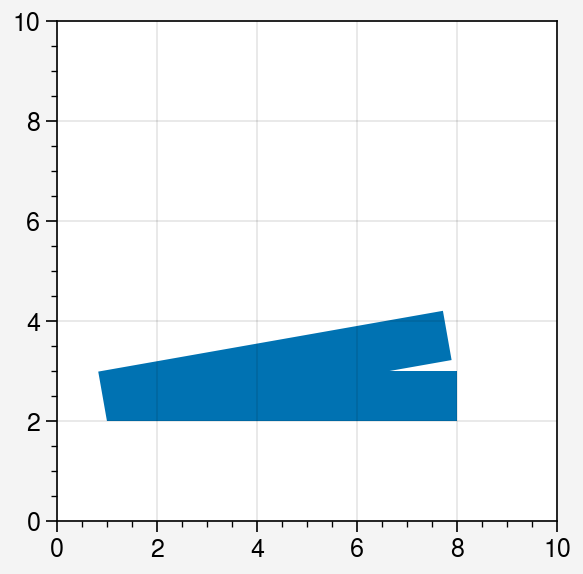

In [8]:
fig, ax = pplt.subplots()

rect = plt.Rectangle([1, 2], 7, 1)
ax.add_patch(rect)
rect = plt.Rectangle([1, 2], 7, 1, angle=10)
ax.add_patch(rect)

ax.format(xlim=[0, 10], ylim=[0, 10])

In [17]:
a_deg

0.39269908169872414

In [18]:
np.pi/4

0.7853981633974483

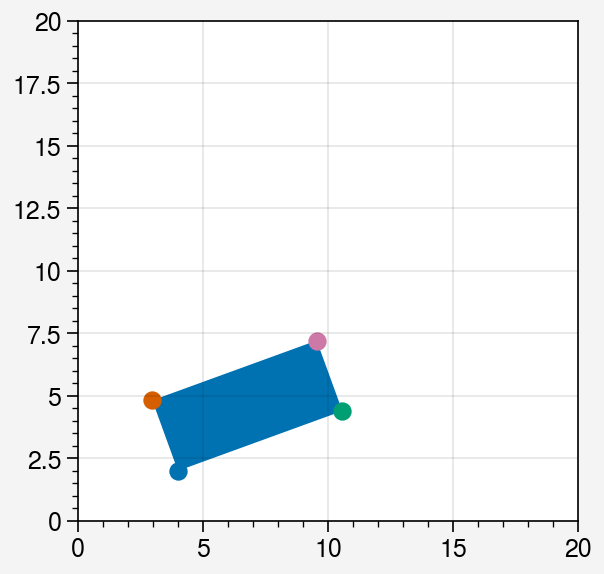

In [29]:
fig, ax = pplt.subplots()

corner = [4, 2]
width = 7
height = 3
angle = 20
a = angle * np.pi/180
rect = plt.Rectangle(corner, width, height, angle=angle)
ax.add_patch(rect)

dx1 = np.cos(a+np.pi/2)*height #x shift from UL point of corner
dy1 = np.sin(a+np.pi/2)*height #y shift from UL point of corner
dx2 = np.cos(a)*width #x shift from LR point of corner
dy2 = np.sin(a)*width #y shift from LR point of corner
# UR point is combination of d1+d2

ax.scatter([corner[0]], [corner[1]])
ax.scatter([corner[0]+dx1], [corner[1]+dy1])
ax.scatter([corner[0]+dx2], [corner[1]+dy2])
ax.scatter([corner[0]+dx1+dx2], [corner[1]+dy1+dy2])



ax.format(xlim=[0, 20], ylim=[0, 20])

In [133]:
env = AppleNavEnv(task_structure=1)
env.reset()


array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.34365331, 0.33451367, 0.45532

In [3]:
import numpy as np
import gym
from gym import spaces
import math
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
import io
import itertools

'''
This is the environment currently used for continuous MWM task

'''

MAX_MARCH = 20
EPSILON = 0.1
DEG_TO_RAD = 0.0174533
WINDOW_SIZE = (300, 300) # Width x Height in pixels
MAX_LEN = np.linalg.norm(WINDOW_SIZE)

object_to_idx = {
    'wall': 1,
    'goal': 2
}
color_to_idx = {
    'invisible': 0,
    'red': 1,
    'green': 2,
    'blue': 3,
    'yellow': 4,
    'purple': 5,
    'white': 6
}

idx_to_rgb = {
    0: np.array([0.6, 0.6, 0.6]),
    1: np.array([0.9, 0, 0]),
    2: np.array([0, 0.9, 0]),
    3: np.array([0, 0, 0.9]),
    4: np.array([0.9, 0.9, 0]),
    5: np.array([0.9, 0, 0.9]),
    6: np.array([0.9, 0.9, 0.9])
}



def dist(v):
    '''calculate length of vector'''
    return np.linalg.norm(v)


class Character:
    def __init__(self, pos=[WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2], angle=0, color=4, size=10,
                fov=120*DEG_TO_RAD, num_rays=30, render_rays=True, one_hot_obs=False):
        '''
        Generate a character that can move through the window
        pos: starting position
        angle: starting angle (radians) angle always takes on values from -pi to pi
        color: color
        size: size
        fov: range of angles character can see using rays
        num_rays: fidelity of depth perception
        draw_rays: whether or not to draw the characters rays
        '''
        self.pos = pos
        self.angle = (angle + np.pi) % (2*np.pi) - np.pi
        self.color = color
        self.size = size
        self.fov = fov
        self.render_rays = render_rays
        self.num_rays = num_rays
        self.one_hot_obs = one_hot_obs        
        self.ray_max_len = np.linalg.norm(WINDOW_SIZE)+100

        
    
    def update_walls(self, vis_walls, vis_wall_refs, col_walls, col_wall_refs):
        '''
        Update references to walls. This should be called when the environment changes
        or upon initialization
        vis_walls: walls that can be seen by vision rays
        col_walls: walls that can be collided with
        '''
        self.vis_walls = list(vis_walls.values())
        self.vis_wall_refs = np.array(list(vis_wall_refs.values()))
        
        self.col_walls = list(col_walls.values())
        self.col_wall_refs = np.array(list(col_wall_refs.values()))
        self.col_wall_keys = list(col_walls.keys())
        #Walls organized into [x3, y3, x4, y4] which tell us where walls start and end
        self.wall_p = np.array(self.vis_walls).reshape(-1, 4)
        self.x3 = self.wall_p[:, 0].reshape(1, -1)
        self.y3 = self.wall_p[:, 1].reshape(1, -1)
        self.x4 = self.wall_p[:, 2].reshape(1, -1)
        self.y4 = self.wall_p[:, 3].reshape(1, -1)
        
        #Same for collidable walls for collision detection
        self.col_wall_p = np.array(self.col_walls).reshape(-1, 4)
        self.cx3 = self.col_wall_p[:, 0].reshape(1, -1)
        self.cy3 = self.col_wall_p[:, 1].reshape(1, -1)
        self.cx4 = self.col_wall_p[:, 2].reshape(1, -1)
        self.cy4 = self.col_wall_p[:, 3].reshape(1, -1)

        
    
    def update_rays(self):
        '''
        Update ray intersection computations
        This should be called every time the agent moves or turns
        https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect
        '''
        fov_start = self.angle - self.fov/2
        fov_end = fov_start + self.fov
        
        ray_angles = np.linspace(fov_start, fov_end, self.num_rays, endpoint=False)
        ray_mults = np.array([np.cos(ray_angles), np.sin(ray_angles)]).T
        ray_starts = np.full((self.num_rays, 2), self.pos)
        
        x1 = ray_starts[:, 0].reshape(-1, 1)
        y1 = ray_starts[:, 1].reshape(-1, 1)
        ray_ends = ray_mults * self.ray_max_len + self.pos
        x2 = ray_ends[:, 0].reshape(-1, 1)
        y2 = ray_ends[:, 1].reshape(-1, 1)
        
        #Compute intersect metrics
        epsilon = 1e-8
        denom = (self.y4-self.y3)*(x2-x1) - (self.x4-self.x3)*(y2-y1) + 1e-8
        ua = ((self.x4-self.x3)*(y1-self.y3) - (self.y4-self.y3)*(x1-self.x3)) / denom
        ub = ((x2-x1)*(y1-self.y3) - (y2-y1)*(x1-self.x3)) / denom

        #Compute x y intersects (they ARE both supposed to be ua)
        x = x1 + ua*(x2-x1)
        y = y1 + ua*(y2-y1)

        #Compute distances to intersects
        dists = np.sqrt((x - self.pos[0])**2 + (y - self.pos[1])**2)

        #Only keep distances with valid intersects
        mults = np.full(x.shape, 1.)
        mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

        #We get np.nan where lines are parallel which throws off the argmin
        # Setting parallel to inf should fix the issue
        dists[np.isnan(dists)] = np.inf

        wall_idxs = np.argmin(mults*dists, axis=1)
        wall_idxs2 = np.stack([np.arange(self.num_rays), wall_idxs])

        # inter_x = x[wall_idxs2[0], wall_idxs2[1]]
        # inter_y = y[wall_idxs2[0], wall_idxs2[1]]

        # Get distances, colors and a plottable        
        self.ray_dists = dists[wall_idxs2[0], wall_idxs2[1]]
        
        if self.one_hot_obs:
            self.ray_colors = list(map(lambda x: x.color-1, self.vis_wall_refs[wall_idxs]))
        else:
            self.ray_colors = list(map(lambda x: x.color-1, self.vis_wall_refs[wall_idxs]))
        
        ray_ends = ray_mults * self.ray_dists.reshape(-1, 1) + self.pos
        
        self.ray_plot = np.stack([ray_ends, 
                              np.array(list(self.pos)*len(ray_ends)).reshape(-1, 2)], 
                              axis=1).reshape(-1, 2)
            
    
    def draw(self, ax=None):
        '''
        draw the character
        '''
        angle1 = self.angle - 0.3
        angle2 = self.angle + 0.3
        point1 = [self.pos[0], self.pos[1]]
        point2 = [self.pos[0] - math.cos(angle1)*self.size, self.pos[1] - math.sin(angle1)*self.size]
        point3 = [self.pos[0] - math.cos(angle2)*self.size, self.pos[1] - math.sin(angle2)*self.size]

        draw_color = idx_to_rgb[self.color]
        
        poly = plt.Polygon([point1, point2, point3], fc=draw_color)
        if ax == None:
            plt.gca().add_patch(poly)
            
            if self.render_rays:
                plt.gca().plot(self.ray_plot.T[0], self.ray_plot.T[1], c='w', linewidth=1)
        else:
            ax.add_patch(poly)
            if self.render_rays:            
                ax.plot(self.ray_plot.T[0], self.ray_plot.T[1], c='w', linewidth=1)

       
        
    def move(self, speed):
        '''
        move in the faced direction with number of pixels of speed
        collision detection uses the same ray marching algorithm
        after moving, update the rays
        
        Note we have to pass the walls that can be collided with for movement
        '''
        start = self.pos
        end = [self.pos[0] + math.cos(self.angle) * speed, self.pos[1] + math.sin(self.angle) * speed]
        
        min_dist, collision_obj, collision_key = self.march(start, end)

        if collision_obj == None:
            self.pos[0] += math.cos(self.angle) * speed
            self.pos[1] += math.sin(self.angle) * speed
            
        else:
            min_dist = max(min_dist, speed * 0.1) # Make sure agent can't move backwards
            
            self.pos[0] += math.cos(self.angle) * (min_dist - speed * 0.1)
            self.pos[1] += math.sin(self.angle) * (min_dist - speed * 0.1)
        self.update_rays()

        return collision_obj, collision_key
            
            
    def march(self, start, end):
        '''
        March forward to check if there is collision with any walls
        start: starting position
        end: desired end position (may be stopped earlier if collision occurs)
        col_walls: wall objects that can detect collision
        col_wall_refs: corresponding wall object references
        '''                
        x1 = start[0]
        y1 = start[1]
        x2 = end[0]
        y2 = end[1]
        
        epsilon = 1e-8
        
        #Compute intersect metrics
        denom = (self.cy4-self.cy3)*(x2-x1) - (self.cx4-self.cx3)*(y2-y1) + epsilon
        ua = ((self.cx4-self.cx3)*(y1-self.cy3) - (self.cy4-self.cy3)*(x1-self.cx3)) / denom
        ub = ((x2-x1)*(y1-self.cy3) - (y2-y1)*(x1-self.cx3)) / denom

        #Compute x y intersects
        x = x1 + ua*(x2-x1)
        y = y1 + ua*(y2-y1)

        #Compute dists
        dists = np.sqrt((x - self.pos[0])**2 + (y - self.pos[1])**2).squeeze()
        
        #Only keep distances with valid intersects
        mults = np.full(x.shape, 1.)
        mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

        #We get np.nan where lines are parallel which throws off the argmin
        # Setting parallel to inf should fix the issue
        dists[np.isnan(dists)] = np.inf
        
        #Some intersection occurs
        if (mults != np.inf).any():
            min_idx = np.argmin(mults*dists)
            return dists[min_idx], self.col_wall_refs[min_idx], self.col_wall_keys[min_idx]
        else:
            return np.min(dists), None, None
                    
    
        
    def rotate(self, angle):
        self.angle += angle
        self.angle = (self.angle + np.pi) % (2*np.pi) - np.pi
        self.update_rays()
        
    
    def ray_obs(self, max_depth=MAX_LEN):
        '''
        Get all rays and their distances to objects
        normalize_depth: divide depth readings by value 
        '''
        
        if self.one_hot_obs:
            ray_colors = np.zeros((self.num_rays, 6))
            ray_colors[np.arange(self.num_rays), self.ray_colors] = 1
            ray_colors = ray_colors.reshape(-1)
        else:
            ray_colors = np.array(self.ray_colors) / 6
        ray_dists = np.array(self.ray_dists) / max_depth
        
        visual = np.append(ray_colors, ray_dists)
        return visual






class Box():
    def __init__(self, corner, size, color=1, is_goal=False, angle=0):
        self.size = size #this is a size 2 array for length and height
        self.color = color
        self.is_goal = is_goal
        self.corner = corner
        self.center = [self.corner[0] + self.size[0]/2, self.corner[1] + self.size[1]/2]
        self.angle = angle
            
    def draw(self, ax=None):
        rect = plt.Rectangle(self.corner, self.size[0], self.size[1], 
                             fc=idx_to_rgb[self.color], angle=self.angle)

        draw_color = idx_to_rgb[self.color]
        
        if ax == None:
            plt.gca().add_patch(rect)
        else:
            ax.add_patch(rect)
        
    def get_walls(self):
        width = self.size[0]
        height = self.size[1]
        
        a = self.angle * np.pi/180 #angle in radians
        dx1 = np.cos(a+np.pi/2)*height #x shift from UL point of corner
        dy1 = np.sin(a+np.pi/2)*height #y shift from UL point of corner
        dx2 = np.cos(a)*width #x shift from LR point of corner
        dy2 = np.sin(a)*width #y shift from LR point of corner
        
        # Corners of rectangle
        ll = (self.corner[0], self.corner[1])
        ul = (self.corner[0]+dx1, self.corner[1]+dy1)
        lr = (self.corner[0]+dx2, self.corner[1]+dy2)
        ur = (self.corner[0]+dx1+dx2, self.corner[1]+dy1+dy2)
        
        walls = [
                 [ll, ul], 
                 [ll, lr], 
                 [ul, ur], 
                 [lr, ur],
                ]
        return walls






class Ray():
    def __init__(self, start, angle, color=6):
        '''
        Ray for ray marching
        if render_march is True, then we render the sdf circles used to calculate march 
        '''
        self.start = start
        self.angle = angle
        self.color = color
        self.touched_obj = None
        self.obj_dist = MAX_LEN
        
        
    def update(self, start=None, angle=None, vis_walls=[], vis_wall_refs=[]):
        '''
        update position and angle, perform march, determine object and distance
        '''
        if start is not None:
            self.start = start
        if angle is not None:
            self.angle = angle
        self.obj_dist, self.touched_obj = self.march(vis_walls, vis_wall_refs)
        
                
    def march(self, vis_walls, vis_wall_refs):
        '''
        perform ray march, find collision with object
        '''
        end = self.start + np.array([np.cos(self.angle), np.sin(self.angle)]) * MAX_LEN
        # print(end)
        intersects = []
        for vis_wall in vis_walls:
            intersects.append(intersect(self.start, end, vis_wall[0], vis_wall[1]))
        
        min_dist = np.inf
        min_idx = 0
        for idx, inter in enumerate(intersects):
            if inter != None:
                d = dist((inter[0]-self.start[0], inter[1]-self.start[1]))
                if d < min_dist:
                    min_dist = d
                    min_idx = idx
        # print(min_dist)
        if min_idx == None:
            return min_dist, min_idx
        else:
            return min_dist, vis_wall_refs[min_idx]
    
    def draw(self, ax=None):
        rect = plt.Rectangle(self.start, self.obj_dist, 1, self.angle * 180 / np.pi, fc=idx_to_rgb[self.color])

        draw_color = idx_to_rgb[self.color]
        if ax == None:
            plt.gca().add_patch(rect)
        else:
            ax.add_patch(rect)
        # plt.scatter([self.start[0]+self.obj_dist*math.cos(self.angle)], [self.start[1]+self.obj_dist*math.sin(self.angle)])
        
            
            
            

def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)






class PlumNavEnv(gym.Env):
    metadata = {"render.modes": ['rgb_array', 'human'], 'video.frames_per_second': 24}
    def __init__(self, num_rays=12, fov=1, max_steps=200,
                rew_structure='goal', give_heading=0, verbose=0,
                world_gen_func=None, world_gen_params={}, give_dist=True,
                give_time=False, collission_penalty=0, default_reward=0,
                sub_goal_reward=0.01, goal_reward=0.1, goal_visible=True,
                task_structure=1, poster=False, auxiliary_tasks=[],
                auxiliary_task_args=[], fixed_reset=[None, None],
                character_reset_pos=0, turn_speed=0.3, move_speed=10,
                num_actions=4, num_grid_slices=5, goal_size=25, goal_corner=None,
                separate_aux_tasks=False, poster_thickness=None,
                render_character=True, wall_thickness=None,
                one_hot_obs=True, num_plums=2,
                wall_colors=1):
        '''
        rew_structure: 'dist' - reward given based on distance to goal
                        'goal' - reward only given when goal reached
                        'explore' - additional reward given for each section explored
                        'explorepunish' - negative reward given when spending time near previous spots
        give_heading: whether to additionally give a distance and direction to goal
        flat: whether to give observations in a flattened state
        world_gen_func: a function can be passed to manually create a world
            using some other rules. Note that it needs to generate objects, a goal, and
            set the agent position and heading
            The character will be passed as the argument
        wall_colors: 
            1: red, red, red, red
            1.5: white, white, white, white (matching shortcut wall)
            4: red, green, blue, purple
            
        shortcut_config:
            1: 1 standard shortcut
            2: 2 shortcuts where shortcuts are farther from respective entrances
            2.5: 2 shortcuts where shortcuts are closer to respective entrances
        task_structure:
            1: visible goal, randomize position
            2: invisible goal, fixed position
            3: invisible goal, randomize position of char and goal at start
                try to reach the goal as many times as possible over fixed length episode
            4: invisible target. Agent is told which grid the target is assigned to through a one-hot
                encoding (pool divided into 5x5 grid of possible target cells). Every 40 timesteps the
                location changes
            5: same as 2 (invisible goal, fixed pos), but an additional action can be pressed to
                end the episode. If the agent is on top of the platform, they get a reward on reset
        poster:
            whether there should be a poster and on which wall [0-3]
        auxiliary_tasks: (pass as list of tasks desired)
            'null': task to output constant 0
            'euclidean_start': task to output euclidean distance travelled from start of episode
            'wall_direction': task to output relative degrees required to face a certain wall
            'terminal': task to output expected number of steps to episode end
                weighted by average episode length
        auxiliary_task_args: (pass as a list of arguments)
            'null': None (might later implement task to output n values)
            'euclidean_start': None
            'wall_direction': 1 (default), 2, 3, or 4 - pass wall that should be faced (east is 1, ccw)
        fixed_reset: (list of [np.ndarray, float]):
            First entry - fixed point to reset to
            Second entry - fixed angle to reset to
        character_reset_pos: 
            0: Default reset position - starting at the bottom and facing up
            1: Starting from anywhere in bottom right quadrant facing top half
            2: Starting from anywhere in bottom right quadrant facing any direction
            3: Starting from anywhere below shortcut wall
        goal_size: size of goal as int or array
        goal_corner: array giving x and y position of bottom left corner. If None, use default world
            generator function values
        separate_aux_tasks: !!must set to True to use new aux task learners that expect
            a list of auxiliary outputs (e.g. PPOAux, RolloutStorageAux etc.)
        poster_thickness: if given a value, set poster thickness to that value. Implemented
            to draw plots where the poster is clearer
        render_character: whether to render the character when rending the environment
        wall_thickness: if given a value, set wall thickness to that value
        one_hot_obs: wheter to set colors to be a one-hot encoded vector
            If False, colors are evenly spaced float values between 0 and 1, spaced by 7 possible values
        '''
        super(PlumNavEnv, self).__init__()

        #this gives the auxiliary tasks available and dimension of output
        available_auxiliary_tasks = {
            'null': 1,
            'euclidean_start': 1,
            'wall_direction': 1,
            'goal_dist': 1
        }
        auxiliary_task_to_idx = {
            'null': 0,
            'euclidean_start': 1,
            'wall_direction': 2,
            'goal_dist': 3
        }
        
        self.total_rewards = 0
        self.give_dist = give_dist
        self.give_heading = give_heading
        self.give_time = give_time
        self.collission_penalty = collission_penalty
        self.default_reward = default_reward
        self.sub_goal_reward = sub_goal_reward
        self.goal_reward = goal_reward
        self.rew_structure = rew_structure
        self.task_structure = task_structure
        self.verbose = verbose
        self.world_gen_func = world_gen_func
        self.world_gen_params = world_gen_params
        self.goal_visible = goal_visible # Note: not used, visibility defined by
                                         # task structure at the moment
        if type(goal_size) == list:
            self.goal_size = np.array(goal_size)
        self.goal_size = goal_size
        self.goal_corner = goal_corner
        self.poster = poster
        self.num_rays = num_rays
        self.fov = fov
        if type(fixed_reset[0]) == list:
            fixed_reset[0] = np.array(fixed_reset[0])
        self.fixed_reset = fixed_reset
        self.character_reset_pos = character_reset_pos
        self.turn_speed = turn_speed
        self.move_speed = move_speed
        self.num_actions = num_actions
        self.num_grid_slices = num_grid_slices
        self.target_grid = 0
        self.last_reward = 0
        self.poster_thickness = poster_thickness
        self.wall_thickness = wall_thickness
        self.wall_colors = wall_colors
        self.num_plums = num_plums
        
        observation_width = num_rays
        self.ray_obs_width = num_rays
        self.one_hot_obs = one_hot_obs
        
        if self.one_hot_obs:
            observation_width = num_rays * 6
        
        if give_dist:
            observation_width += num_rays
            self.ray_obs_width = observation_width
        if give_heading:
            observation_width += 1
        if give_time:
            observation_width += 1
        #For ongoing episode resetting position when goal reached,
        #agent needs to be told when platform is actually reached
        if task_structure == 3:
            observation_width += 1
            
        # task structure 4 tells the agent on which grid the goal is
        if task_structure == 4:
            num_grid = self.num_grid_slices ** 2
            observation_width += num_grid + 1
        
        #Add action for task_structure 5 that allows the agent to end the episode
        if task_structure == 5:
            self.num_actions = self.num_actions + 1

        self.observation_space = spaces.Box(low=0, high=1, shape=(observation_width,))
        self.action_space = spaces.Discrete(self.num_actions) #turn left, forward, right as actions
        
        self.max_steps = max_steps
        self.current_steps = 0
        
        self.generate_valid_plum_grid()
        self.character = Character(num_rays=self.num_rays, fov=self.fov, one_hot_obs=one_hot_obs)
        self.initial_character_position = self.character.pos.copy()
        self.render_character = render_character
        
        self.fig = None
        
        self.boxes = {}
        self.vis_walls = {}
        self.vis_wall_refs = {}
        self.col_walls = {}
        self.col_wall_refs = {}

        self.visited_sections = np.zeros((num_grid_slices, num_grid_slices,))


        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        self.auxiliary_tasks = []
        self.auxiliary_task_args = auxiliary_task_args
        for task in auxiliary_tasks:
            if type(task) == int:
                self.auxiliary_tasks.append(task)
            elif task not in available_auxiliary_tasks.keys():
                raise NotImplementedError('Auxiliary task {} not found. Available options are '.format(
                    task, ', '.join(available_auxiliary_tasks.keys())))
            else:
                self.auxiliary_tasks.append(auxiliary_task_to_idx[task])
        self.separate_aux_tasks = separate_aux_tasks
        
        # self.auxiliary_tasks = [auxiliary_task_to_idx[task] for task in auxiliary_tasks]
        # print('auxiliary tasks', self.auxiliary_tasks)
        
        # New Character class: need to pass walls
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                            self.col_walls, self.col_wall_refs)
        
    def step(self, action):
        reward = self.default_reward
        collision_obj, collision_key = None, None
        done = False
        info = {}
        
        if action == 0:
            self.character.rotate(-self.turn_speed)
        if action == 1:
            collision_obj, collision_key = self.character.move(self.move_speed)
        if action == 2:
            self.character.rotate(self.turn_speed)
        if action == 3:
            pass


        elif self.rew_structure == 'explore': 
            x_grids = np.linspace(0, WINDOW_SIZE[0], self.num_grid_slices+1)
            y_grids = np.linspace(0, WINDOW_SIZE[1], self.num_grid_slices+1)
            x = self.character.pos[0]
            y = self.character.pos[1]
            x_where = np.argwhere(x < x_grids)
            y_where = np.argwhere(y < y_grids)
            if len(x_where) > 0:
                x_grid = x_where[0] - 1
            else:
                x_grid = self.num_grid_slices - 1
            if len(y_where) > 0:
                y_grid = y_where[0] - 1
            else:
                y_grid = self.num_grid_slices - 1
            
            if self.visited_sections[x_grid, y_grid] == 0:
                self.visited_sections[x_grid, y_grid] = 1
                reward += self.sub_goal_reward
                info['bonus_reward'] = self.sub_goal_reward
            else:
                info['bonus_reward'] = 0
        elif self.rew_structure == 'explorepunish':
            pos = self.character.pos
            self.visited_positions[self.visited_idx] = pos.copy()
            self.visited_idx += 1

            lim_idx = int(np.clip(self.visited_idx-10, 0, np.inf))
            
            if lim_idx > 0:
                dists = self.visited_positions[:lim_idx] - pos
                dist = np.min(np.sum(dists**2, axis=1))
                dist = np.sqrt(dist)
                
                # This pretty much goes to 0 around dist of 50, which is tuned
                #  to a move speed of 10
                punish = -np.exp(-dist/10) * self.sub_goal_reward
                reward += punish
                info['bonus_reward'] = punish
            
            
        if collision_obj != None:
            if '_' in collision_key:
                base_key = collision_key.split('_')[0]
                if 'plum' in base_key:
                    if self.verbose:
                        print('plum obtained!')
                        
                    plum_id = base_key[4]                    
                    reward = float(self.goal_reward)
                    self.generate_plum(plum_id)
                    
                    self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                            self.col_walls, self.col_wall_refs)
                    self.character.update_rays()
            
            else:
                reward = float(self.collission_penalty)
                

        self.last_reward = reward
        observation = self.get_observation()
        
        auxiliary_output = self.get_auxiliary_output()
        info['auxiliary'] = auxiliary_output
        
        if self.current_steps > self.max_steps:
            done = True
        
        self.current_steps += 1
        self.total_rewards += reward
        if done and self.verbose:
            print('done, total_reward:{}'.format(self.total_rewards))
        return observation, reward, done, info
    

    def reset(self):
        """
        start_point (numpy array, optional): Set the starting point
            of the agent
        start_angle (float, optional): Set the starting angle of the 
            agent
        """
        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        
        start_point = self.fixed_reset[0]
        start_angle = self.fixed_reset[1]
        if start_point is not None:
            if type(start_point) is not np.ndarray:
                raise ValueError("start_point must be np.ndarray")
            self.character.pos = start_point.copy()
        if start_angle is not None:
            self.character.angle = start_angle
        if self.task_structure == 4:
            self.change_target_grid()
        
        self.character.update_rays()
        observation = self.get_observation()
        self.initial_character_position = self.character.pos.copy()
        self.current_steps = 0
        self.total_rewards = 0
        
        self.visited_sections = np.zeros((self.num_grid_slices, self.num_grid_slices,))
        self.visited_positions = np.full((self.max_steps + 50, 2), np.inf)
        self.visited_idx = 0

        return observation

    
    def render(self, mode='rgb_array', ax=None):
        if ax == None:
            plt.style.use('dark_background')
            fig = plt.figure(figsize=(6,6))
            plt.xlim([0, WINDOW_SIZE[0]])
            plt.ylim([0, WINDOW_SIZE[1]])

        if self.render_character:
            self.character.draw(ax=ax)
        
        for box in self.boxes.values():
            box.draw(ax=ax)
        if self.task_structure == 4:
            x_grid = int(np.floor(self.target_grid / self.num_grid_slices))
            y_grid = self.target_grid % self.num_grid_slices
            x_low = x_grid * WINDOW_SIZE[0] / self.num_grid_slices
            y_low = y_grid * WINDOW_SIZE[1] / self.num_grid_slices
            x_size = WINDOW_SIZE[0] / self.num_grid_slices
            y_size = WINDOW_SIZE[1] / self.num_grid_slices
            corner = np.array([x_low, y_low])
            size = np.array([x_size, y_size])
            grid_box = Box(corner, size, color=6, is_goal=True)
            grid_box.draw(ax=ax)
        
        #trim borders
        # image_from_plot = image_from_plot[52:380,52:390,:]
        
        # with io.BytesIO() as buff:
        #     fig.savefig(buff, format='raw')
        #     buff.seek(0)
        #     data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
        # w, h = fig.canvas.get_width_height()
        # im = data.reshape((int(h), int(w), -1))
        
        if mode == 'human' and ax == None:
            plt.show()
            
        if mode == 'rgb_array':
            fig.canvas.draw()
            image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image_from_plot
            
            # return im
            
        
    def get_observation(self):
#         ray_depths, ray_colors = self.character.ray_obs()
#         return np.append(ray_depths, ray_colors)

        if self.give_heading > 0:
            raise NotImplementedError('Have not adjusted give_heading code')
            #tell where the goal is distance and heading
            ray_obs = self.character.ray_obs()
            goal = objects[-1]
            dist_to_goal = np.clip(dist(goal.center - self.character.pos), 0, 1000) / 1000
            heading = goal.center - self.character.pos
            heading = np.arctan2(heading[1], heading[0])

            if self.give_heading == 1:
                #only give distance to goal
                obs = np.vstack([ray_obs, [dist_to_goal, 0, 0]])
            elif self.give_heading == 2:
                #give distance and angle to goal
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, 0]])
            elif self.give_heading == 3:
                #give distance and angle to goal and current agent angle
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, self.character.angle]])
            
                        
            return np.array(obs.reshape(-1), dtype='float')
            
        else:
            obs = self.character.ray_obs()
            if not self.give_dist:
                obs = obs[:self.num_rays]
            if self.task_structure == 3:
                obs = np.append(obs, [0.])
            if self.task_structure == 4:
                # Need to create one-hot encoding for grid target
                num_grid = self.num_grid_slices ** 2
                obs_add = np.zeros(num_grid + 1)
                obs_add[self.target_grid] = 1
                obs_add[num_grid] = self.last_reward
                obs = np.append(obs, obs_add)

            return obs
        
        
    def get_auxiliary_output(self):
        '''Return the auxiliary output dependent on what tasks are being measured'''
                
        auxiliary_output = []
        
        for i in range(len(self.auxiliary_tasks)):
        # for i, task in self.auxiliary_tasks:
            task = self.auxiliary_tasks[i]
            if i >= len(self.auxiliary_task_args):
                aux_arg = None
            else:
                aux_arg = self.auxiliary_task_args[i]
            #0: null task - predict 0
            if task == 0:
                output = [0]
            #1: euclidean distance from start task (normalized)
            if task == 1:
                euclid_dist_start = dist(self.character.pos - self.initial_character_position)
                euclid_dist_start = euclid_dist_start / MAX_LEN
                output = [euclid_dist_start]
            #2: relative angle from wall, depending on arg passed
                # give int from 0 to 3, 0 is east and 3 is south
            if task == 2:
                if aux_arg == None:
                    wall = 0
                else:
                    wall = aux_arg
                if wall < 0 or wall > 3:
                    raise Exception('Invalid wall number passed for relative wall direction auxiliary' + \
                        'task. Must use an integer between 0 and 3, or None (defaults to 0)')
                
                if wall > 2:
                    wall = wall - 4
                wall_angle = (wall * 0.5) * np.pi
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                
                min_rel_angle = np.min([abs(wall_angle - char_2pi_angle), 
                                        abs(wall_angle + 2*np.pi - char_2pi_angle)])
                min_rel_angle = min_rel_angle / np.pi
                output = [min_rel_angle]
            #3: distance between agent and goal
            if task == 3:
                goal_pos = self.boxes[-1].center
                char_pos = self.character.pos
                goal_dist = dist(char_pos - goal_pos)
                #normalize distance to [0, 1]
                goal_dist = goal_dist / MAX_LEN
                output = [goal_dist]
            #4-6 categorical auxiliary tasks
            #4: currently faced wall - output label 0-3 for currently faced wall
            if task == 4:
                #conversion of angle to be between 0 and 2pi, then check quadrant of angle faced
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                if char_2pi_angle < (np.pi/2):
                    quadrant = 0
                elif char_2pi_angle < (np.pi):
                    quadrant = 1
                elif char_2pi_angle < (np.pi*3/2):
                    quadrant = 2
                else:
                    quadrant = 3
                output = [quadrant]
            #5: left/right turn to face wall
            #  give int from 0 to 3 where 0 is east and 3 is south, agent
            #  must output 0 if a left turn or 1 if a right turn is faster to face that wall
            #  categorical analog to task 2
            if task == 5:
                if aux_arg == None:
                    wall = 0
                else:
                    wall = aux_arg
                if wall < 0 or wall > 3:
                    raise Exception('Invalid wall number passed for relative wall direction auxiliary' + \
                        'task. Must use an integer between 0 and 3, or None (defaults to 0)')
                
                if wall > 2:
                    wall = wall - 4
                wall_angle = (wall * 0.5) * np.pi
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                
                left_angle = wall_angle - char_2pi_angle
                if left_angle < 0:
                    left_angle = 2*np.pi + left_angle
                right_angle = 2*np.pi - left_angle
                if left_angle > right_angle:
                    direction = 0
                else:
                    direction = 1
                output = [direction]
            #6: current quadrant location - output label 0-3 for current quadrant
            if task == 6:
                quadrant = 0
                char_pos = self.character.pos
                if char_pos[0] > WINDOW_SIZE[0]/2:
                    quadrant += 1
                if char_pos[1] > WINDOW_SIZE[1]/2:
                    quadrant += 2
                output = [quadrant]                
            if self.separate_aux_tasks:
                auxiliary_output.append(output)
            else:
                auxiliary_output += output
        if self.separate_aux_tasks:
            return auxiliary_output
        else:
            return np.array(auxiliary_output)
    

    def generate_world(self):
        if self.wall_thickness == None:
            wall_thickness = 1
        else:
            wall_thickness = self.wall_thickness
        
        boxes, walls, wall_refs = self.make_outer_walls(thickness=wall_thickness)
        for i in range(4):
            key = f'outer{i}'
            self.boxes[key] = boxes[i]
            self.vis_walls[key] = walls[i]
            self.col_walls[key] = walls[i]
            self.vis_wall_refs[key] = wall_refs[i]
            self.col_wall_refs[key] = wall_refs[i]
            
            
        
        # Generate 4 boxes
        if self.task_structure == 1 or self.task_structure == 1.5:
            corners = [np.array([50., 175.]),
                    np.array([175., 175.]),
                    np.array([50., 50.]),
                    np.array([175., 50.])]
            colors = ['red', 'green', 'yellow', 'purple']
            if self.task_structure == 1.5:
                colors = np.random.permutation(colors)
            
            for i, corner in enumerate(corners):
                key = f'square{i}'
                box = Box(corner, np.array([75., 75.]), color=color_to_idx[colors[i]])
                self.add_box_to_walls(box, key)
                            
        # Generate random slanted walls
        if self.task_structure == 2 or self.task_structure == 2.5:
            corners = [
                np.array([40., 80.]),
                np.array([175., 120.]),
                np.array([175., 120.])
            ]
            angles = [
                -30.,
                -80.,
                200.,
                
            ]
            widths = [
                80.,
                70.,
                80.,
            ]
            
            for i in range(len(corners)):
                corner = corners[i]
                angle = angles[i]
                width = widths[i]
                height = 5
                key = f'box{i}'
                box = Box(corner, np.array([width, height]), angle=angle)
                self.add_box_to_walls(box, key)
                
                
        for i in range(self.num_plums):
            self.generate_plum(i)

            
        pos_x = np.random.uniform(125, 175)
        pos_y = np.random.uniform(10, 60)
        pos = np.array([pos_x, pos_y])
        angle = np.random.uniform(np.pi/2-0.2, np.pi/2+0.2)
            
        self.character = Character(pos, angle, num_rays=self.num_rays, fov=self.fov, one_hot_obs=self.one_hot_obs)
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                                    self.col_walls, self.col_wall_refs)
        
        
        
    def generate_valid_plum_grid(self):
        # Based on task structure, find where apples can be generated from
        
        if self.task_structure == 1 or self.task_structure == 1.5:
            xgrid = np.linspace(5, 285, 140)
            grid = np.vstack(list(itertools.product(xgrid, xgrid)))
            corners = [np.array([50., 175.]),
                    np.array([175., 175.]),
                    np.array([50., 50.]),
                    np.array([175., 50.])]
            for corner in corners:
                grid = grid[~( (grid[:, 0] > corner[0]-5) & (grid[:, 0] < corner[0]+80) & \
                            (grid[:, 1] > corner[1]-5) & (grid[:, 1] < corner[1]+80) )]
            self.plum_grid = grid
            
        elif self.task_structure == 2 or self.task_structure == 2.5:
            pass
            
    def add_box_to_walls(self, box, base_key, vis=True, col=True):
        # Add the walls of a box to dictionary of walls
        self.boxes[base_key] = box
        walls = box.get_walls()
        for j, wall in enumerate(walls):
            key = base_key + f'_{j}'
            self.vis_walls[key] = wall
            self.vis_wall_refs[key] = box
            self.col_walls[key] = wall
            self.col_wall_refs[key] = box

        
    def generate_plum(self, id=1):
        # Pick a spot from the plum grid to generate a plum on
        idx = np.random.choice(range(len(self.plum_grid)))
        corner = self.plum_grid[idx]
        plum = Box(corner, np.array([10., 10.]), color=color_to_idx['blue'])
        key = f'plum{id}'
        self.add_box_to_walls(plum, key)
        


    def reset_character_position(self):
        #Reset character position alone, used for task_structure 3
        # to reset character but not end episode after goal found
        searching = True
        goal_center = np.array(self.boxes[-1].center)
        if type(self.goal_size) == int:
            goal_size = [self.goal_size, self.goal_size]
        elif type(self.goal_size) == list:
            goal_size = self.goal_size
        else:
            goal_size = [20, 20]
        wall_thickness = 1
        
        pos = self.fixed_reset[0]
        angle = self.fixed_reset[1]
                    
        if angle == None:
            angle = np.random.uniform(0, 2*np.pi)

        self.character = Character(pos, angle, num_rays=self.num_rays, fov=self.fov,
                                   one_hot_obs=self.one_hot_obs)
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                                    self.col_walls, self.col_wall_refs)
        self.character.update_rays()


    def make_outer_walls(self, thickness=1, with_shortwall=[True]):
        boxes = []
        y = WINDOW_SIZE[1]
        x = WINDOW_SIZE[0]

        if self.wall_colors == 4:
            walls = ['red', 'green', 'blue', 'yellow']
            wall_colors = [color_to_idx[color] for color in walls]        
        elif self.wall_colors == 1:
            walls = ['white', 'white', 'white', 'white']
            wall_colors = [color_to_idx[color] for color in walls]

        #outer walls
        boxes.append(Box(np.array([0, 0]), np.array([thickness, y]), color=wall_colors[2]))
        boxes.append(Box(np.array([0, 0]), np.array([x, thickness]), color=wall_colors[3]))
        boxes.append(Box(np.array([0, y-thickness]), np.array([x, thickness]), color=wall_colors[1]))
        boxes.append(Box(np.array([x-thickness, 0]), np.array([thickness, y]), color=wall_colors[0]))
                    
        # manually create walls here so that we don't need to check more walls than necessary
        # on intersections
        walls = [
            [[thickness, 0], [thickness, y]],
            [[0, thickness], [x, thickness]],
            [[0, y-thickness], [x, y-thickness]],
            [[x-thickness, 0], [x-thickness, y]]
        ]
        wall_refs = [
            boxes[0],
            boxes[1],
            boxes[2],
            boxes[3]
        ]
        
        return boxes, walls, wall_refs
        
    def get_walls(self, boxes):
        '''
        Get tuples of points to intersect with for rays from a list of boxes
        '''
        walls = []
        wall_refs = []
        for box in boxes:
            walls = walls + box.get_walls()
            wall_refs = wall_refs + [box] * 4
        return walls, wall_refs
    
    def change_target_grid(self):
        num_grid = self.num_grid_slices ** 2
        self.target_grid = np.random.choice(np.arange(num_grid))
        
    def test_platform(self):
        '''
        Used for task_structure 5 where agent must perform action 4 when they think
        they are on the platform. This function will test whether the agent is indeed on
        the platform
        '''
        char_pos = self.character.pos
        goal_pos = self.boxes[-1].center
        goal_size = self.boxes[-1].size
        
        pos_diff = np.abs(char_pos - goal_pos)
        return np.all(pos_diff <= goal_size)
        
        
        

    def seed(self, seed=0):
        np.random.seed(seed)



In [4]:
env = PlumNavEnv()

In [75]:
import numpy as np
import gym
from gym import spaces
import math
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
import io
import itertools

'''
This is the environment currently used for continuous MWM task

'''

MAX_MARCH = 20
EPSILON = 0.1
DEG_TO_RAD = 0.0174533
WINDOW_SIZE = (300, 300) # Width x Height in pixels
MAX_LEN = np.linalg.norm(WINDOW_SIZE)

object_to_idx = {
    'wall': 1,
    'goal': 2
}
color_to_idx = {
    'invisible': 0,
    'red': 1,
    'green': 2,
    'blue': 3,
    'yellow': 4,
    'purple': 5,
    'white': 6
}

idx_to_rgb = {
    0: np.array([0.6, 0.6, 0.6]),
    1: np.array([0.9, 0, 0]),
    2: np.array([0, 0.9, 0]),
    3: np.array([0, 0, 0.9]),
    4: np.array([0.9, 0.9, 0]),
    5: np.array([0.9, 0, 0.9]),
    6: np.array([0.9, 0.9, 0.9])
}



def dist(v):
    '''calculate length of vector'''
    return np.linalg.norm(v)


class Character:
    def __init__(self, pos=[WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2], angle=0, color=4, size=10,
                fov=120*DEG_TO_RAD, num_rays=30, render_rays=True, one_hot_obs=False):
        '''
        Generate a character that can move through the window
        pos: starting position
        angle: starting angle (radians) angle always takes on values from -pi to pi
        color: color
        size: size
        fov: range of angles character can see using rays
        num_rays: fidelity of depth perception
        draw_rays: whether or not to draw the characters rays
        '''
        self.pos = pos
        self.angle = (angle + np.pi) % (2*np.pi) - np.pi
        self.color = color
        self.size = size
        self.fov = fov
        self.render_rays = render_rays
        self.num_rays = num_rays
        self.one_hot_obs = one_hot_obs        
        self.ray_max_len = np.linalg.norm(WINDOW_SIZE)+100

        
    
    def update_walls(self, vis_walls, vis_wall_refs, col_walls, col_wall_refs):
        '''
        Update references to walls. This should be called when the environment changes
        or upon initialization
        vis_walls: walls that can be seen by vision rays
        col_walls: walls that can be collided with
        '''
        self.vis_walls = list(vis_walls.values())
        self.vis_wall_refs = np.array(list(vis_wall_refs.values()))
        
        self.col_walls = list(col_walls.values())
        self.col_wall_refs = np.array(list(col_wall_refs.values()))
        self.col_wall_keys = list(col_walls.keys())
        #Walls organized into [x3, y3, x4, y4] which tell us where walls start and end
        self.wall_p = np.array(self.vis_walls).reshape(-1, 4)
        self.x3 = self.wall_p[:, 0].reshape(1, -1)
        self.y3 = self.wall_p[:, 1].reshape(1, -1)
        self.x4 = self.wall_p[:, 2].reshape(1, -1)
        self.y4 = self.wall_p[:, 3].reshape(1, -1)
        
        #Same for collidable walls for collision detection
        self.col_wall_p = np.array(self.col_walls).reshape(-1, 4)
        self.cx3 = self.col_wall_p[:, 0].reshape(1, -1)
        self.cy3 = self.col_wall_p[:, 1].reshape(1, -1)
        self.cx4 = self.col_wall_p[:, 2].reshape(1, -1)
        self.cy4 = self.col_wall_p[:, 3].reshape(1, -1)

        
    
    def update_rays(self):
        '''
        Update ray intersection computations
        This should be called every time the agent moves or turns
        https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect
        '''
        fov_start = self.angle - self.fov/2
        fov_end = fov_start + self.fov
        
        ray_angles = np.linspace(fov_start, fov_end, self.num_rays, endpoint=False)
        ray_mults = np.array([np.cos(ray_angles), np.sin(ray_angles)]).T
        ray_starts = np.full((self.num_rays, 2), self.pos)
        
        x1 = ray_starts[:, 0].reshape(-1, 1)
        y1 = ray_starts[:, 1].reshape(-1, 1)
        ray_ends = ray_mults * self.ray_max_len + self.pos
        x2 = ray_ends[:, 0].reshape(-1, 1)
        y2 = ray_ends[:, 1].reshape(-1, 1)
        
        #Compute intersect metrics
        epsilon = 1e-8
        denom = (self.y4-self.y3)*(x2-x1) - (self.x4-self.x3)*(y2-y1) + 1e-8
        ua = ((self.x4-self.x3)*(y1-self.y3) - (self.y4-self.y3)*(x1-self.x3)) / denom
        ub = ((x2-x1)*(y1-self.y3) - (y2-y1)*(x1-self.x3)) / denom

        #Compute x y intersects (they ARE both supposed to be ua)
        x = x1 + ua*(x2-x1)
        y = y1 + ua*(y2-y1)

        #Compute distances to intersects
        dists = np.sqrt((x - self.pos[0])**2 + (y - self.pos[1])**2)

        #Only keep distances with valid intersects
        mults = np.full(x.shape, 1.)
        mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

        #We get np.nan where lines are parallel which throws off the argmin
        # Setting parallel to inf should fix the issue
        dists[np.isnan(dists)] = np.inf

        wall_idxs = np.argmin(mults*dists, axis=1)
        wall_idxs2 = np.stack([np.arange(self.num_rays), wall_idxs])

        # inter_x = x[wall_idxs2[0], wall_idxs2[1]]
        # inter_y = y[wall_idxs2[0], wall_idxs2[1]]

        # Get distances, colors and a plottable        
        self.ray_dists = dists[wall_idxs2[0], wall_idxs2[1]]
        
        if self.one_hot_obs:
            self.ray_colors = list(map(lambda x: x.color-1, self.vis_wall_refs[wall_idxs]))
        else:
            self.ray_colors = list(map(lambda x: x.color-1, self.vis_wall_refs[wall_idxs]))
        
        ray_ends = ray_mults * self.ray_dists.reshape(-1, 1) + self.pos
        
        self.ray_plot = np.stack([ray_ends, 
                              np.array(list(self.pos)*len(ray_ends)).reshape(-1, 2)], 
                              axis=1).reshape(-1, 2)
            
    
    def draw(self, ax=None):
        '''
        draw the character
        '''
        angle1 = self.angle - 0.3
        angle2 = self.angle + 0.3
        point1 = [self.pos[0], self.pos[1]]
        point2 = [self.pos[0] - math.cos(angle1)*self.size, self.pos[1] - math.sin(angle1)*self.size]
        point3 = [self.pos[0] - math.cos(angle2)*self.size, self.pos[1] - math.sin(angle2)*self.size]

        draw_color = idx_to_rgb[self.color]
        
        poly = plt.Polygon([point1, point2, point3], fc=draw_color)
        if ax == None:
            plt.gca().add_patch(poly)
            
            if self.render_rays:
                plt.gca().plot(self.ray_plot.T[0], self.ray_plot.T[1], c='w', linewidth=1)
        else:
            ax.add_patch(poly)
            if self.render_rays:            
                ax.plot(self.ray_plot.T[0], self.ray_plot.T[1], c='w', linewidth=1)

       
        
    def move(self, speed):
        '''
        move in the faced direction with number of pixels of speed
        collision detection uses the same ray marching algorithm
        after moving, update the rays
        
        Note we have to pass the walls that can be collided with for movement
        '''
        start = self.pos
        end = [self.pos[0] + math.cos(self.angle) * speed, self.pos[1] + math.sin(self.angle) * speed]
        
        min_dist, collision_obj, collision_key = self.march(start, end)

        if collision_obj == None:
            self.pos[0] += math.cos(self.angle) * speed
            self.pos[1] += math.sin(self.angle) * speed
            
        else:
            min_dist = max(min_dist, speed * 0.1) # Make sure agent can't move backwards
            
            self.pos[0] += math.cos(self.angle) * (min_dist - speed * 0.1)
            self.pos[1] += math.sin(self.angle) * (min_dist - speed * 0.1)
        self.update_rays()

        return collision_obj, collision_key
            
            
    def march(self, start, end):
        '''
        March forward to check if there is collision with any walls
        start: starting position
        end: desired end position (may be stopped earlier if collision occurs)
        col_walls: wall objects that can detect collision
        col_wall_refs: corresponding wall object references
        '''                
        x1 = start[0]
        y1 = start[1]
        x2 = end[0]
        y2 = end[1]
        
        epsilon = 1e-8
        
        #Compute intersect metrics
        denom = (self.cy4-self.cy3)*(x2-x1) - (self.cx4-self.cx3)*(y2-y1) + epsilon
        ua = ((self.cx4-self.cx3)*(y1-self.cy3) - (self.cy4-self.cy3)*(x1-self.cx3)) / denom
        ub = ((x2-x1)*(y1-self.cy3) - (y2-y1)*(x1-self.cx3)) / denom

        #Compute x y intersects
        x = x1 + ua*(x2-x1)
        y = y1 + ua*(y2-y1)

        #Compute dists
        dists = np.sqrt((x - self.pos[0])**2 + (y - self.pos[1])**2).squeeze()
        
        #Only keep distances with valid intersects
        mults = np.full(x.shape, 1.)
        mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

        #We get np.nan where lines are parallel which throws off the argmin
        # Setting parallel to inf should fix the issue
        dists[np.isnan(dists)] = np.inf
        
        #Some intersection occurs
        if (mults != np.inf).any():
            min_idx = np.argmin(mults*dists)
            return dists[min_idx], self.col_wall_refs[min_idx], self.col_wall_keys[min_idx]
        else:
            return np.min(dists), None, None
                    
    
        
    def rotate(self, angle):
        self.angle += angle
        self.angle = (self.angle + np.pi) % (2*np.pi) - np.pi
        self.update_rays()
        
    
    def ray_obs(self, max_depth=MAX_LEN):
        '''
        Get all rays and their distances to objects
        normalize_depth: divide depth readings by value 
        '''
        
        if self.one_hot_obs:
            ray_colors = np.zeros((self.num_rays, 6))
            ray_colors[np.arange(self.num_rays), self.ray_colors] = 1
            ray_colors = ray_colors.reshape(-1)
        else:
            ray_colors = np.array(self.ray_colors) / 6
        ray_dists = np.array(self.ray_dists) / max_depth
        
        visual = np.append(ray_colors, ray_dists)
        return visual






class Box():
    def __init__(self, corner, size, color=1, is_goal=False, angle=0):
        self.size = size #this is a size 2 array for length and height
        self.color = color
        self.is_goal = is_goal
        self.corner = corner
        self.center = [self.corner[0] + self.size[0]/2, self.corner[1] + self.size[1]/2]
        self.angle = angle
            
    def draw(self, ax=None):
        rect = plt.Rectangle(self.corner, self.size[0], self.size[1], 
                             fc=idx_to_rgb[self.color], angle=self.angle)

        draw_color = idx_to_rgb[self.color]
        
        if ax == None:
            plt.gca().add_patch(rect)
        else:
            ax.add_patch(rect)
        
    def get_walls(self):
        width = self.size[0]
        height = self.size[1]
        
        a = self.angle * np.pi/180 #angle in radians
        dx1 = np.cos(a+np.pi/2)*height #x shift from UL point of corner
        dy1 = np.sin(a+np.pi/2)*height #y shift from UL point of corner
        dx2 = np.cos(a)*width #x shift from LR point of corner
        dy2 = np.sin(a)*width #y shift from LR point of corner
        
        # Corners of rectangle
        ll = (self.corner[0], self.corner[1])
        ul = (self.corner[0]+dx1, self.corner[1]+dy1)
        lr = (self.corner[0]+dx2, self.corner[1]+dy2)
        ur = (self.corner[0]+dx1+dx2, self.corner[1]+dy1+dy2)
        
        walls = [
                 [ll, ul], 
                 [ll, lr], 
                 [ul, ur], 
                 [lr, ur],
                ]
        return walls






class Ray():
    def __init__(self, start, angle, color=6):
        '''
        Ray for ray marching
        if render_march is True, then we render the sdf circles used to calculate march 
        '''
        self.start = start
        self.angle = angle
        self.color = color
        self.touched_obj = None
        self.obj_dist = MAX_LEN
        
        
    def update(self, start=None, angle=None, vis_walls=[], vis_wall_refs=[]):
        '''
        update position and angle, perform march, determine object and distance
        '''
        if start is not None:
            self.start = start
        if angle is not None:
            self.angle = angle
        self.obj_dist, self.touched_obj = self.march(vis_walls, vis_wall_refs)
        
                
    def march(self, vis_walls, vis_wall_refs):
        '''
        perform ray march, find collision with object
        '''
        end = self.start + np.array([np.cos(self.angle), np.sin(self.angle)]) * MAX_LEN
        # print(end)
        intersects = []
        for vis_wall in vis_walls:
            intersects.append(intersect(self.start, end, vis_wall[0], vis_wall[1]))
        
        min_dist = np.inf
        min_idx = 0
        for idx, inter in enumerate(intersects):
            if inter != None:
                d = dist((inter[0]-self.start[0], inter[1]-self.start[1]))
                if d < min_dist:
                    min_dist = d
                    min_idx = idx
        # print(min_dist)
        if min_idx == None:
            return min_dist, min_idx
        else:
            return min_dist, vis_wall_refs[min_idx]
    
    def draw(self, ax=None):
        rect = plt.Rectangle(self.start, self.obj_dist, 1, self.angle * 180 / np.pi, fc=idx_to_rgb[self.color])

        draw_color = idx_to_rgb[self.color]
        if ax == None:
            plt.gca().add_patch(rect)
        else:
            ax.add_patch(rect)
        # plt.scatter([self.start[0]+self.obj_dist*math.cos(self.angle)], [self.start[1]+self.obj_dist*math.sin(self.angle)])
        
            
            
            

def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)






class PlumNavEnv(gym.Env):
    metadata = {"render.modes": ['rgb_array', 'human'], 'video.frames_per_second': 24}
    def __init__(self, num_rays=12, fov=1, max_steps=200,
                rew_structure='goal', give_heading=0, verbose=0,
                world_gen_func=None, world_gen_params={}, give_dist=True,
                give_time=False, collission_penalty=0, default_reward=0,
                sub_goal_reward=0.01, goal_reward=0.1, goal_visible=True,
                task_structure=1, poster=False, auxiliary_tasks=[],
                auxiliary_task_args=[], fixed_reset=[None, None],
                character_reset_pos=0, turn_speed=0.3, move_speed=10,
                num_actions=4, num_grid_slices=5, goal_size=25, goal_corner=None,
                separate_aux_tasks=False, poster_thickness=None,
                render_character=True, wall_thickness=None,
                one_hot_obs=True, num_plums=2,
                wall_colors=1):
        '''
        rew_structure: 'dist' - reward given based on distance to goal
                        'goal' - reward only given when goal reached
                        'explore' - additional reward given for each section explored
                        'explorepunish' - negative reward given when spending time near previous spots
        give_heading: whether to additionally give a distance and direction to goal
        flat: whether to give observations in a flattened state
        world_gen_func: a function can be passed to manually create a world
            using some other rules. Note that it needs to generate objects, a goal, and
            set the agent position and heading
            The character will be passed as the argument
        wall_colors: 
            1: red, red, red, red
            1.5: white, white, white, white (matching shortcut wall)
            4: red, green, blue, purple
            
        shortcut_config:
            1: 1 standard shortcut
            2: 2 shortcuts where shortcuts are farther from respective entrances
            2.5: 2 shortcuts where shortcuts are closer to respective entrances
        task_structure:
            1: visible goal, randomize position
            2: invisible goal, fixed position
            3: invisible goal, randomize position of char and goal at start
                try to reach the goal as many times as possible over fixed length episode
            4: invisible target. Agent is told which grid the target is assigned to through a one-hot
                encoding (pool divided into 5x5 grid of possible target cells). Every 40 timesteps the
                location changes
            5: same as 2 (invisible goal, fixed pos), but an additional action can be pressed to
                end the episode. If the agent is on top of the platform, they get a reward on reset
        poster:
            whether there should be a poster and on which wall [0-3]
        auxiliary_tasks: (pass as list of tasks desired)
            'null': task to output constant 0
            'euclidean_start': task to output euclidean distance travelled from start of episode
            'wall_direction': task to output relative degrees required to face a certain wall
            'terminal': task to output expected number of steps to episode end
                weighted by average episode length
        auxiliary_task_args: (pass as a list of arguments)
            'null': None (might later implement task to output n values)
            'euclidean_start': None
            'wall_direction': 1 (default), 2, 3, or 4 - pass wall that should be faced (east is 1, ccw)
        fixed_reset: (list of [np.ndarray, float]):
            First entry - fixed point to reset to
            Second entry - fixed angle to reset to
        character_reset_pos: 
            0: Default reset position - starting at the bottom and facing up
            1: Starting from anywhere in bottom right quadrant facing top half
            2: Starting from anywhere in bottom right quadrant facing any direction
            3: Starting from anywhere below shortcut wall
        goal_size: size of goal as int or array
        goal_corner: array giving x and y position of bottom left corner. If None, use default world
            generator function values
        separate_aux_tasks: !!must set to True to use new aux task learners that expect
            a list of auxiliary outputs (e.g. PPOAux, RolloutStorageAux etc.)
        poster_thickness: if given a value, set poster thickness to that value. Implemented
            to draw plots where the poster is clearer
        render_character: whether to render the character when rending the environment
        wall_thickness: if given a value, set wall thickness to that value
        one_hot_obs: wheter to set colors to be a one-hot encoded vector
            If False, colors are evenly spaced float values between 0 and 1, spaced by 7 possible values
        '''
        super(PlumNavEnv, self).__init__()

        #this gives the auxiliary tasks available and dimension of output
        available_auxiliary_tasks = {
            'null': 1,
            'euclidean_start': 1,
            'wall_direction': 1,
            'goal_dist': 1
        }
        auxiliary_task_to_idx = {
            'null': 0,
            'euclidean_start': 1,
            'wall_direction': 2,
            'goal_dist': 3
        }
        
        self.total_rewards = 0
        self.give_dist = give_dist
        self.give_heading = give_heading
        self.give_time = give_time
        self.collission_penalty = collission_penalty
        self.default_reward = default_reward
        self.sub_goal_reward = sub_goal_reward
        self.goal_reward = goal_reward
        self.rew_structure = rew_structure
        self.task_structure = task_structure
        self.verbose = verbose
        self.world_gen_func = world_gen_func
        self.world_gen_params = world_gen_params
        self.goal_visible = goal_visible # Note: not used, visibility defined by
                                         # task structure at the moment
        if type(goal_size) == list:
            self.goal_size = np.array(goal_size)
        self.goal_size = goal_size
        self.goal_corner = goal_corner
        self.poster = poster
        self.num_rays = num_rays
        self.fov = fov
        if type(fixed_reset[0]) == list:
            fixed_reset[0] = np.array(fixed_reset[0])
        self.fixed_reset = fixed_reset
        self.character_reset_pos = character_reset_pos
        self.turn_speed = turn_speed
        self.move_speed = move_speed
        self.num_actions = num_actions
        self.num_grid_slices = num_grid_slices
        self.target_grid = 0
        self.last_reward = 0
        self.poster_thickness = poster_thickness
        self.wall_thickness = wall_thickness
        self.wall_colors = wall_colors
        self.num_plums = num_plums
        self.plum_grid_generated = False
        
        observation_width = num_rays
        self.ray_obs_width = num_rays
        self.one_hot_obs = one_hot_obs
        
        if self.one_hot_obs:
            observation_width = num_rays * 6
        
        if give_dist:
            observation_width += num_rays
            self.ray_obs_width = observation_width
        if give_heading:
            observation_width += 1
        if give_time:
            observation_width += 1
        #For ongoing episode resetting position when goal reached,
        #agent needs to be told when platform is actually reached
        if task_structure == 3:
            observation_width += 1
            
        # task structure 4 tells the agent on which grid the goal is
        if task_structure == 4:
            num_grid = self.num_grid_slices ** 2
            observation_width += num_grid + 1
        
        #Add action for task_structure 5 that allows the agent to end the episode
        if task_structure == 5:
            self.num_actions = self.num_actions + 1

        self.observation_space = spaces.Box(low=0, high=1, shape=(observation_width,))
        self.action_space = spaces.Discrete(self.num_actions) #turn left, forward, right as actions
        
        self.max_steps = max_steps
        self.current_steps = 0
        
        self.character = Character(num_rays=self.num_rays, fov=self.fov, one_hot_obs=one_hot_obs)
        self.initial_character_position = self.character.pos.copy()
        self.render_character = render_character
        
        self.fig = None
        
        self.boxes = {}
        self.vis_walls = {}
        self.vis_wall_refs = {}
        self.col_walls = {}
        self.col_wall_refs = {}

        self.visited_sections = np.zeros((num_grid_slices, num_grid_slices,))


        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        self.auxiliary_tasks = []
        self.auxiliary_task_args = auxiliary_task_args
        for task in auxiliary_tasks:
            if type(task) == int:
                self.auxiliary_tasks.append(task)
            elif task not in available_auxiliary_tasks.keys():
                raise NotImplementedError('Auxiliary task {} not found. Available options are '.format(
                    task, ', '.join(available_auxiliary_tasks.keys())))
            else:
                self.auxiliary_tasks.append(auxiliary_task_to_idx[task])
        self.separate_aux_tasks = separate_aux_tasks
        
        # self.auxiliary_tasks = [auxiliary_task_to_idx[task] for task in auxiliary_tasks]
        # print('auxiliary tasks', self.auxiliary_tasks)
        
        # New Character class: need to pass walls
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                            self.col_walls, self.col_wall_refs)
        
    def step(self, action):
        reward = self.default_reward
        collision_obj, collision_key = None, None
        done = False
        info = {}
        
        if action == 0:
            self.character.rotate(-self.turn_speed)
        if action == 1:
            collision_obj, collision_key = self.character.move(self.move_speed)
        if action == 2:
            self.character.rotate(self.turn_speed)
        if action == 3:
            pass


        elif self.rew_structure == 'explore': 
            x_grids = np.linspace(0, WINDOW_SIZE[0], self.num_grid_slices+1)
            y_grids = np.linspace(0, WINDOW_SIZE[1], self.num_grid_slices+1)
            x = self.character.pos[0]
            y = self.character.pos[1]
            x_where = np.argwhere(x < x_grids)
            y_where = np.argwhere(y < y_grids)
            if len(x_where) > 0:
                x_grid = x_where[0] - 1
            else:
                x_grid = self.num_grid_slices - 1
            if len(y_where) > 0:
                y_grid = y_where[0] - 1
            else:
                y_grid = self.num_grid_slices - 1
            
            if self.visited_sections[x_grid, y_grid] == 0:
                self.visited_sections[x_grid, y_grid] = 1
                reward += self.sub_goal_reward
                info['bonus_reward'] = self.sub_goal_reward
            else:
                info['bonus_reward'] = 0
        elif self.rew_structure == 'explorepunish':
            pos = self.character.pos
            self.visited_positions[self.visited_idx] = pos.copy()
            self.visited_idx += 1

            lim_idx = int(np.clip(self.visited_idx-10, 0, np.inf))
            
            if lim_idx > 0:
                dists = self.visited_positions[:lim_idx] - pos
                dist = np.min(np.sum(dists**2, axis=1))
                dist = np.sqrt(dist)
                
                # This pretty much goes to 0 around dist of 50, which is tuned
                #  to a move speed of 10
                punish = -np.exp(-dist/10) * self.sub_goal_reward
                reward += punish
                info['bonus_reward'] = punish
            
            
        if collision_obj != None:
            if '_' in collision_key:
                base_key = collision_key.split('_')[0]
                if 'plum' in base_key:
                    if self.verbose:
                        print('plum obtained!')
                        
                    plum_id = base_key[4]                    
                    reward = float(self.goal_reward)
                    self.generate_plum(plum_id)
                    
                    self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                            self.col_walls, self.col_wall_refs)
                    self.character.update_rays()
            
            else:
                reward = float(self.collission_penalty)
                

        self.last_reward = reward
        observation = self.get_observation()
        
        auxiliary_output = self.get_auxiliary_output()
        info['auxiliary'] = auxiliary_output
        
        if self.current_steps > self.max_steps:
            done = True
        
        self.current_steps += 1
        self.total_rewards += reward
        if done and self.verbose:
            print('done, total_reward:{}'.format(self.total_rewards))
        return observation, reward, done, info
    

    def reset(self):
        """
        start_point (numpy array, optional): Set the starting point
            of the agent
        start_angle (float, optional): Set the starting angle of the 
            agent
        """
        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        
        start_point = self.fixed_reset[0]
        start_angle = self.fixed_reset[1]
        if start_point is not None:
            if type(start_point) is not np.ndarray:
                raise ValueError("start_point must be np.ndarray")
            self.character.pos = start_point.copy()
        if start_angle is not None:
            self.character.angle = start_angle
        if self.task_structure == 4:
            self.change_target_grid()
        
        self.character.update_rays()
        observation = self.get_observation()
        self.initial_character_position = self.character.pos.copy()
        self.current_steps = 0
        self.total_rewards = 0
        
        self.visited_sections = np.zeros((self.num_grid_slices, self.num_grid_slices,))
        self.visited_positions = np.full((self.max_steps + 50, 2), np.inf)
        self.visited_idx = 0

        return observation

    
    def render(self, mode='rgb_array', ax=None):
        if ax == None:
            plt.style.use('dark_background')
            fig = plt.figure(figsize=(6,6))
            plt.xlim([0, WINDOW_SIZE[0]])
            plt.ylim([0, WINDOW_SIZE[1]])

        if self.render_character:
            self.character.draw(ax=ax)
        
        for box in self.boxes.values():
            box.draw(ax=ax)
        if self.task_structure == 4:
            x_grid = int(np.floor(self.target_grid / self.num_grid_slices))
            y_grid = self.target_grid % self.num_grid_slices
            x_low = x_grid * WINDOW_SIZE[0] / self.num_grid_slices
            y_low = y_grid * WINDOW_SIZE[1] / self.num_grid_slices
            x_size = WINDOW_SIZE[0] / self.num_grid_slices
            y_size = WINDOW_SIZE[1] / self.num_grid_slices
            corner = np.array([x_low, y_low])
            size = np.array([x_size, y_size])
            grid_box = Box(corner, size, color=6, is_goal=True)
            grid_box.draw(ax=ax)
        
        #trim borders
        # image_from_plot = image_from_plot[52:380,52:390,:]
        
        # with io.BytesIO() as buff:
        #     fig.savefig(buff, format='raw')
        #     buff.seek(0)
        #     data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
        # w, h = fig.canvas.get_width_height()
        # im = data.reshape((int(h), int(w), -1))
        
        if mode == 'human' and ax == None:
            plt.show()
            
        if mode == 'rgb_array':
            fig.canvas.draw()
            image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image_from_plot
            
            # return im
            
        
    def get_observation(self):
#         ray_depths, ray_colors = self.character.ray_obs()
#         return np.append(ray_depths, ray_colors)

        if self.give_heading > 0:
            raise NotImplementedError('Have not adjusted give_heading code')
            #tell where the goal is distance and heading
            ray_obs = self.character.ray_obs()
            goal = objects[-1]
            dist_to_goal = np.clip(dist(goal.center - self.character.pos), 0, 1000) / 1000
            heading = goal.center - self.character.pos
            heading = np.arctan2(heading[1], heading[0])

            if self.give_heading == 1:
                #only give distance to goal
                obs = np.vstack([ray_obs, [dist_to_goal, 0, 0]])
            elif self.give_heading == 2:
                #give distance and angle to goal
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, 0]])
            elif self.give_heading == 3:
                #give distance and angle to goal and current agent angle
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, self.character.angle]])
            
                        
            return np.array(obs.reshape(-1), dtype='float')
            
        else:
            obs = self.character.ray_obs()
            if not self.give_dist:
                obs = obs[:self.num_rays]
            if self.task_structure == 3:
                obs = np.append(obs, [0.])
            if self.task_structure == 4:
                # Need to create one-hot encoding for grid target
                num_grid = self.num_grid_slices ** 2
                obs_add = np.zeros(num_grid + 1)
                obs_add[self.target_grid] = 1
                obs_add[num_grid] = self.last_reward
                obs = np.append(obs, obs_add)

            return obs
        
        
    def get_auxiliary_output(self):
        '''Return the auxiliary output dependent on what tasks are being measured'''
                
        auxiliary_output = []
        
        for i in range(len(self.auxiliary_tasks)):
        # for i, task in self.auxiliary_tasks:
            task = self.auxiliary_tasks[i]
            if i >= len(self.auxiliary_task_args):
                aux_arg = None
            else:
                aux_arg = self.auxiliary_task_args[i]
            #0: null task - predict 0
            if task == 0:
                output = [0]
            #1: euclidean distance from start task (normalized)
            if task == 1:
                euclid_dist_start = dist(self.character.pos - self.initial_character_position)
                euclid_dist_start = euclid_dist_start / MAX_LEN
                output = [euclid_dist_start]
            #2: relative angle from wall, depending on arg passed
                # give int from 0 to 3, 0 is east and 3 is south
            if task == 2:
                if aux_arg == None:
                    wall = 0
                else:
                    wall = aux_arg
                if wall < 0 or wall > 3:
                    raise Exception('Invalid wall number passed for relative wall direction auxiliary' + \
                        'task. Must use an integer between 0 and 3, or None (defaults to 0)')
                
                if wall > 2:
                    wall = wall - 4
                wall_angle = (wall * 0.5) * np.pi
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                
                min_rel_angle = np.min([abs(wall_angle - char_2pi_angle), 
                                        abs(wall_angle + 2*np.pi - char_2pi_angle)])
                min_rel_angle = min_rel_angle / np.pi
                output = [min_rel_angle]
            #3: distance between agent and goal
            if task == 3:
                goal_pos = self.boxes[-1].center
                char_pos = self.character.pos
                goal_dist = dist(char_pos - goal_pos)
                #normalize distance to [0, 1]
                goal_dist = goal_dist / MAX_LEN
                output = [goal_dist]
            #4-6 categorical auxiliary tasks
            #4: currently faced wall - output label 0-3 for currently faced wall
            if task == 4:
                #conversion of angle to be between 0 and 2pi, then check quadrant of angle faced
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                if char_2pi_angle < (np.pi/2):
                    quadrant = 0
                elif char_2pi_angle < (np.pi):
                    quadrant = 1
                elif char_2pi_angle < (np.pi*3/2):
                    quadrant = 2
                else:
                    quadrant = 3
                output = [quadrant]
            #5: left/right turn to face wall
            #  give int from 0 to 3 where 0 is east and 3 is south, agent
            #  must output 0 if a left turn or 1 if a right turn is faster to face that wall
            #  categorical analog to task 2
            if task == 5:
                if aux_arg == None:
                    wall = 0
                else:
                    wall = aux_arg
                if wall < 0 or wall > 3:
                    raise Exception('Invalid wall number passed for relative wall direction auxiliary' + \
                        'task. Must use an integer between 0 and 3, or None (defaults to 0)')
                
                if wall > 2:
                    wall = wall - 4
                wall_angle = (wall * 0.5) * np.pi
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                
                left_angle = wall_angle - char_2pi_angle
                if left_angle < 0:
                    left_angle = 2*np.pi + left_angle
                right_angle = 2*np.pi - left_angle
                if left_angle > right_angle:
                    direction = 0
                else:
                    direction = 1
                output = [direction]
            #6: current quadrant location - output label 0-3 for current quadrant
            if task == 6:
                quadrant = 0
                char_pos = self.character.pos
                if char_pos[0] > WINDOW_SIZE[0]/2:
                    quadrant += 1
                if char_pos[1] > WINDOW_SIZE[1]/2:
                    quadrant += 2
                output = [quadrant]                
            if self.separate_aux_tasks:
                auxiliary_output.append(output)
            else:
                auxiliary_output += output
        if self.separate_aux_tasks:
            return auxiliary_output
        else:
            return np.array(auxiliary_output)
    

    def generate_world(self):
        if self.wall_thickness == None:
            wall_thickness = 1
        else:
            wall_thickness = self.wall_thickness
        
        boxes, walls, wall_refs = self.make_outer_walls(thickness=wall_thickness)
        for i in range(4):
            key = f'outer{i}'
            self.boxes[key] = boxes[i]
            self.vis_walls[key] = walls[i]
            self.col_walls[key] = walls[i]
            self.vis_wall_refs[key] = wall_refs[i]
            self.col_wall_refs[key] = wall_refs[i]
            
            
        
        # Generate 4 boxes
        if self.task_structure == 1 or self.task_structure == 1.5:
            corners = [np.array([50., 175.]),
                    np.array([175., 175.]),
                    np.array([50., 50.]),
                    np.array([175., 50.])]
            colors = ['red', 'green', 'yellow', 'purple']
            if self.task_structure == 1.5:
                colors = np.random.permutation(colors)
            
            for i, corner in enumerate(corners):
                key = f'square{i}'
                box = Box(corner, np.array([75., 75.]), color=color_to_idx[colors[i]])
                self.add_box_to_walls(box, key)
                            
        # Generate random slanted walls
        if self.task_structure == 2 or self.task_structure == 2.5:
            corners = [
                np.array([40., 80.]), #\
                np.array([175., 120.]), #^
                np.array([175., 120.]), 
                np.array([235., 125.]), #^
                np.array([235., 125.]),
                np.array([130., 180.]), #-
                np.array([110., 265.]), #^
                np.array([110., 265.]),
                np.array([210., 265.]), #\
            ]
            angles = [ #add some decimals to make weird parallels unlikely
                -30.11,
                -80.11,
                200.11,
                -45.11,
                -89.11,
                -5.11,
                -20.11,
                -120.11,
                -40.11,
            ]
            widths = [
                80.,
                70.,
                80.,
                40.,
                100.,
                100.,
                60.,
                160., 
                75.,
            ]
            colors = ['purple', 'red', 'green', 'yellow', 'white', 'purple']
            color_nums = np.cumsum([1, 2, 2, 1, 2, 1])
            if self.task_structure == 2:
                colors = np.random.permutation(colors)
            for i in range(len(corners)):
                corner = corners[i]
                angle = angles[i]
                width = widths[i]
                color = colors[np.argmax(i < color_nums)]
                color = color_to_idx[color]
                height = 5
                key = f'box{i}'
                box = Box(corner, np.array([width, height]), angle=angle, color=color)
                self.add_box_to_walls(box, key)
                
        # generate the plum grid after walls are made
        if not self.plum_grid_generated:
            self.generate_valid_plum_grid()
            self.plum_grid_generated = True
                

        for i in range(self.num_plums):
            self.generate_plum(i)

            
        pos_x = np.random.uniform(125, 175)
        pos_y = np.random.uniform(10, 60)
        pos = np.array([pos_x, pos_y])
        angle = np.random.uniform(np.pi/2-0.2, np.pi/2+0.2)
            
        self.character = Character(pos, angle, num_rays=self.num_rays, fov=self.fov, one_hot_obs=self.one_hot_obs)
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                                    self.col_walls, self.col_wall_refs)
        
        
        
    def generate_valid_plum_grid(self):
        # Based on task structure, find where apples can be generated from
        
        if self.task_structure == 1 or self.task_structure == 1.5:
            xgrid = np.linspace(5, 285, 140)
            grid = np.vstack(list(itertools.product(xgrid, xgrid)))
            corners = [np.array([50., 175.]),
                    np.array([175., 175.]),
                    np.array([50., 50.]),
                    np.array([175., 50.])]
            for corner in corners:
                grid = grid[~( (grid[:, 0] > corner[0]-5) & (grid[:, 0] < corner[0]+80) & \
                            (grid[:, 1] > corner[1]-5) & (grid[:, 1] < corner[1]+80) )]
            self.plum_grid = grid
            
        elif self.task_structure == 2 or self.task_structure == 2.5:
            self.plum_grid = self.find_valid_plum_grid()
        
        
    def find_valid_plum_grid(self):
        # Find valid plum points by generating a grid and looking for intersections with walls
        wall_xy = get_wall_xy(self)

        xgrid = np.linspace(5, 295, 150)
        grid = list(itertools.product(xgrid, xgrid))
        valid_grids = []

        box_size = 10
        for corner in grid:
            box = Box(np.array(corner), np.array([box_size, box_size]))
            test_walls = box.get_walls()
            add_wall = True
            for wall in test_walls:
                if check_col(wall[0], wall[1], wall_xy):
                    add_wall = False
                    break
            if add_wall:
                valid_grids.append(corner)
        return np.array(valid_grids)
    
            
    def add_box_to_walls(self, box, base_key, vis=True, col=True):
        # Add the walls of a box to dictionary of walls
        self.boxes[base_key] = box
        walls = box.get_walls()
        for j, wall in enumerate(walls):
            key = base_key + f'_{j}'
            self.vis_walls[key] = wall
            self.vis_wall_refs[key] = box
            self.col_walls[key] = wall
            self.col_wall_refs[key] = box

        
    def generate_plum(self, id=1):
        # Pick a spot from the plum grid to generate a plum on
        idx = np.random.choice(range(len(self.plum_grid)))
        corner = self.plum_grid[idx]
        plum = Box(corner, np.array([10., 10.]), color=color_to_idx['blue'])
        key = f'plum{id}'
        self.add_box_to_walls(plum, key)
        


    def reset_character_position(self):
        #Reset character position alone, used for task_structure 3
        # to reset character but not end episode after goal found
        searching = True
        goal_center = np.array(self.boxes[-1].center)
        if type(self.goal_size) == int:
            goal_size = [self.goal_size, self.goal_size]
        elif type(self.goal_size) == list:
            goal_size = self.goal_size
        else:
            goal_size = [20, 20]
        wall_thickness = 1
        
        pos = self.fixed_reset[0]
        angle = self.fixed_reset[1]
                    
        if angle == None:
            angle = np.random.uniform(0, 2*np.pi)

        self.character = Character(pos, angle, num_rays=self.num_rays, fov=self.fov,
                                   one_hot_obs=self.one_hot_obs)
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                                    self.col_walls, self.col_wall_refs)
        self.character.update_rays()


    def make_outer_walls(self, thickness=1, with_shortwall=[True]):
        boxes = []
        y = WINDOW_SIZE[1]
        x = WINDOW_SIZE[0]

        if self.wall_colors == 4:
            walls = ['red', 'green', 'blue', 'yellow']
            wall_colors = [color_to_idx[color] for color in walls]        
        elif self.wall_colors == 1:
            walls = ['white', 'white', 'white', 'white']
            wall_colors = [color_to_idx[color] for color in walls]

        #outer walls
        boxes.append(Box(np.array([0, 0]), np.array([thickness, y]), color=wall_colors[2]))
        boxes.append(Box(np.array([0, 0]), np.array([x, thickness]), color=wall_colors[3]))
        boxes.append(Box(np.array([0, y-thickness]), np.array([x, thickness]), color=wall_colors[1]))
        boxes.append(Box(np.array([x-thickness, 0]), np.array([thickness, y]), color=wall_colors[0]))
                    
        # manually create walls here so that we don't need to check more walls than necessary
        # on intersections
        walls = [
            [[thickness, 0], [thickness, y]],
            [[0, thickness], [x, thickness]],
            [[0, y-thickness], [x, y-thickness]],
            [[x-thickness, 0], [x-thickness, y]]
        ]
        wall_refs = [
            boxes[0],
            boxes[1],
            boxes[2],
            boxes[3]
        ]
        
        return boxes, walls, wall_refs
        
    def get_walls(self, boxes):
        '''
        Get tuples of points to intersect with for rays from a list of boxes
        '''
        walls = []
        wall_refs = []
        for box in boxes:
            walls = walls + box.get_walls()
            wall_refs = wall_refs + [box] * 4
        return walls, wall_refs
    
    def change_target_grid(self):
        num_grid = self.num_grid_slices ** 2
        self.target_grid = np.random.choice(np.arange(num_grid))
        
    def test_platform(self):
        '''
        Used for task_structure 5 where agent must perform action 4 when they think
        they are on the platform. This function will test whether the agent is indeed on
        the platform
        '''
        char_pos = self.character.pos
        goal_pos = self.boxes[-1].center
        goal_size = self.boxes[-1].size
        
        pos_diff = np.abs(char_pos - goal_pos)
        return np.all(pos_diff <= goal_size)
        
        
        

    def seed(self, seed=0):
        np.random.seed(seed)





'''
Helper functions for generating plum grid for arbitrary environment
'''
def get_wall_xy(env):
    walls = list(env.col_walls.values())
    wall_p = np.array(walls).reshape(-1, 4)
    x3 = wall_p[:, 0].reshape(1, -1)
    y3 = wall_p[:, 1].reshape(1, -1)
    x4 = wall_p[:, 2].reshape(1, -1)
    y4 = wall_p[:, 3].reshape(1, -1)
    return [x3, y3, x4, y4]

def check_col(start, end, wall_xy):
    '''
    March forward to check if there is collision with any walls
    start: starting position
    end: desired end position (may be stopped earlier if collision occurs)
    col_walls: wall objects that can detect collision
    col_wall_refs: corresponding wall object references
    '''               
    x3, y3, x4, y4 = wall_xy 
    x1 = start[0]
    y1 = start[1]
    x2 = end[0]
    y2 = end[1]
    
    epsilon = 1e-8
    
    #Compute intersect metrics
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1) + epsilon
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom

    #Compute x y intersects
    x = x1 + ua*(x2-x1)
    y = y1 + ua*(y2-y1)

    #Compute dists
    dists = np.sqrt((x - start[0])**2 + (y - start[1])**2).squeeze()
    
    #Only keep distances with valid intersects
    mults = np.full(x.shape, 1.)
    mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

    #We get np.nan where lines are parallel which throws off the argmin
    # Setting parallel to inf should fix the issue
    dists[np.isnan(dists)] = np.inf
    
    #Some intersection occurs
    if (mults != np.inf).any():
        min_idx = np.argmin(mults*dists)
        return True
    else:
        return False

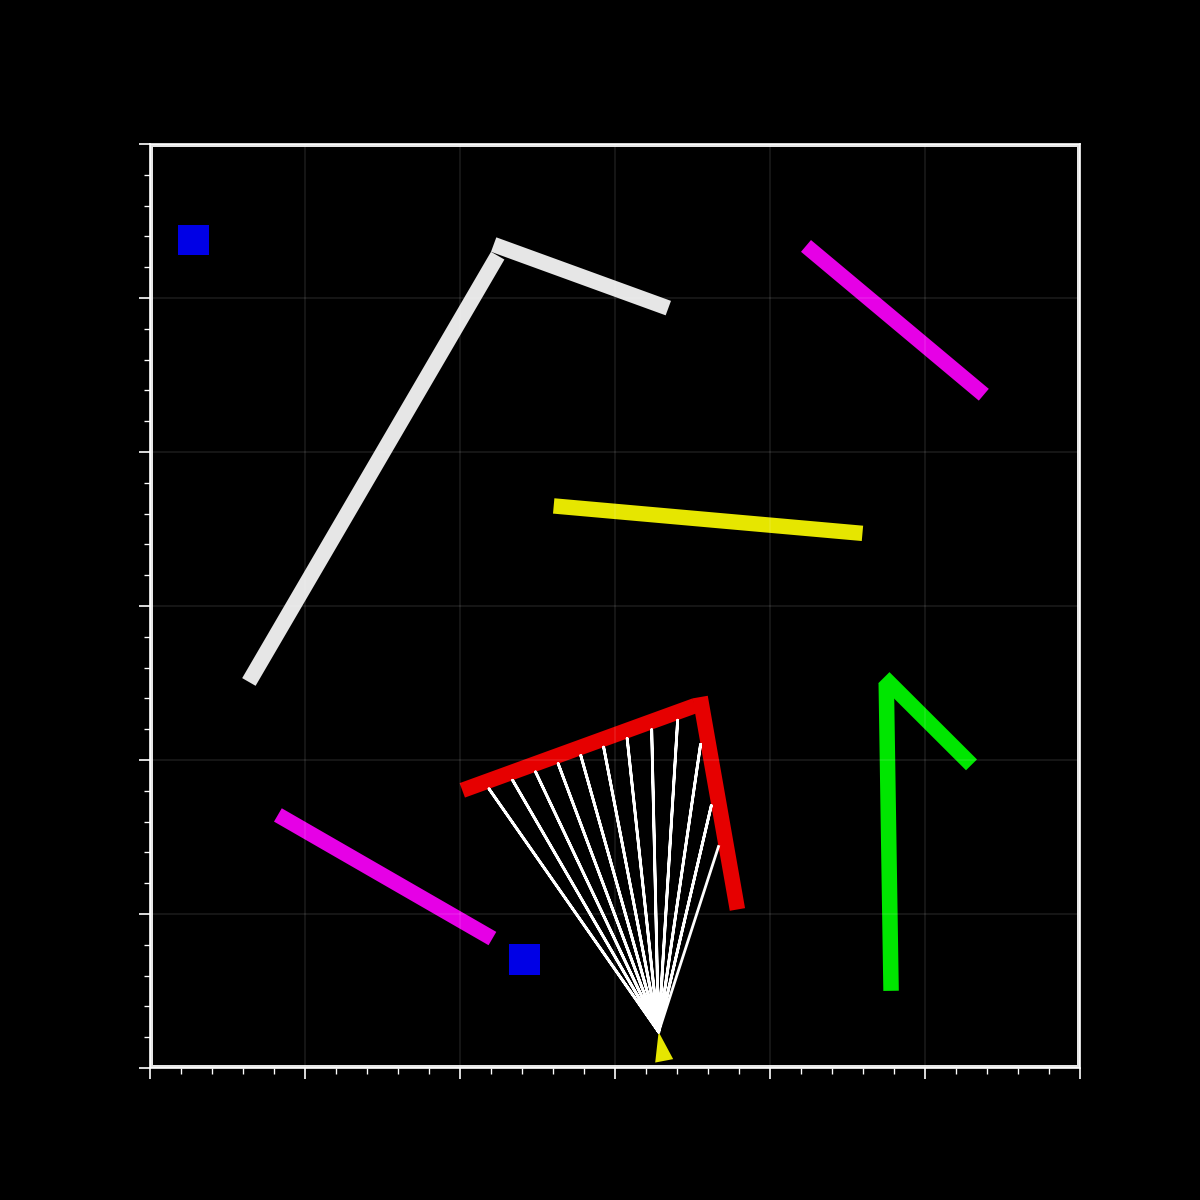

In [88]:
env.reset()
env.render('human')

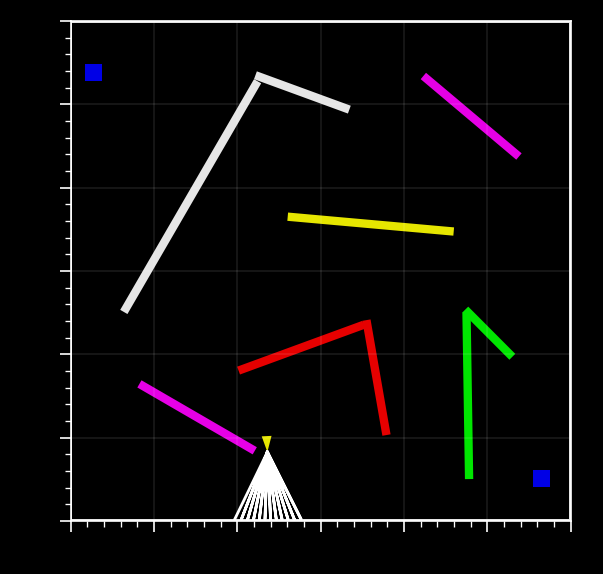

In [109]:
fig, ax = pplt.subplots()
ax.format(xlim=[0, 300], ylim=[0, 300])
env.step(1)
env.render('human', ax=ax)

In [72]:
colors = ['purple', 'red', 'green', 'yellow', 'white', 'purple']
color_nums = np.cumsum([1, 2, 2, 1, 2, 1])

In [68]:
color_nums

array([0, 1, 3, 5, 6, 8, 9], dtype=int32)

In [74]:
for i in range(9):
    print(colors[np.argmax(i < color_nums)])

purple
red
red
green
green
yellow
white
white
purple


In [6]:
import itertools
from tqdm import tqdm

xgrid = np.linspace(5, 295, 150)
grid = list(itertools.product(xgrid, xgrid))
valid_grids = []

box_size = 10
for corner in tqdm(grid):
    box = Box(np.array(corner), np.array([box_size, box_size]))
    test_walls = box.get_walls()
    add_wall = True
    for wall in test_walls:
        if check_col(wall[0], wall[1], wall_xy):
            add_wall = False
            break
    if add
    valid_grids.append(corner)

SyntaxError: invalid syntax (896485363.py, line 17)

In [8]:
import itertools
from tqdm import tqdm

wall_xy = get_wall_xy(env)

xgrid = np.linspace(5, 295, 150)
grid = list(itertools.product(xgrid, xgrid))
valid_grids = []

box_size = 10
for corner in tqdm(grid):
    box = Box(np.array(corner), np.array([box_size, box_size]))
    test_walls = box.get_walls()
    add_wall = True
    for wall in test_walls:
        if check_col(wall[0], wall[1], wall_xy):
            add_wall = False
            break
    if add_wall:
        valid_grids.append(corner)

100%|████████████████████████████████████████████████████████████████████████████████| 22500/22500 [00:06<00:00, 3284.96it/s]


In [15]:
vg = np.array(valid_grids)

In [17]:
vg.shape

(17904, 2)

In [ ]:
xgrid = np.linspace(5, 290, 140)
grid = np.vstack(list(itertools.product(xgrid, xgrid)))
grid = grid[~(]

In [ ]:
len(grid)

14124

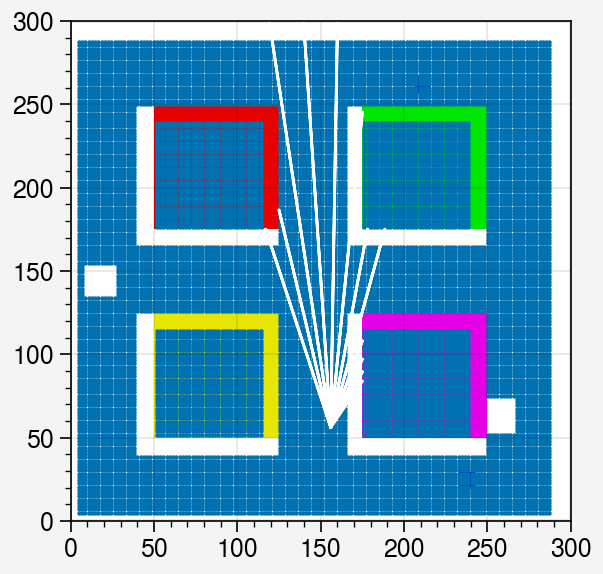

In [18]:
fig, ax = pplt.subplots()

start = np.array([30., 40.,])
end = np.array([80., 70.,])
ax.format(xlim=[0, 300], ylim=[0, 300])

env.render('human', ax=ax)
# ax.plot([start[0], end[0]], [start[1], end[1]])
ax.scatter(vg[:, 0], vg[:, 1], s=1)


In [138]:
wall_xy = get_wall_xy(env.col_walls)

In [148]:
%%timeit
check_col(start, end, wall_xy)

65.4 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


False


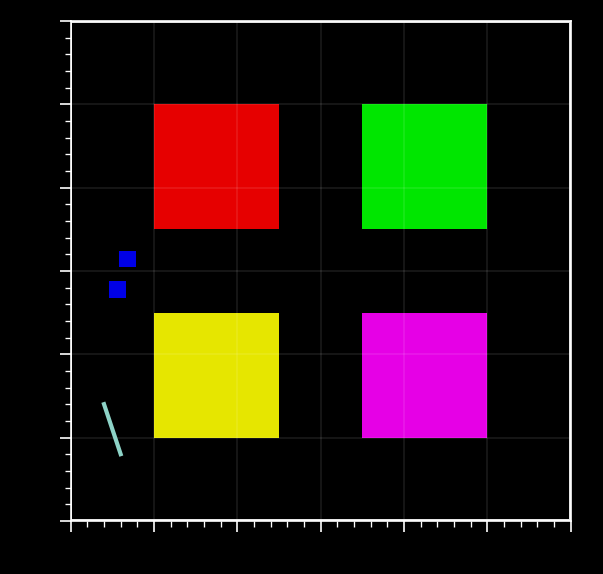

In [585]:
env = PlumNavEnv(render_character=False)

fig, ax = pplt.subplots()

start = np.array([30., 40.,])
end = np.array([20., 70.,])
ax.format(xlim=[0, 300], ylim=[0, 300])

env.render('human', ax=ax)
ax.plot([start[0], end[0]], [start[1], end[1]])
print(check_col(start, end, wall_xy))

In [ ]:
env.col_walls

[[[1, 0], [1, 300]],
 [[0, 1], [300, 1]],
 [[0, 299], [300, 299]],
 [[299, 0], [299, 300]],
 [(50.0, 175.0), (50.00000000000001, 250.0)],
 [(50.0, 175.0), (125.0, 175.0)],
 [(50.00000000000001, 250.0), (125.0, 250.0)],
 [(125.0, 175.0), (125.0, 250.0)],
 [(175.0, 175.0), (175.0, 250.0)],
 [(175.0, 175.0), (250.0, 175.0)],
 [(175.0, 250.0), (250.0, 250.0)],
 [(250.0, 175.0), (250.0, 250.0)],
 [(50.0, 50.0), (50.00000000000001, 125.0)],
 [(50.0, 50.0), (125.0, 50.0)],
 [(50.00000000000001, 125.0), (125.0, 125.0)],
 [(125.0, 50.0), (125.0, 125.0)],
 [(175.0, 50.0), (175.0, 125.0)],
 [(175.0, 50.0), (250.0, 50.0)],
 [(175.0, 125.0), (250.0, 125.0)],
 [(250.0, 50.0), (250.0, 125.0)]]

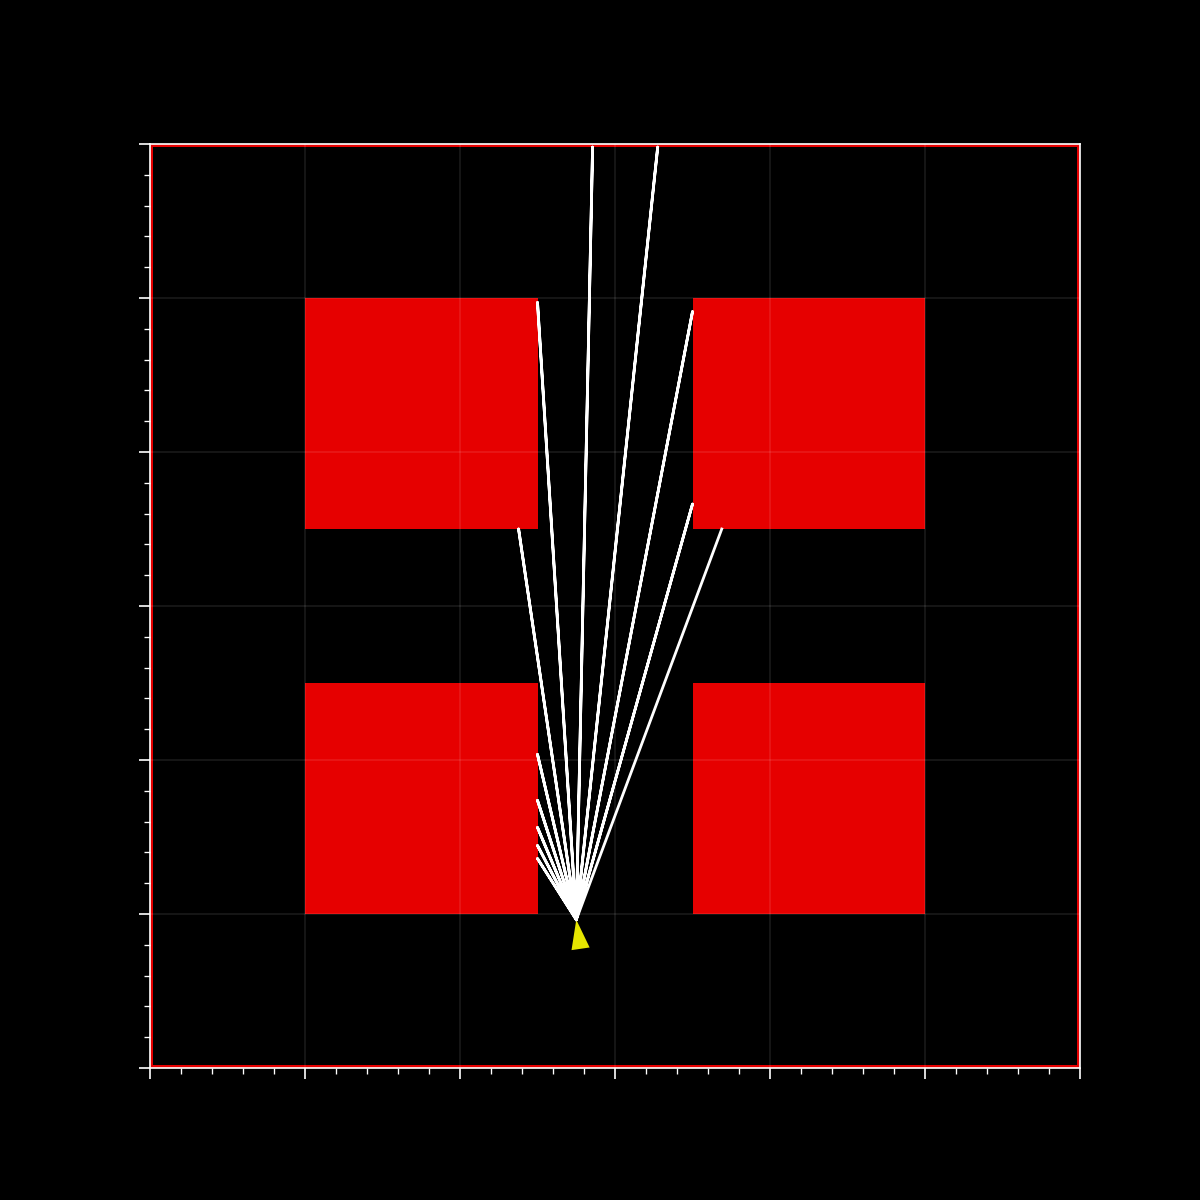

In [134]:
env.step(1)
env.render('human')

In [1]:
import gym
import gym_nav
import proplot as pplt

In [324]:
import numpy as np
import gym
from gym import spaces
import math
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.pyplot as plt
import io
import itertools

'''
This is the environment currently used for continuous MWM task

'''

MAX_MARCH = 20
EPSILON = 0.1
DEG_TO_RAD = 0.0174533
WINDOW_SIZE = (300, 300) # Width x Height in pixels
MAX_LEN = np.linalg.norm(WINDOW_SIZE)

object_to_idx = {
    'wall': 1,
    'goal': 2
}
color_to_idx = {
    'invisible': 0,
    'red': 1,
    'green': 2,
    'blue': 3,
    'yellow': 4,
    'purple': 5,
    'white': 6
}

idx_to_rgb = {
    0: np.array([0.6, 0.6, 0.6]),
    1: np.array([0.9, 0, 0]),
    2: np.array([0, 0.9, 0]),
    3: np.array([0, 0, 0.9]),
    4: np.array([0.9, 0.9, 0]),
    5: np.array([0.9, 0, 0.9]),
    6: np.array([0.9, 0.9, 0.9])
}



def dist(v):
    '''calculate length of vector'''
    return np.linalg.norm(v)


class Character:
    def __init__(self, pos=[WINDOW_SIZE[0]/2, WINDOW_SIZE[1]/2], angle=0, color=4, size=10,
                fov=120*DEG_TO_RAD, num_rays=30, render_rays=True, one_hot_obs=False):
        '''
        Generate a character that can move through the window
        pos: starting position
        angle: starting angle (radians) angle always takes on values from -pi to pi
        color: color
        size: size
        fov: range of angles character can see using rays
        num_rays: fidelity of depth perception
        draw_rays: whether or not to draw the characters rays
        '''
        self.pos = pos
        self.angle = (angle + np.pi) % (2*np.pi) - np.pi
        self.color = color
        self.size = size
        self.fov = fov
        self.render_rays = render_rays
        self.num_rays = num_rays
        self.one_hot_obs = one_hot_obs        
        self.ray_max_len = np.linalg.norm(WINDOW_SIZE)+100

        
    
    def update_walls(self, vis_walls, vis_wall_refs, col_walls, col_wall_refs):
        '''
        Update references to walls. This should be called when the environment changes
        or upon initialization
        vis_walls: walls that can be seen by vision rays
        col_walls: walls that can be collided with
        '''
        self.vis_walls = vis_walls
        self.vis_wall_refs = np.array(vis_wall_refs)
        
        self.col_walls = col_walls
        self.col_wall_refs = np.array(col_wall_refs)
        
        #Walls organized into [x3, y3, x4, y4] which tell us where walls start and end
        self.wall_p = np.array(vis_walls).reshape(-1, 4)
        self.x3 = self.wall_p[:, 0].reshape(1, -1)
        self.y3 = self.wall_p[:, 1].reshape(1, -1)
        self.x4 = self.wall_p[:, 2].reshape(1, -1)
        self.y4 = self.wall_p[:, 3].reshape(1, -1)
        
        #Same for collidable walls for collision detection
        self.col_wall_p = np.array(col_walls).reshape(-1, 4)
        self.cx3 = self.col_wall_p[:, 0].reshape(1, -1)
        self.cy3 = self.col_wall_p[:, 1].reshape(1, -1)
        self.cx4 = self.col_wall_p[:, 2].reshape(1, -1)
        self.cy4 = self.col_wall_p[:, 3].reshape(1, -1)

        
    
    def update_rays(self):
        '''
        Update ray intersection computations
        This should be called every time the agent moves or turns
        https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect
        '''
        fov_start = self.angle - self.fov/2
        fov_end = fov_start + self.fov
        
        ray_angles = np.linspace(fov_start, fov_end, self.num_rays, endpoint=False)
        ray_mults = np.array([np.cos(ray_angles), np.sin(ray_angles)]).T
        ray_starts = np.full((self.num_rays, 2), self.pos)
        
        x1 = ray_starts[:, 0].reshape(-1, 1)
        y1 = ray_starts[:, 1].reshape(-1, 1)
        ray_ends = ray_mults * self.ray_max_len + self.pos
        x2 = ray_ends[:, 0].reshape(-1, 1)
        y2 = ray_ends[:, 1].reshape(-1, 1)
        
        #Compute intersect metrics
        epsilon = 1e-8
        denom = (self.y4-self.y3)*(x2-x1) - (self.x4-self.x3)*(y2-y1) + 1e-8
        ua = ((self.x4-self.x3)*(y1-self.y3) - (self.y4-self.y3)*(x1-self.x3)) / denom
        ub = ((x2-x1)*(y1-self.y3) - (y2-y1)*(x1-self.x3)) / denom

        #Compute x y intersects (they ARE both supposed to be ua)
        x = x1 + ua*(x2-x1)
        y = y1 + ua*(y2-y1)

        #Compute distances to intersects
        dists = np.sqrt((x - self.pos[0])**2 + (y - self.pos[1])**2)

        #Only keep distances with valid intersects
        mults = np.full(x.shape, 1.)
        mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

        #We get np.nan where lines are parallel which throws off the argmin
        # Setting parallel to inf should fix the issue
        dists[np.isnan(dists)] = np.inf

        wall_idxs = np.argmin(mults*dists, axis=1)
        wall_idxs2 = np.stack([np.arange(self.num_rays), wall_idxs])

        # inter_x = x[wall_idxs2[0], wall_idxs2[1]]
        # inter_y = y[wall_idxs2[0], wall_idxs2[1]]

        # Get distances, colors and a plottable        
        self.ray_dists = dists[wall_idxs2[0], wall_idxs2[1]]
        
        if self.one_hot_obs:
            self.ray_colors = list(map(lambda x: x.color-1, self.vis_wall_refs[wall_idxs]))
        else:
            self.ray_colors = list(map(lambda x: x.color-1, self.vis_wall_refs[wall_idxs]))
        
        ray_ends = ray_mults * self.ray_dists.reshape(-1, 1) + self.pos
        
        self.ray_plot = np.stack([ray_ends, 
                              np.array(list(self.pos)*len(ray_ends)).reshape(-1, 2)], 
                              axis=1).reshape(-1, 2)
            
    
    def draw(self, ax=None):
        '''
        draw the character
        '''
        angle1 = self.angle - 0.3
        angle2 = self.angle + 0.3
        point1 = [self.pos[0], self.pos[1]]
        point2 = [self.pos[0] - math.cos(angle1)*self.size, self.pos[1] - math.sin(angle1)*self.size]
        point3 = [self.pos[0] - math.cos(angle2)*self.size, self.pos[1] - math.sin(angle2)*self.size]

        draw_color = idx_to_rgb[self.color]
        
        poly = plt.Polygon([point1, point2, point3], fc=draw_color)
        if ax == None:
            plt.gca().add_patch(poly)
            
            if self.render_rays:
                plt.gca().plot(self.ray_plot.T[0], self.ray_plot.T[1], c='w', linewidth=1)
        else:
            ax.add_patch(poly)
            if self.render_rays:            
                ax.plot(self.ray_plot.T[0], self.ray_plot.T[1], c='w', linewidth=1)

       
        
    def move(self, speed):
        '''
        move in the faced direction with number of pixels of speed
        collision detection uses the same ray marching algorithm
        after moving, update the rays
        
        Note we have to pass the walls that can be collided with for movement
        '''
        start = self.pos
        end = [self.pos[0] + math.cos(self.angle) * speed, self.pos[1] + math.sin(self.angle) * speed]
        
        min_dist, collision_obj = self.march(start, end)

        if collision_obj == None:
            self.pos[0] += math.cos(self.angle) * speed
            self.pos[1] += math.sin(self.angle) * speed
            
        else:
            min_dist = max(min_dist, speed * 0.1) # Make sure agent can't move backwards
            
            self.pos[0] += math.cos(self.angle) * (min_dist - speed * 0.1)
            self.pos[1] += math.sin(self.angle) * (min_dist - speed * 0.1)
        self.update_rays()

        return collision_obj
            
            
    def march(self, start, end):
        '''
        March forward to check if there is collision with any walls
        start: starting position
        end: desired end position (may be stopped earlier if collision occurs)
        col_walls: wall objects that can detect collision
        col_wall_refs: corresponding wall object references
        '''                
        x1 = start[0]
        y1 = start[1]
        x2 = end[0]
        y2 = end[1]
        
        epsilon = 1e-8
        
        #Compute intersect metrics
        denom = (self.cy4-self.cy3)*(x2-x1) - (self.cx4-self.cx3)*(y2-y1) + epsilon
        ua = ((self.cx4-self.cx3)*(y1-self.cy3) - (self.cy4-self.cy3)*(x1-self.cx3)) / denom
        ub = ((x2-x1)*(y1-self.cy3) - (y2-y1)*(x1-self.cx3)) / denom

        #Compute x y intersects
        x = x1 + ua*(x2-x1)
        y = y1 + ua*(y2-y1)

        #Compute dists
        dists = np.sqrt((x - self.pos[0])**2 + (y - self.pos[1])**2).squeeze()
        
        #Only keep distances with valid intersects
        mults = np.full(x.shape, 1.)
        mults[((ua < 0) | (ua > 1) | (ub < 0) | (ub > 1))] = np.inf

        #We get np.nan where lines are parallel which throws off the argmin
        # Setting parallel to inf should fix the issue
        dists[np.isnan(dists)] = np.inf
        
        #Some intersection occurs
        if (mults != np.inf).any():
            min_idx = np.argmin(mults*dists)
            return dists[min_idx], self.col_wall_refs[min_idx]
        else:
            return np.min(dists), None
                    
    
        
    def rotate(self, angle):
        self.angle += angle
        self.angle = (self.angle + np.pi) % (2*np.pi) - np.pi
        self.update_rays()
        
    
    def ray_obs(self, max_depth=MAX_LEN):
        '''
        Get all rays and their distances to objects
        normalize_depth: divide depth readings by value 
        '''
        
        if self.one_hot_obs:
            ray_colors = np.zeros((self.num_rays, 6))
            ray_colors[np.arange(self.num_rays), self.ray_colors] = 1
            ray_colors = ray_colors.reshape(-1)
        else:
            ray_colors = np.array(self.ray_colors) / 6
        ray_dists = np.array(self.ray_dists) / max_depth
        
        visual = np.append(ray_colors, ray_dists)
        return visual






class Box():
    def __init__(self, corner, size, color=1, is_goal=False):
        self.size = size #this is a size 2 array for length and height
        self.color = color
        self.is_goal = is_goal
        self.corner = corner
        self.center = [self.corner[0] + self.size[0]/2, self.corner[1] + self.size[1]/2]
        
            
    def draw(self, ax=None):
        rect = plt.Rectangle(self.corner, self.size[0], self.size[1], fc=idx_to_rgb[self.color])

        draw_color = idx_to_rgb[self.color]
        
        if ax == None:
            plt.gca().add_patch(rect)
        else:
            ax.add_patch(rect)
        
    def get_walls(self):
        walls = [
                 [(self.corner[0], self.corner[1]), (self.corner[0], self.corner[1]+self.size[1])], #bl to ul
                 [(self.corner[0], self.corner[1]), (self.corner[0]+self.size[0], self.corner[1])], #bl to br
                 [(self.corner[0], self.corner[1]+self.size[1]), (self.corner[0]+self.size[0], self.corner[1]+self.size[1])], #ul to ur
                 [(self.corner[0]+self.size[0], self.corner[1]), (self.corner[0]+self.size[0], self.corner[1]+self.size[1])], #br to ur
                ]
        return walls






class Ray():
    def __init__(self, start, angle, color=6):
        '''
        Ray for ray marching
        if render_march is True, then we render the sdf circles used to calculate march 
        '''
        self.start = start
        self.angle = angle
        self.color = color
        self.touched_obj = None
        self.obj_dist = MAX_LEN
        
        
    def update(self, start=None, angle=None, vis_walls=[], vis_wall_refs=[]):
        '''
        update position and angle, perform march, determine object and distance
        '''
        if start is not None:
            self.start = start
        if angle is not None:
            self.angle = angle
        self.obj_dist, self.touched_obj = self.march(vis_walls, vis_wall_refs)
        
                
    def march(self, vis_walls, vis_wall_refs):
        '''
        perform ray march, find collision with object
        '''
        end = self.start + np.array([np.cos(self.angle), np.sin(self.angle)]) * MAX_LEN
        # print(end)
        intersects = []
        for vis_wall in vis_walls:
            intersects.append(intersect(self.start, end, vis_wall[0], vis_wall[1]))
        
        min_dist = np.inf
        min_idx = 0
        for idx, inter in enumerate(intersects):
            if inter != None:
                d = dist((inter[0]-self.start[0], inter[1]-self.start[1]))
                if d < min_dist:
                    min_dist = d
                    min_idx = idx
        # print(min_dist)
        if min_idx == None:
            return min_dist, min_idx
        else:
            return min_dist, vis_wall_refs[min_idx]
    
    def draw(self, ax=None):
        rect = plt.Rectangle(self.start, self.obj_dist, 1, self.angle * 180 / np.pi, fc=idx_to_rgb[self.color])

        draw_color = idx_to_rgb[self.color]
        if ax == None:
            plt.gca().add_patch(rect)
        else:
            ax.add_patch(rect)
        # plt.scatter([self.start[0]+self.obj_dist*math.cos(self.angle)], [self.start[1]+self.obj_dist*math.sin(self.angle)])
        
            
            
            

def intersect(p1, p2, p3, p4):
    x1,y1 = p1
    x2,y2 = p2
    x3,y3 = p3
    x4,y4 = p4
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return (x,y)






class ShortcutNavEnv(gym.Env):
    metadata = {"render.modes": ['rgb_array', 'human'], 'video.frames_per_second': 24}
    def __init__(self, num_rays=12, fov=1, max_steps=200,
                rew_structure='goal', give_heading=0, verbose=0,
                world_gen_func=None, world_gen_params={}, give_dist=True,
                give_time=False, collission_penalty=0, default_reward=0,
                sub_goal_reward=0.01, goal_visible=True,
                task_structure=2, poster=False, auxiliary_tasks=[],
                auxiliary_task_args=[], fixed_reset=[None, None],
                character_reset_pos=0, turn_speed=0.3, move_speed=10,
                num_actions=4, num_grid_slices=5, goal_size=25, goal_corner=None,
                separate_aux_tasks=False, poster_thickness=None,
                render_character=True, wall_thickness=None,
                one_hot_obs=True, shortcut_probability=0.2,
                wall_colors=4, shortcut_config=1, plum_pos=-1,):
        '''
        rew_structure: 'dist' - reward given based on distance to goal
                        'goal' - reward only given when goal reached
                        'explore' - additional reward given for each section explored
                        'explorepunish' - negative reward given when spending time near previous spots
        give_heading: whether to additionally give a distance and direction to goal
        flat: whether to give observations in a flattened state
        world_gen_func: a function can be passed to manually create a world
            using some other rules. Note that it needs to generate objects, a goal, and
            set the agent position and heading
            The character will be passed as the argument
        wall_colors: 
            1: red, red, red, red
            1.5: white, white, white, white (matching shortcut wall)
            4: red, green, blue, purple
            
        shortcut_config:
            1: 1 standard shortcut
            2: 2 shortcuts where shortcuts are farther from respective entrances
            2.5: 2 shortcuts where shortcuts are closer to respective entrances
        task_structure:
            1: visible goal, randomize position
            2: invisible goal, fixed position
            3: invisible goal, randomize position of char and goal at start
                try to reach the goal as many times as possible over fixed length episode
            4: invisible target. Agent is told which grid the target is assigned to through a one-hot
                encoding (pool divided into 5x5 grid of possible target cells). Every 40 timesteps the
                location changes
            5: same as 2 (invisible goal, fixed pos), but an additional action can be pressed to
                end the episode. If the agent is on top of the platform, they get a reward on reset
        poster:
            whether there should be a poster and on which wall [0-3]
        auxiliary_tasks: (pass as list of tasks desired)
            'null': task to output constant 0
            'euclidean_start': task to output euclidean distance travelled from start of episode
            'wall_direction': task to output relative degrees required to face a certain wall
            'terminal': task to output expected number of steps to episode end
                weighted by average episode length
        auxiliary_task_args: (pass as a list of arguments)
            'null': None (might later implement task to output n values)
            'euclidean_start': None
            'wall_direction': 1 (default), 2, 3, or 4 - pass wall that should be faced (east is 1, ccw)
        fixed_reset: (list of [np.ndarray, float]):
            First entry - fixed point to reset to
            Second entry - fixed angle to reset to
        character_reset_pos: 
            0: Default reset position - starting at the bottom and facing up
            1: Starting from anywhere in bottom right quadrant facing top half
            2: Starting from anywhere in bottom right quadrant facing any direction
            3: Starting from anywhere below shortcut wall
        goal_size: size of goal as int or array
        goal_corner: array giving x and y position of bottom left corner. If None, use default world
            generator function values
        separate_aux_tasks: !!must set to True to use new aux task learners that expect
            a list of auxiliary outputs (e.g. PPOAux, RolloutStorageAux etc.)
        poster_thickness: if given a value, set poster thickness to that value. Implemented
            to draw plots where the poster is clearer
        render_character: whether to render the character when rending the environment
        wall_thickness: if given a value, set wall thickness to that value
        one_hot_obs: wheter to set colors to be a one-hot encoded vector
            If False, colors are evenly spaced float values between 0 and 1, spaced by 7 possible values
        plum_steps: if transfering from a PlumNav env, how many steps to show a plum at the goal for
            to teach the agent where the goal is
        '''
        super(ShortcutNavEnv, self).__init__()

        #this gives the auxiliary tasks available and dimension of output
        available_auxiliary_tasks = {
            'null': 1,
            'euclidean_start': 1,
            'wall_direction': 1,
            'goal_dist': 1
        }
        auxiliary_task_to_idx = {
            'null': 0,
            'euclidean_start': 1,
            'wall_direction': 2,
            'goal_dist': 3
        }
        
        self.total_rewards = 0
        self.give_dist = give_dist
        self.give_heading = give_heading
        self.give_time = give_time
        self.collission_penalty = collission_penalty
        self.default_reward = default_reward
        self.sub_goal_reward = sub_goal_reward
        self.rew_structure = rew_structure
        self.task_structure = task_structure
        self.verbose = verbose
        self.world_gen_func = world_gen_func
        self.world_gen_params = world_gen_params
        self.goal_visible = goal_visible # Note: not used, visibility defined by
                                         # task structure at the moment
        if type(goal_size) == list:
            self.goal_size = np.array(goal_size)
        self.goal_size = goal_size
        self.goal_corner = goal_corner
        self.poster = poster
        self.num_rays = num_rays
        self.fov = fov
        if type(fixed_reset[0]) == list:
            fixed_reset[0] = np.array(fixed_reset[0])
        self.fixed_reset = fixed_reset
        self.character_reset_pos = character_reset_pos
        self.turn_speed = turn_speed
        self.move_speed = move_speed
        self.num_actions = num_actions
        self.num_grid_slices = num_grid_slices
        self.target_grid = 0
        self.last_reward = 0
        self.poster_thickness = poster_thickness
        self.wall_thickness = wall_thickness
        self.shortcut_probability = shortcut_probability
        self.wall_colors = wall_colors
        self.shortcut_config = shortcut_config
        self.shortcuts_available = [False]
        self.plum_pos = plum_pos
        
        observation_width = num_rays
        self.ray_obs_width = num_rays
        self.one_hot_obs = one_hot_obs
        
        if self.one_hot_obs:
            observation_width = num_rays * 6
        
        if give_dist:
            observation_width += num_rays
            self.ray_obs_width = observation_width
        if give_heading:
            observation_width += 1
        if give_time:
            observation_width += 1
        #For ongoing episode resetting position when goal reached,
        #agent needs to be told when platform is actually reached
        if task_structure == 3:
            observation_width += 1
            
        # task structure 4 tells the agent on which grid the goal is
        if task_structure == 4:
            num_grid = self.num_grid_slices ** 2
            observation_width += num_grid + 1
        
        #Add action for task_structure 5 that allows the agent to end the episode
        if task_structure == 5:
            self.num_actions = self.num_actions + 1

        self.observation_space = spaces.Box(low=0, high=1, shape=(observation_width,))
        self.action_space = spaces.Discrete(self.num_actions) #turn left, forward, right as actions
        
        self.max_steps = max_steps
        self.current_steps = 0
        
        self.character = Character(num_rays=self.num_rays, fov=self.fov, one_hot_obs=one_hot_obs)
        self.initial_character_position = self.character.pos.copy()
        self.render_character = render_character
        
        self.fig = None
        
        self.vis_walls = []
        self.vis_wall_refs = []
        self.col_walls = []
        self.col_wall_refs = []
        self.plums = {}
        self.visited_sections = np.zeros((num_grid_slices, num_grid_slices,))


        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        self.auxiliary_tasks = []
        self.auxiliary_task_args = auxiliary_task_args
        for task in auxiliary_tasks:
            if type(task) == int:
                self.auxiliary_tasks.append(task)
            elif task not in available_auxiliary_tasks.keys():
                raise NotImplementedError('Auxiliary task {} not found. Available options are '.format(
                    task, ', '.join(available_auxiliary_tasks.keys())))
            else:
                self.auxiliary_tasks.append(auxiliary_task_to_idx[task])
        self.separate_aux_tasks = separate_aux_tasks
        
        # self.auxiliary_tasks = [auxiliary_task_to_idx[task] for task in auxiliary_tasks]
        # print('auxiliary tasks', self.auxiliary_tasks)
        
        # New Character class: need to pass walls
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                            self.col_walls, self.col_wall_refs)
        
    def step(self, action):
        reward = self.default_reward
        collision_obj = None
        done = False
        info = {}
        
        if action == 0:
            self.character.rotate(-self.turn_speed)
        if action == 1:
            collision_obj = self.character.move(self.move_speed)
        if action == 2:
            self.character.rotate(self.turn_speed)
        if action == 3:
            pass
        if action == 4 and self.task_structure == 5:
            #Perform action to state that agent is on the platform
            on_goal = self.test_platform()
            if on_goal:
                reward = float(1)
                done = True

        if self.rew_structure == 'dist':
            goal = self.boxes[-1]
            dist_to_goal = self.sub_goal_reward * \
                (self.max_goal_dist - dist(goal.center - self.character.pos)) / self.max_goal_dist
                # Previously use max distance possible of entire pool, 
                # now use max distance from goal possible
                # (MAX_LEN-dist(goal.center - self.character.pos)) / MAX_LEN
                
            reward += float(dist_to_goal)
            info['bonus_reward'] = float(dist_to_goal)
        elif self.rew_structure == 'explore': 
            x_grids = np.linspace(0, WINDOW_SIZE[0], self.num_grid_slices+1)
            y_grids = np.linspace(0, WINDOW_SIZE[1], self.num_grid_slices+1)
            x = self.character.pos[0]
            y = self.character.pos[1]
            x_where = np.argwhere(x < x_grids)
            y_where = np.argwhere(y < y_grids)
            if len(x_where) > 0:
                x_grid = x_where[0] - 1
            else:
                x_grid = self.num_grid_slices - 1
            if len(y_where) > 0:
                y_grid = y_where[0] - 1
            else:
                y_grid = self.num_grid_slices - 1
            
            if self.visited_sections[x_grid, y_grid] == 0:
                self.visited_sections[x_grid, y_grid] = 1
                reward += self.sub_goal_reward
                info['bonus_reward'] = self.sub_goal_reward
            else:
                info['bonus_reward'] = 0
        elif self.rew_structure == 'explorepunish':
            pos = self.character.pos
            self.visited_positions[self.visited_idx] = pos.copy()
            self.visited_idx += 1

            lim_idx = int(np.clip(self.visited_idx-10, 0, np.inf))
            
            if lim_idx > 0:
                dists = self.visited_positions[:lim_idx] - pos
                dist = np.min(np.sum(dists**2, axis=1))
                dist = np.sqrt(dist)
                
                # This pretty much goes to 0 around dist of 50, which is tuned
                #  to a move speed of 10
                punish = -np.exp(-dist/10) * self.sub_goal_reward
                reward += punish
                info['bonus_reward'] = punish
            
        if collision_obj != None:
            if collision_obj.is_goal:
                if self.verbose:
                    print('goal reached!')
                reward = float(1)
                
                #If performing a fixed platform experiment, episode
                #ends on collision. For moving platform, only character position resets
                if self.task_structure <= 2:
                    done = True
                else:
                    #Note that character position is reset for task_structure 3 when colliding with
                    #the platform even though episode is not reset
                    self.reset_character_position()
            elif 'plum' in self.plums and self.plums['plum'] == collision_obj:
                # plum found, generate new one
                reward = float(0.1)
                corner = self.generate_plum()
                plum = Box(corner, [10., 10.], color=color_to_idx['blue'])
                plum_walls, plum_wall_refs = self.get_walls([plum])
                vis_idx = self.plums['vis_idx']
                col_idx = self.plums['col_idx']
                for i in range(4):
                    self.vis_walls[vis_idx+i] = plum_walls[i]
                    self.vis_wall_refs[vis_idx+i] = plum
                    self.col_walls[col_idx+i] = plum_walls[i]
                    self.col_wall_refs[col_idx+i] = plum
                self.plums['plum'] = plum
                
                self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                                            self.col_walls, self.col_wall_refs)
                self.character.update_rays()

            else:
#                 reward = -10
                reward = float(self.collission_penalty)
                
        if self.task_structure == 4:
            # Give reward if character is in the correct grid
            # Every 40 steps, change the current grid goal
            if (self.current_steps != 0 and 
                self.current_steps % 40 == 0):
                self.change_target_grid()
            pos = self.character.pos
            x_grid = int(np.floor(self.target_grid / self.num_grid_slices))
            y_grid = self.target_grid % self.num_grid_slices
            x_low = x_grid * WINDOW_SIZE[0] / self.num_grid_slices
            x_high = (x_grid + 1) * WINDOW_SIZE[0] / self.num_grid_slices
            y_low = y_grid * WINDOW_SIZE[1] / self.num_grid_slices
            y_high = (y_grid + 1) * WINDOW_SIZE[1] / self.num_grid_slices
            if x_low <= pos[0] <= x_high and y_low <= pos[1] <= y_high:
                reward = float(1)
            
        self.last_reward = reward
        observation = self.get_observation()
        
        if self.task_structure == 3 and collision_obj != None and \
            collision_obj.is_goal:
            observation[self.ray_obs_width] = 1
            
            if self.rew_structure == 'explorepunish':
                self.visited_positions = np.full((self.max_steps + 50, 2), np.inf)
                self.visited_idx = 0
        auxiliary_output = self.get_auxiliary_output()
        info['auxiliary'] = auxiliary_output
        
        if self.current_steps > self.max_steps:
            done = True
        
        self.current_steps += 1
        self.total_rewards += reward
        if done and self.verbose:
            print('done, total_reward:{}'.format(self.total_rewards))
        return observation, reward, done, info
    

    def reset(self):
        """
        start_point (numpy array, optional): Set the starting point
            of the agent
        start_angle (float, optional): Set the starting angle of the 
            agent
        """
        if self.world_gen_func is None:
            self.generate_world()
        else:
            self.world_gen_func(self.character, **self.world_gen_params)
        
        
        start_point = self.fixed_reset[0]
        start_angle = self.fixed_reset[1]
        if start_point is not None:
            if type(start_point) is not np.ndarray:
                raise ValueError("start_point must be np.ndarray")
            self.character.pos = start_point.copy()
        if start_angle is not None:
            self.character.angle = start_angle
        if self.task_structure == 4:
            self.change_target_grid()
        
        self.character.update_rays()
        observation = self.get_observation()
        self.initial_character_position = self.character.pos.copy()
        self.current_steps = 0
        self.total_rewards = 0
        
        self.visited_sections = np.zeros((self.num_grid_slices, self.num_grid_slices,))
        self.visited_positions = np.full((self.max_steps + 50, 2), np.inf)
        self.visited_idx = 0

        return observation

    
    def render(self, mode='rgb_array', ax=None):
        if ax == None:
            plt.style.use('dark_background')
            fig = plt.figure(figsize=(6,6))
            plt.xlim([0, WINDOW_SIZE[0]])
            plt.ylim([0, WINDOW_SIZE[1]])

        if self.render_character:
            self.character.draw(ax=ax)
        
        for box in self.boxes:
            box.draw(ax=ax)
        if 'plum' in self.plums:
            self.plums['plum'].draw(ax=ax)
        if self.task_structure == 4:
            x_grid = int(np.floor(self.target_grid / self.num_grid_slices))
            y_grid = self.target_grid % self.num_grid_slices
            x_low = x_grid * WINDOW_SIZE[0] / self.num_grid_slices
            y_low = y_grid * WINDOW_SIZE[1] / self.num_grid_slices
            x_size = WINDOW_SIZE[0] / self.num_grid_slices
            y_size = WINDOW_SIZE[1] / self.num_grid_slices
            corner = np.array([x_low, y_low])
            size = np.array([x_size, y_size])
            grid_box = Box(corner, size, color=6, is_goal=True)
            grid_box.draw(ax=ax)
        
        #trim borders
        # image_from_plot = image_from_plot[52:380,52:390,:]
        
        # with io.BytesIO() as buff:
        #     fig.savefig(buff, format='raw')
        #     buff.seek(0)
        #     data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
        # w, h = fig.canvas.get_width_height()
        # im = data.reshape((int(h), int(w), -1))
        
        if mode == 'human' and ax == None:
            plt.show()
            
        if mode == 'rgb_array':
            fig.canvas.draw()
            image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            plt.close()
            return image_from_plot
            
            # return im
            
        
    def get_observation(self):
#         ray_depths, ray_colors = self.character.ray_obs()
#         return np.append(ray_depths, ray_colors)

        if self.give_heading > 0:
            raise NotImplementedError('Have not adjusted give_heading code')
            #tell where the goal is distance and heading
            ray_obs = self.character.ray_obs()
            goal = objects[-1]
            dist_to_goal = np.clip(dist(goal.center - self.character.pos), 0, 1000) / 1000
            heading = goal.center - self.character.pos
            heading = np.arctan2(heading[1], heading[0])

            if self.give_heading == 1:
                #only give distance to goal
                obs = np.vstack([ray_obs, [dist_to_goal, 0, 0]])
            elif self.give_heading == 2:
                #give distance and angle to goal
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, 0]])
            elif self.give_heading == 3:
                #give distance and angle to goal and current agent angle
                obs = np.vstack([ray_obs, [dist_to_goal, heading/3.14, self.character.angle]])
            
                        
            return np.array(obs.reshape(-1), dtype='float')
            
        else:
            obs = self.character.ray_obs()
            if not self.give_dist:
                obs = obs[:self.num_rays]
            if self.task_structure == 3:
                obs = np.append(obs, [0.])
            if self.task_structure == 4:
                # Need to create one-hot encoding for grid target
                num_grid = self.num_grid_slices ** 2
                obs_add = np.zeros(num_grid + 1)
                obs_add[self.target_grid] = 1
                obs_add[num_grid] = self.last_reward
                obs = np.append(obs, obs_add)

            return obs
        
        
    def get_auxiliary_output(self):
        '''Return the auxiliary output dependent on what tasks are being measured'''
                
        auxiliary_output = []
        
        for i in range(len(self.auxiliary_tasks)):
        # for i, task in self.auxiliary_tasks:
            task = self.auxiliary_tasks[i]
            if i >= len(self.auxiliary_task_args):
                aux_arg = None
            else:
                aux_arg = self.auxiliary_task_args[i]
            #0: null task - predict 0
            if task == 0:
                output = [0]
            #1: euclidean distance from start task (normalized)
            if task == 1:
                euclid_dist_start = dist(self.character.pos - self.initial_character_position)
                euclid_dist_start = euclid_dist_start / MAX_LEN
                output = [euclid_dist_start]
            #2: relative angle from wall, depending on arg passed
                # give int from 0 to 3, 0 is east and 3 is south
            if task == 2:
                if aux_arg == None:
                    wall = 0
                else:
                    wall = aux_arg
                if wall < 0 or wall > 3:
                    raise Exception('Invalid wall number passed for relative wall direction auxiliary' + \
                        'task. Must use an integer between 0 and 3, or None (defaults to 0)')
                
                if wall > 2:
                    wall = wall - 4
                wall_angle = (wall * 0.5) * np.pi
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                
                min_rel_angle = np.min([abs(wall_angle - char_2pi_angle), 
                                        abs(wall_angle + 2*np.pi - char_2pi_angle)])
                min_rel_angle = min_rel_angle / np.pi
                output = [min_rel_angle]
            #3: distance between agent and goal
            if task == 3:
                goal_pos = self.boxes[-1].center
                char_pos = self.character.pos
                goal_dist = dist(char_pos - goal_pos)
                #normalize distance to [0, 1]
                goal_dist = goal_dist / MAX_LEN
                output = [goal_dist]
            #4-6 categorical auxiliary tasks
            #4: currently faced wall - output label 0-3 for currently faced wall
            if task == 4:
                #conversion of angle to be between 0 and 2pi, then check quadrant of angle faced
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                if char_2pi_angle < (np.pi/2):
                    quadrant = 0
                elif char_2pi_angle < (np.pi):
                    quadrant = 1
                elif char_2pi_angle < (np.pi*3/2):
                    quadrant = 2
                else:
                    quadrant = 3
                output = [quadrant]
            #5: left/right turn to face wall
            #  give int from 0 to 3 where 0 is east and 3 is south, agent
            #  must output 0 if a left turn or 1 if a right turn is faster to face that wall
            #  categorical analog to task 2
            if task == 5:
                if aux_arg == None:
                    wall = 0
                else:
                    wall = aux_arg
                if wall < 0 or wall > 3:
                    raise Exception('Invalid wall number passed for relative wall direction auxiliary' + \
                        'task. Must use an integer between 0 and 3, or None (defaults to 0)')
                
                if wall > 2:
                    wall = wall - 4
                wall_angle = (wall * 0.5) * np.pi
                char_2pi_angle = (self.character.angle + 2 * np.pi) % (2 * np.pi)
                
                left_angle = wall_angle - char_2pi_angle
                if left_angle < 0:
                    left_angle = 2*np.pi + left_angle
                right_angle = 2*np.pi - left_angle
                if left_angle > right_angle:
                    direction = 0
                else:
                    direction = 1
                output = [direction]
            #6: current quadrant location - output label 0-3 for current quadrant
            if task == 6:
                quadrant = 0
                char_pos = self.character.pos
                if char_pos[0] > WINDOW_SIZE[0]/2:
                    quadrant += 1
                if char_pos[1] > WINDOW_SIZE[1]/2:
                    quadrant += 2
                output = [quadrant]                
            if self.separate_aux_tasks:
                auxiliary_output.append(output)
            else:
                auxiliary_output += output
        if self.separate_aux_tasks:
            return auxiliary_output
        else:
            return np.array(auxiliary_output)
    
        

    def generate_world(self):
        if self.wall_thickness == None:
            wall_thickness = 1
        else:
            wall_thickness = self.wall_thickness
        
        if type(self.goal_size) == int:
            goal_size = [self.goal_size, self.goal_size]
        elif type(self.goal_size) == list:
            goal_size = self.goal_size
        else:
            goal_size = [20, 20]
                    
        
        if self.shortcut_config in [1]:
            num_shortcuts = 1
        elif self.shortcut_config in [2, 2.5]:
            num_shortcuts = 2
            
        make_shortwall = []
        if type(self.shortcut_probability) in [float, int]:
            for i in range(num_shortcuts):
                if np.random.random() < self.shortcut_probability:
                    make_shortwall.append(False)
                else:
                    make_shortwall.append(True)
        elif type(self.shortcut_probability) in [list, np.ndarray]:
            for i in range(num_shortcuts):
                if np.random.random() < self.shortcut_probability[i]:
                    make_shortwall.append(False)
                else:
                    make_shortwall.append(True)
        self.boxes, walls, wall_refs = self.make_walls(thickness=wall_thickness, with_shortwall=make_shortwall)
        
            
        if self.task_structure == 1:
            #generate a visible goal with random position
            corner = np.random.uniform(low=30, high=270, size=(2,))
            goal = Box(corner, goal_size, color=6, is_goal=True)
            goal_walls, goal_wall_refs = self.get_walls([goal])
            self.vis_walls, self.vis_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            self.boxes.append(goal)

        # We are using the task_structure 2 of fixed goal position from MWM env
        elif self.task_structure == 2 or self.task_structure == 5:
            if self.goal_corner == None:
                corner = np.array([262.5, 262.5])
            else:
                corner = self.goal_corner
            goal = Box(corner, goal_size, color=0, is_goal=True)            
            goal_walls, goal_wall_refs = self.get_walls([goal])
            self.vis_walls, self.vis_wall_refs = walls, wall_refs
            
            if self.task_structure == 2:
                # For usual invisible fixed platform task, make the platform collidable
                self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            elif self.task_structure == 5:
                # For task where agent must take action when it thinks it is on goal, platform is not collidable
                self.col_walls, self.col_wall_refs = walls, wall_refs
            self.boxes.append(goal)
        elif self.task_structure == 3:
            #generate randomly positioned invisible goal
            #min distance of 10 from the walls
            if self.goal_corner == None:
                corner = np.random.uniform(low=10, high=270, size=(2,))
            else: 
                corner = self.goal_corner
            goal = Box(corner, goal_size, color=0, is_goal=True)
            goal_walls, goal_wall_refs = self.get_walls([goal])
            self.vis_walls, self.vis_wall_refs = walls, wall_refs
            self.col_walls, self.col_wall_refs = walls + goal_walls, wall_refs + goal_wall_refs
            self.boxes.append(goal)
            
        # No platform generation for task 4
        elif self.task_structure == 4:
            corner = np.array([0., 0.])
            self.vis_walls, self.vis_wall_refs = walls, wall_refs
            self.col_walls, self.col_wall_refs = walls, wall_refs

        goal_center = self.boxes[-1].center
        max_x = max(WINDOW_SIZE[0]-goal_center[0], goal_center[0])
        max_y = max(WINDOW_SIZE[1]-goal_center[1], goal_center[1])
        self.max_goal_dist = dist([max_x, max_y])

        self.generate_valid_plum_grid()
        if self.plum_pos > -1:
            # add a plum where goal is
            corner = self.generate_plum()
            plum = Box(corner, [10., 10.], color=color_to_idx['blue'])
            plum_walls, plum_wall_refs = self.get_walls([plum])
            vis_idx = len(self.vis_walls)
            col_idx = len(self.col_walls)
            self.vis_walls += plum_walls
            self.vis_wall_refs += plum_wall_refs
            self.col_walls += plum_walls
            self.col_wall_refs += plum_wall_refs
            self.plums['plum'] = plum
            self.plums['vis_idx'] = vis_idx
            self.plums['col_idx'] = col_idx

        if self.character_reset_pos == 0:
            pos_x = np.random.uniform(125, 175)
            pos_y = np.random.uniform(10, 60)
            pos = np.array([pos_x, pos_y])
            angle = np.random.uniform(np.pi/2-0.2, np.pi/2+0.2)
        elif self.character_reset_pos == 1:
            # bottom-right quadrant, facing top hemisphere
            pos_x = np.random.uniform(140, 290)
            pos_y = np.random.uniform(10, 160)
            pos = np.array([pos_x, pos_y])
            angle = np.random.uniform(0, np.pi)
        elif self.character_reset_pos == 2:
            # bottom-right quadrant, facing anywhere
            pos_x = np.random.uniform(140, 290)
            pos_y = np.random.uniform(10, 160)
            pos = np.array([pos_x, pos_y])
            angle = np.random.uniform(-np.pi, np.pi)
        elif self.character_reset_pos == 3:
            # below shortcut wall, facing anywhere
            pos_x = np.random.uniform(10, 290)
            
            if self.shortcut_config in [1]:
                pos_y = np.random.uniform(10, 240)
            elif self.shortcut_config in [2, 2.5]:
                pos_y = np.random.uniform(10, 190)
            pos = np.array([pos_x, pos_y])
            angle = np.random.uniform(-np.pi, np.pi)
                            
        # if self.task_structure == 4:
        #     pos = np.array([150., 150.])
        #     angle = np.pi / 2
            
        self.character = Character(pos, angle, num_rays=self.num_rays, fov=self.fov, one_hot_obs=self.one_hot_obs)
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                                    self.col_walls, self.col_wall_refs)


    def reset_character_position(self):
        #Reset character position alone, used for task_structure 3
        # to reset character but not end episode after goal found
        searching = True
        goal_center = np.array(self.boxes[-1].center)
        if type(self.goal_size) == int:
            goal_size = [self.goal_size, self.goal_size]
        elif type(self.goal_size) == list:
            goal_size = self.goal_size
        else:
            goal_size = [20, 20]
        wall_thickness = 1
        
        pos = self.fixed_reset[0]
        angle = self.fixed_reset[1]

                    
        if angle == None:
            angle = np.random.uniform(0, 2*np.pi)

        self.character = Character(pos, angle, num_rays=self.num_rays, fov=self.fov,
                                   one_hot_obs=self.one_hot_obs)
        self.character.update_walls(self.vis_walls, self.vis_wall_refs,
                                    self.col_walls, self.col_wall_refs)
        self.character.update_rays()
        
        
    def generate_valid_plum_grid(self):
        if self.plum_pos == 0:
            xgrid = np.linspace(5, 285, 140)
            grid = np.vstack(list(itertools.product(xgrid, xgrid)))
            grid = grid[~(( grid[:, 1] > 235 ) & (grid[:, 1] < 255))]
            self.plum_grid = grid
        elif self.plum_pos == 1:
            xgrid = np.linspace(5, 285, 140)
            grid = np.vstack(list(itertools.product(xgrid, xgrid)))
            grid = grid[~(( grid[:, 1] > 235 ) & (grid[:, 1] < 255))]
            grid = grid[~(( grid[:, 1] < 150 ))]
            self.plum_grid = grid
        elif self.plum_pos == 2:
            xgrid = np.linspace(5, 285, 140)
            grid = np.vstack(list(itertools.product(xgrid, xgrid)))
            grid = grid[~((grid[:, 1] < 255))]
            self.plum_grid = grid
        elif self.plum_pos == 3:
            self.plum_grid = np.array([[260., 260.]])
        
        
    def generate_plum(self):
        # generate plum and return the corner of it
        idx = np.random.choice(range(len(self.plum_grid)))
        corner = self.plum_grid[idx]
        return corner

    def make_walls(self, thickness=1, with_shortwall=[True]):
        boxes = []
        y = WINDOW_SIZE[1]
        x = WINDOW_SIZE[0]

        if self.wall_colors == 4:
            walls = ['red', 'green', 'blue', 'yellow']
            wall_colors = [color_to_idx[color] for color in walls]        
        elif self.wall_colors == 1:
            walls = ['red', 'red', 'red', 'red']
            wall_colors = [color_to_idx[color] for color in walls]
        elif self.wall_colors == 1.5:
            walls = ['white', 'white', 'white', 'white']
            wall_colors = [color_to_idx[color] for color in walls]

        #outer walls
        boxes.append(Box(np.array([0, 0]), np.array([thickness, y]), color=wall_colors[2]))
        boxes.append(Box(np.array([0, 0]), np.array([x, thickness]), color=wall_colors[3]))
        boxes.append(Box(np.array([0, y-thickness]), np.array([x, thickness]), color=wall_colors[1]))
        boxes.append(Box(np.array([x-thickness, 0]), np.array([thickness, y]), color=wall_colors[0]))
                    
        # manually create walls here so that we don't need to check more walls than necessary
        # on intersections
        walls = [
            [[thickness, 0], [thickness, y]],
            [[0, thickness], [x, thickness]],
            [[0, y-thickness], [x, y-thickness]],
            [[x-thickness, 0], [x-thickness, y]]
        ]
        wall_refs = [
            boxes[0],
            boxes[1],
            boxes[2],
            boxes[3]
        ]

        self.shortcuts_available = list(~np.array(with_shortwall))
        if self.shortcut_config == 1:
            #shortcut wall
            boxes.append(Box(np.array([50, 250]), np.array([75, thickness]), color=color_to_idx['white']))
            boxes.append(Box(np.array([175, 250]), np.array([125, thickness]), color=color_to_idx['white']))
            walls.append([[50, 250], [125, 250]])
            walls.append([[175, 250], [300, 250]])
            wall_refs.append(boxes[4])
            wall_refs.append(boxes[5])
            
            if with_shortwall[0]:
                boxes.append(Box(np.array([125, 250]), np.array([50, thickness]), color=color_to_idx['purple']))
                walls.append([[125, 250], [175, 250]])
                wall_refs.append(boxes[6])
                
        elif self.shortcut_config == 2:
            #shortcut wall 1
            boxes.append(Box(np.array([50, 250]), np.array([125, thickness]), color=color_to_idx['white']))
            wall_refs.append(boxes[-1])
            boxes.append(Box(np.array([225, 250]), np.array([75, thickness]), color=color_to_idx['white']))
            wall_refs.append(boxes[-1])
            walls.append([[50, 250], [175, 250]])
            walls.append([[225, 250], [300, 250]])
            
            if with_shortwall[0]:
                boxes.append(Box(np.array([175, 250]), np.array([50, thickness]), color=color_to_idx['purple']))
                wall_refs.append(boxes[-1])
                walls.append([[175, 250], [225, 250]])
                
            #shortcut wall 2
            boxes.append(Box(np.array([0, 200]), np.array([75, thickness]), color=color_to_idx['white']))
            wall_refs.append(boxes[-1])
            boxes.append(Box(np.array([125, 200]), np.array([125, thickness]), color=color_to_idx['white']))
            wall_refs.append(boxes[-1])
            walls.append([[0, 200], [75, 200]])
            walls.append([[125, 200], [250, 200]])
            
            if with_shortwall[1]:
                boxes.append(Box(np.array([75, 200]), np.array([50, thickness]), color=color_to_idx['purple']))
                wall_refs.append(boxes[-1])
                walls.append([[75, 200], [125, 200]])

        elif self.shortcut_config == 2.5:
            #shortcut wall 1
            boxes.append(Box(np.array([50, 250]), np.array([50, thickness]), color=color_to_idx['white']))
            wall_refs.append(boxes[-1])
            boxes.append(Box(np.array([150, 250]), np.array([150, thickness]), color=color_to_idx['white']))
            wall_refs.append(boxes[-1])
            walls.append([[50, 250], [100, 250]])
            walls.append([[150, 250], [300, 250]])
            
            if with_shortwall[0]:
                boxes.append(Box(np.array([100, 250]), np.array([50, thickness]), color=color_to_idx['purple']))
                wall_refs.append(boxes[-1])
                walls.append([[100, 250], [150, 250]])
                
            #shortcut wall 2
            boxes.append(Box(np.array([0, 200]), np.array([150, thickness]), color=color_to_idx['white']))
            wall_refs.append(boxes[-1])
            boxes.append(Box(np.array([200, 200]), np.array([50, thickness]), color=color_to_idx['white']))
            wall_refs.append(boxes[-1])
            walls.append([[0, 200], [150, 200]])
            walls.append([[200, 200], [250, 200]])
            
            if with_shortwall[1]:
                boxes.append(Box(np.array([150, 200]), np.array([50, thickness]), color=color_to_idx['purple']))
                wall_refs.append(boxes[-1])
                walls.append([[150, 200], [200, 200]])
            
            
        return boxes, walls, wall_refs
        
    def get_walls(self, boxes):
        '''
        Get tuples of points to intersect with for rays from a list of boxes
        '''
        walls = []
        wall_refs = []
        for box in boxes:
            walls = walls + box.get_walls()
            wall_refs = wall_refs + [box] * 4
        return walls, wall_refs
    
    def change_target_grid(self):
        num_grid = self.num_grid_slices ** 2
        self.target_grid = np.random.choice(np.arange(num_grid))
        
    def test_platform(self):
        '''
        Used for task_structure 5 where agent must perform action 4 when they think
        they are on the platform. This function will test whether the agent is indeed on
        the platform
        '''
        char_pos = self.character.pos
        goal_pos = self.boxes[-1].center
        goal_size = self.boxes[-1].size
        
        pos_diff = np.abs(char_pos - goal_pos)
        return np.all(pos_diff <= goal_size)
        
        
        

    def seed(self, seed=0):
        np.random.seed(seed)
        
    def set_universal_step(self, universal_step):
        self.universal_step = universal_step

    def set_universal_arg(self, plum_pos):
        self.plum_pos = plum_pos


In [325]:
# env = gym.make('ShortcutNav-v0', plum_steps=100)
env = ShortcutNavEnv(wall_colors=1, shortcut_probability=1, plum_pos=0)

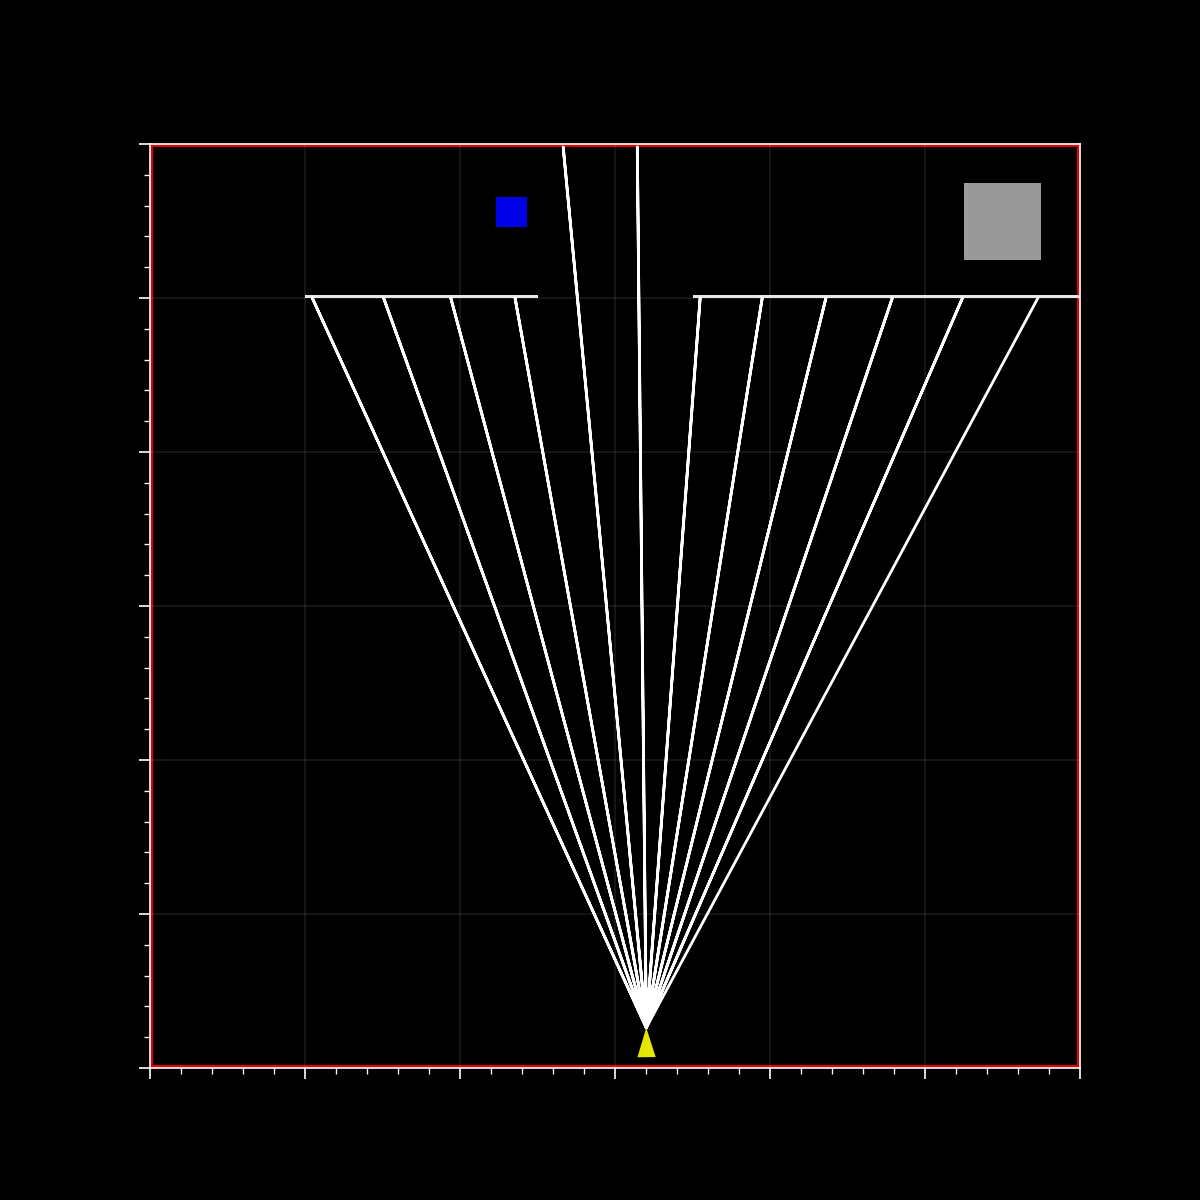

In [326]:
env.reset()
env.render('human')

(array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.70799211, 0.6283148 , 0.5683

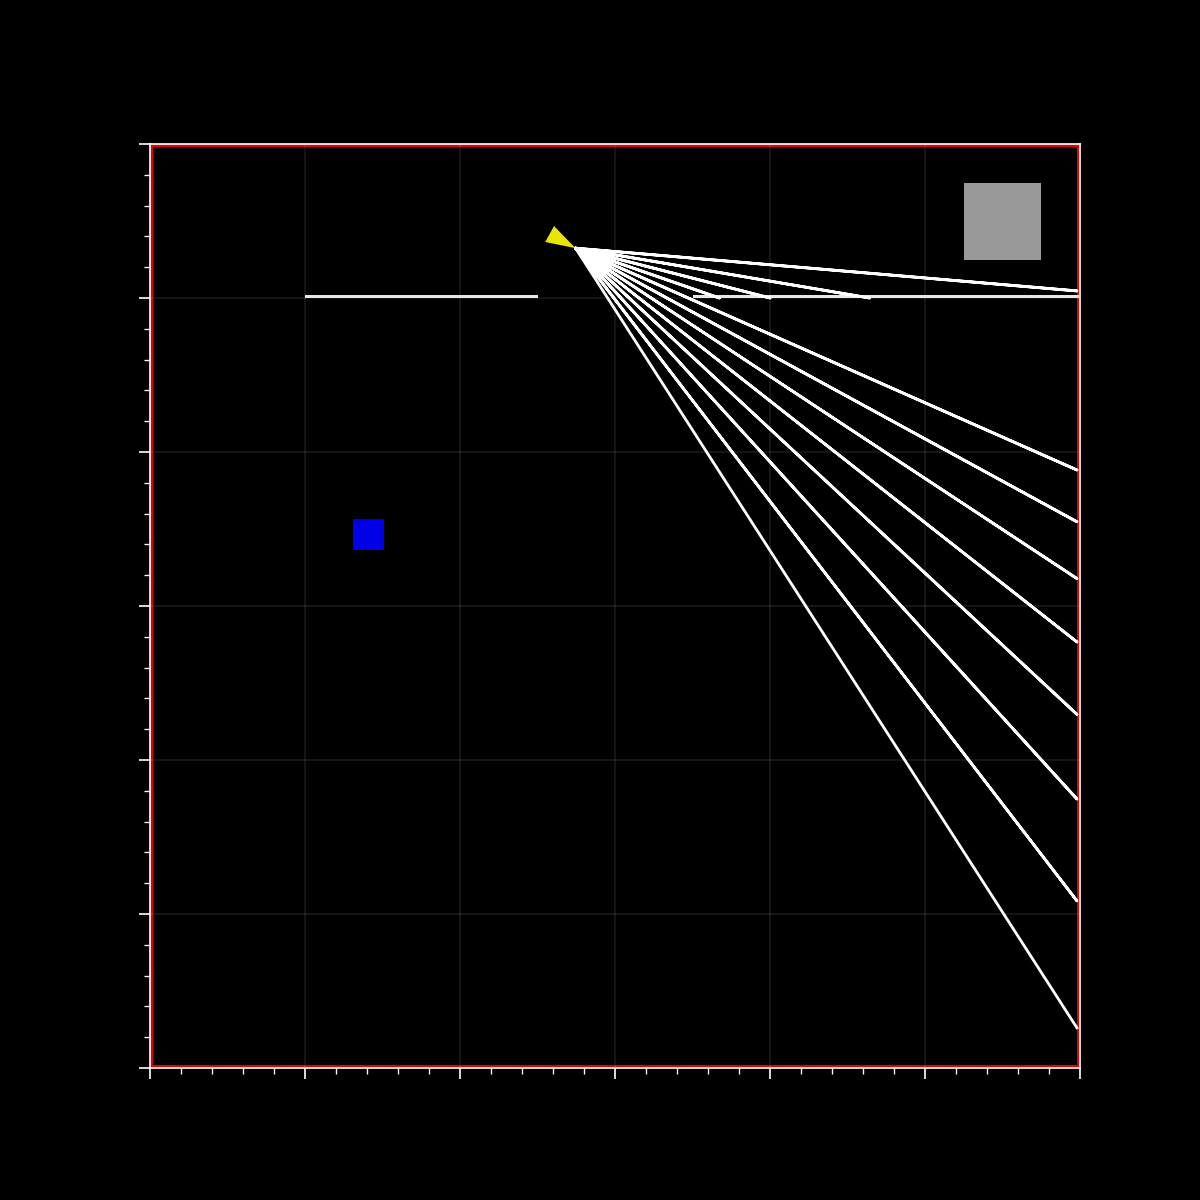

In [374]:
print(env.step(1))
env.render('human')

In [ ]:
xgrid = np.linspace(5, 285, 140)
grid = np.vstack(list(itertools.product(xgrid, xgrid)))


In [87]:
env.get_observation()

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.07536621, 0.07308057, 0.07141

In [98]:
a = np.array([[260., 260.]])

In [99]:
np.random.choice(a)

ValueError: a must be 1-dimensional

In [96]:
env.get_observation()

array([0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.26639803, 0.26677637, 0.26902

In [9]:
env = gym.make('PlumNav-v0', task_structure=3, shortcut_probability=0.1)


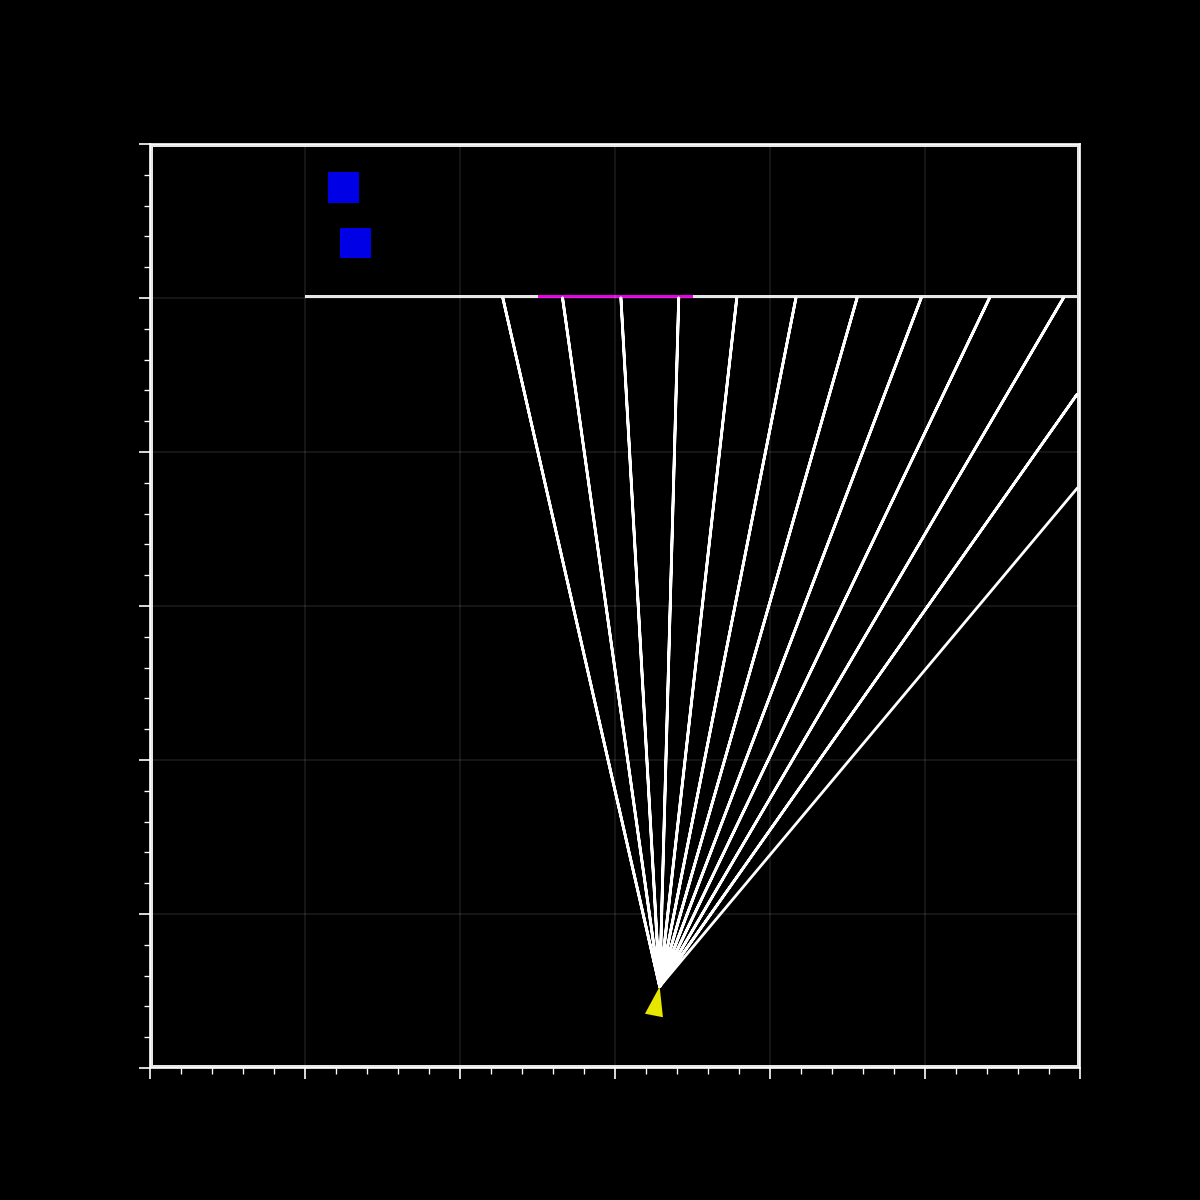

In [20]:
env.reset()
env.render('human')

# Visualizations

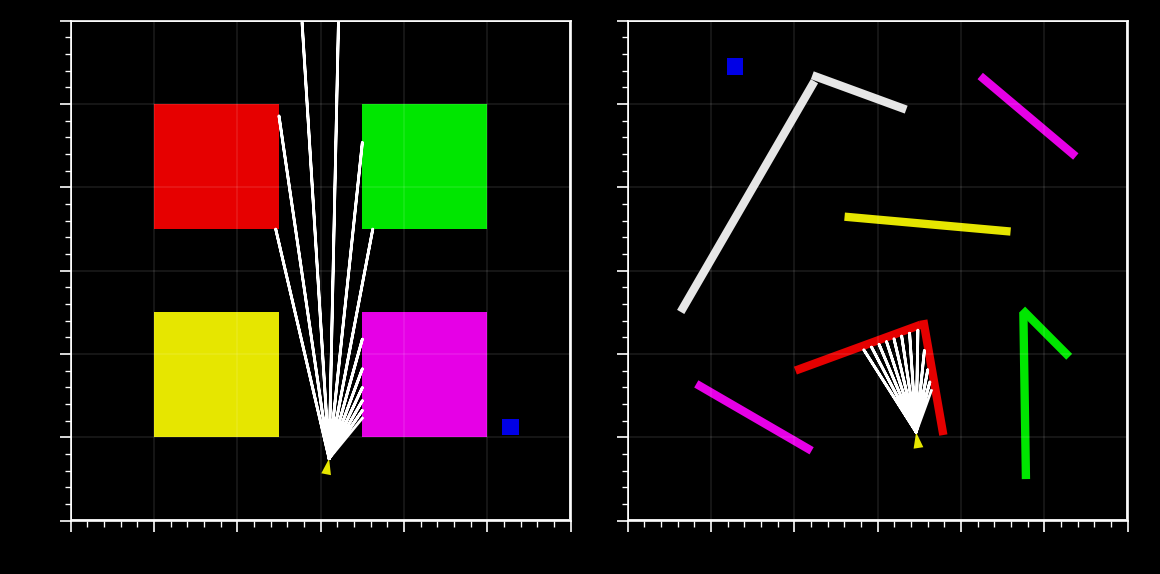

In [8]:
fig, ax = pplt.subplots(ncols=2)

tasks = [1, 2]
for i, task in enumerate(tasks):
    env = gym.make('PlumNav-v0', num_plums=1, task_structure=task)
    env.reset()
    env.render('human', ax=ax[i])

ax.format(xlim=[0, 300], ylim=[0, 300])

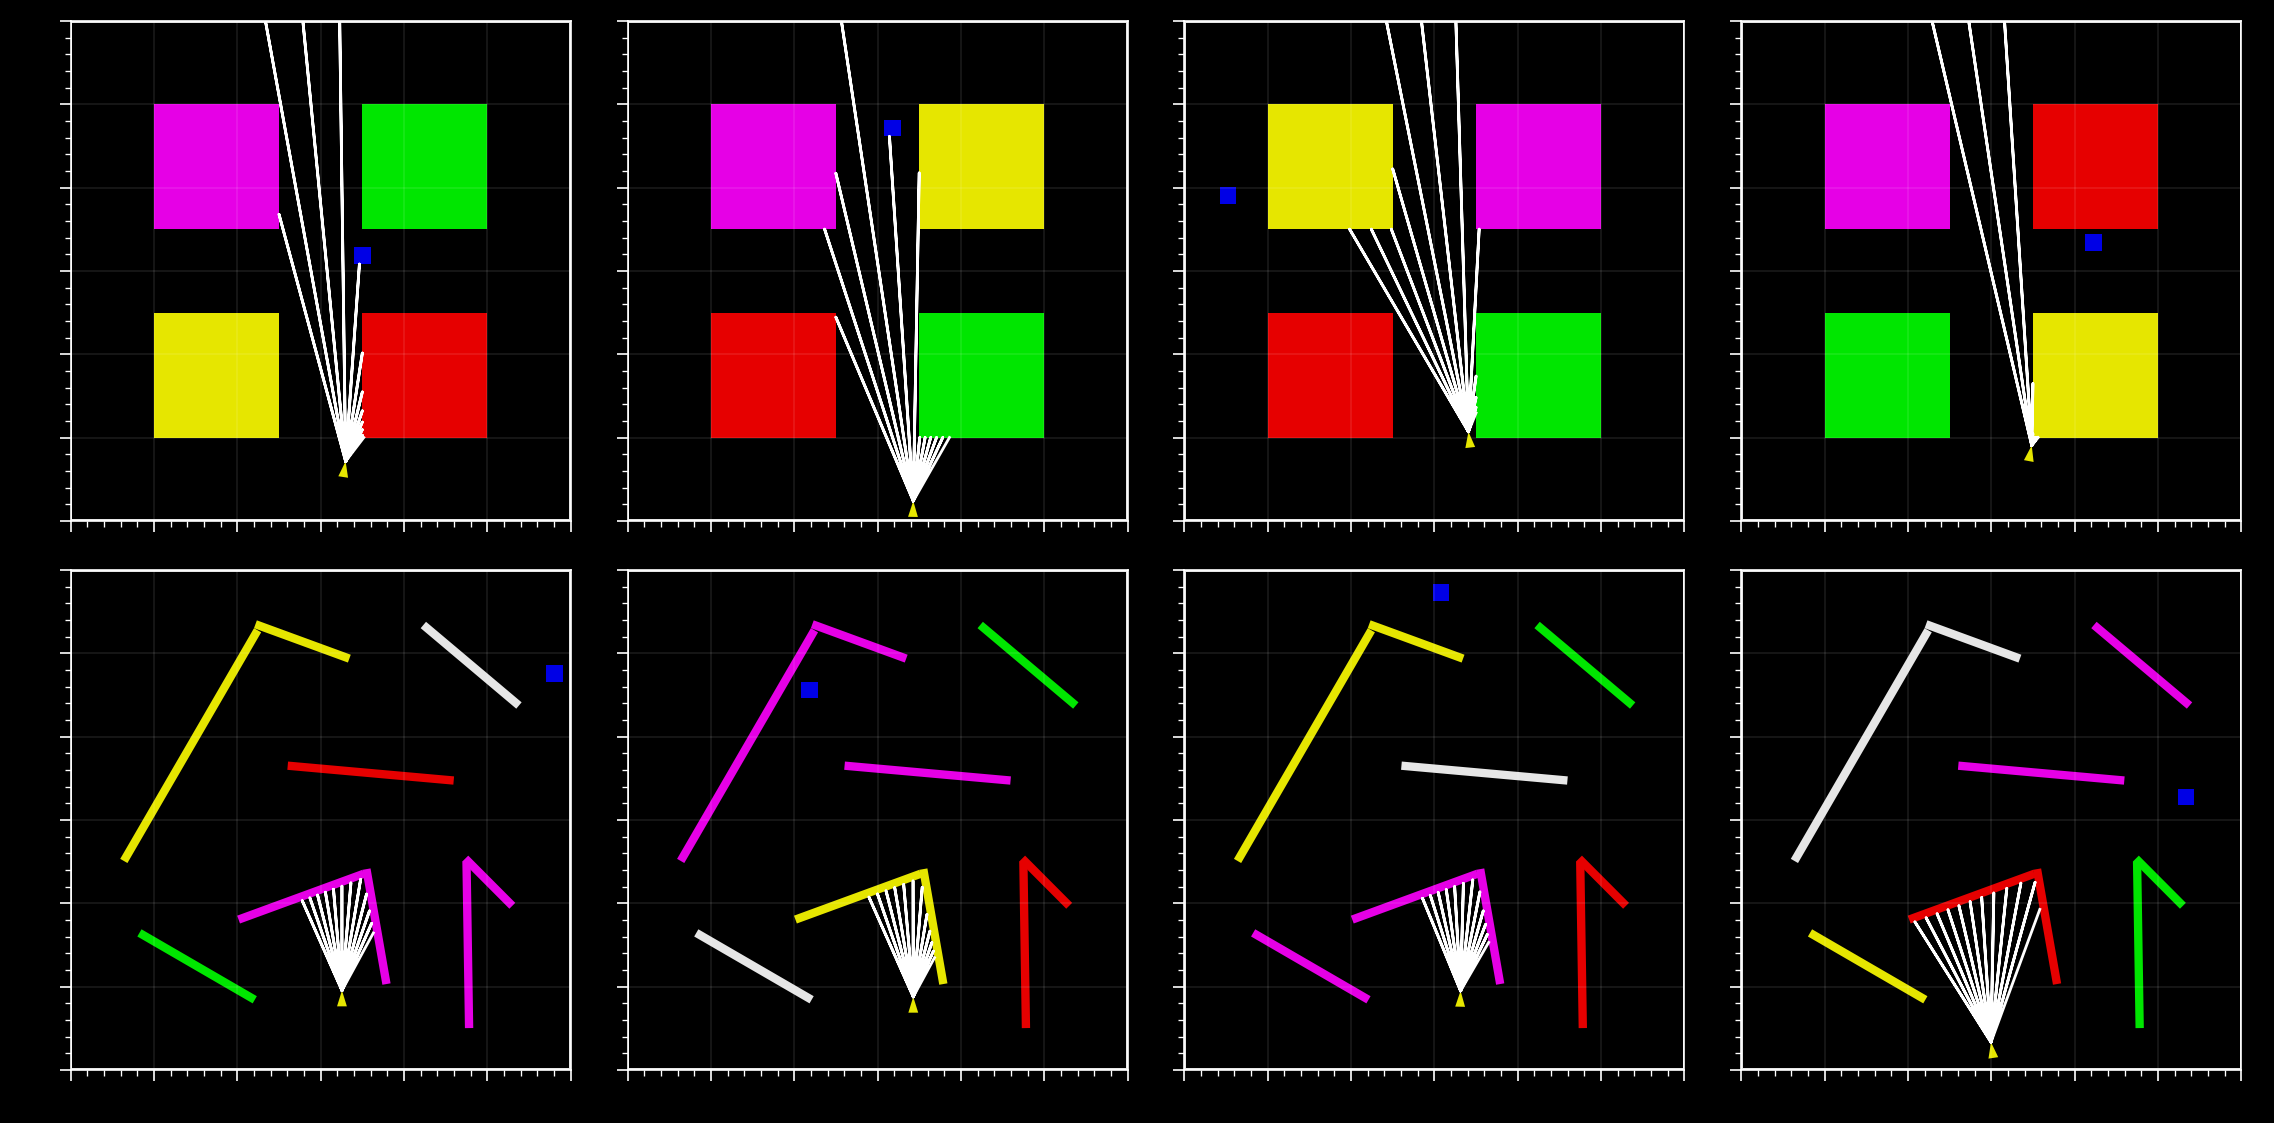

In [10]:
fig, ax = pplt.subplots(nrows=2, ncols=4)

tasks = [1.5, 2.5]
for i, task in enumerate(tasks):
    for j in range(4):
        env = gym.make('PlumNav-v0', num_plums=1, task_structure=task)
        env.reset()
        env.render('human', ax=ax[i, j])

ax.format(xlim=[0, 300], ylim=[0, 300])

In [19]:
import sys
sys.path.append('../')
from shortcut_analysis import *
from trajectories import draw_trajectory
%run ../evaluation

In [14]:
load_chk

<function model_evaluation.load_chk(exp_name, chk, trial=None, subdir='shortcut_resets', basedir='../saved_checkpoints')>

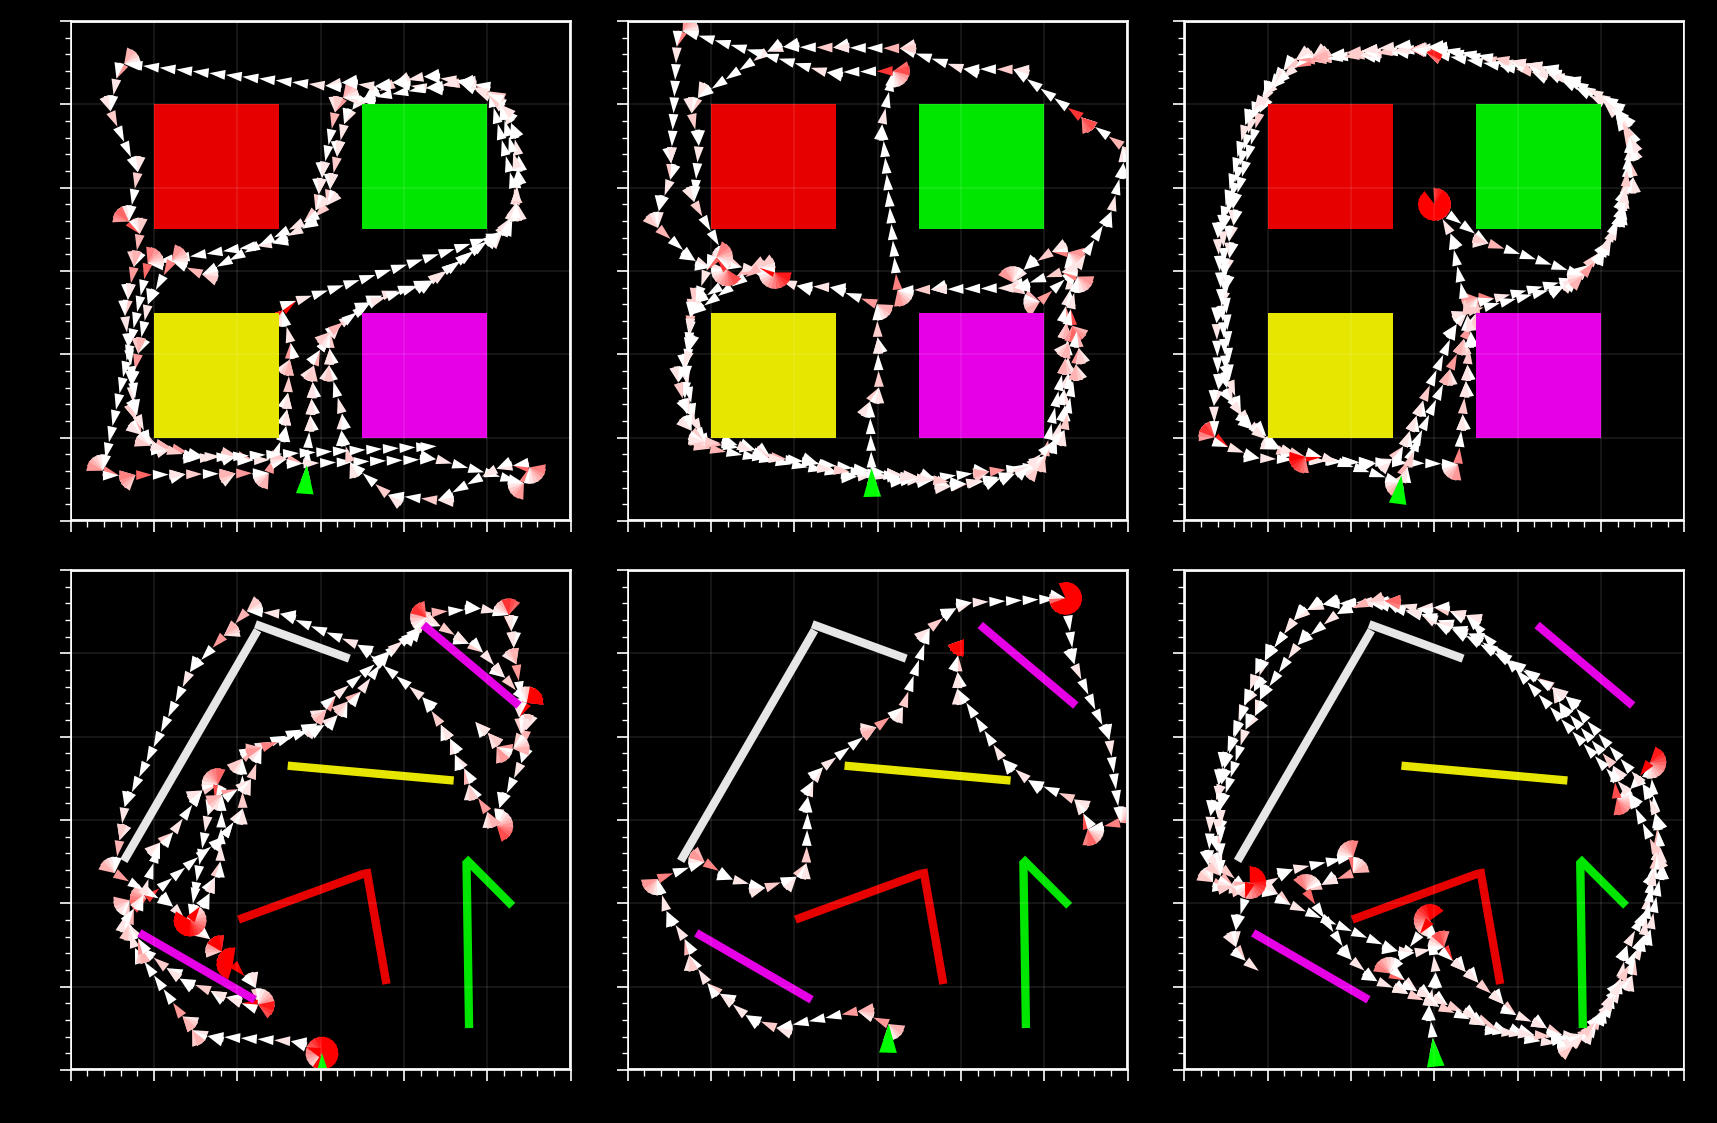

In [20]:
fig, ax = pplt.subplots(nrows=2, ncols=3)

tasks = [1, 2]
trials = range(3)
for i, task in enumerate(tasks):
    env = gym.make('PlumNav-v0', task_structure=task, render_character=False, num_plums=0)
    
    for j in trials:
        model, obs_rms = load_chk(f'plum/plum_task{task}_1plum', trial=j, chk=460, subdir='')
        res = evaluate(model, obs_rms, env_name='PlumNav-v0', env_kwargs={
            'task_structure': task, 'num_plums': 1
        }, num_episodes=1, data_callback=nav_data_callback)
        draw_trajectory(res['data']['pos'][0], res['data']['angle'][0], ax=ax[i, j])
        env.render('human', ax=ax[i, j])
        
ax.format(xlim=[0, 300], ylim=[0, 300])
    

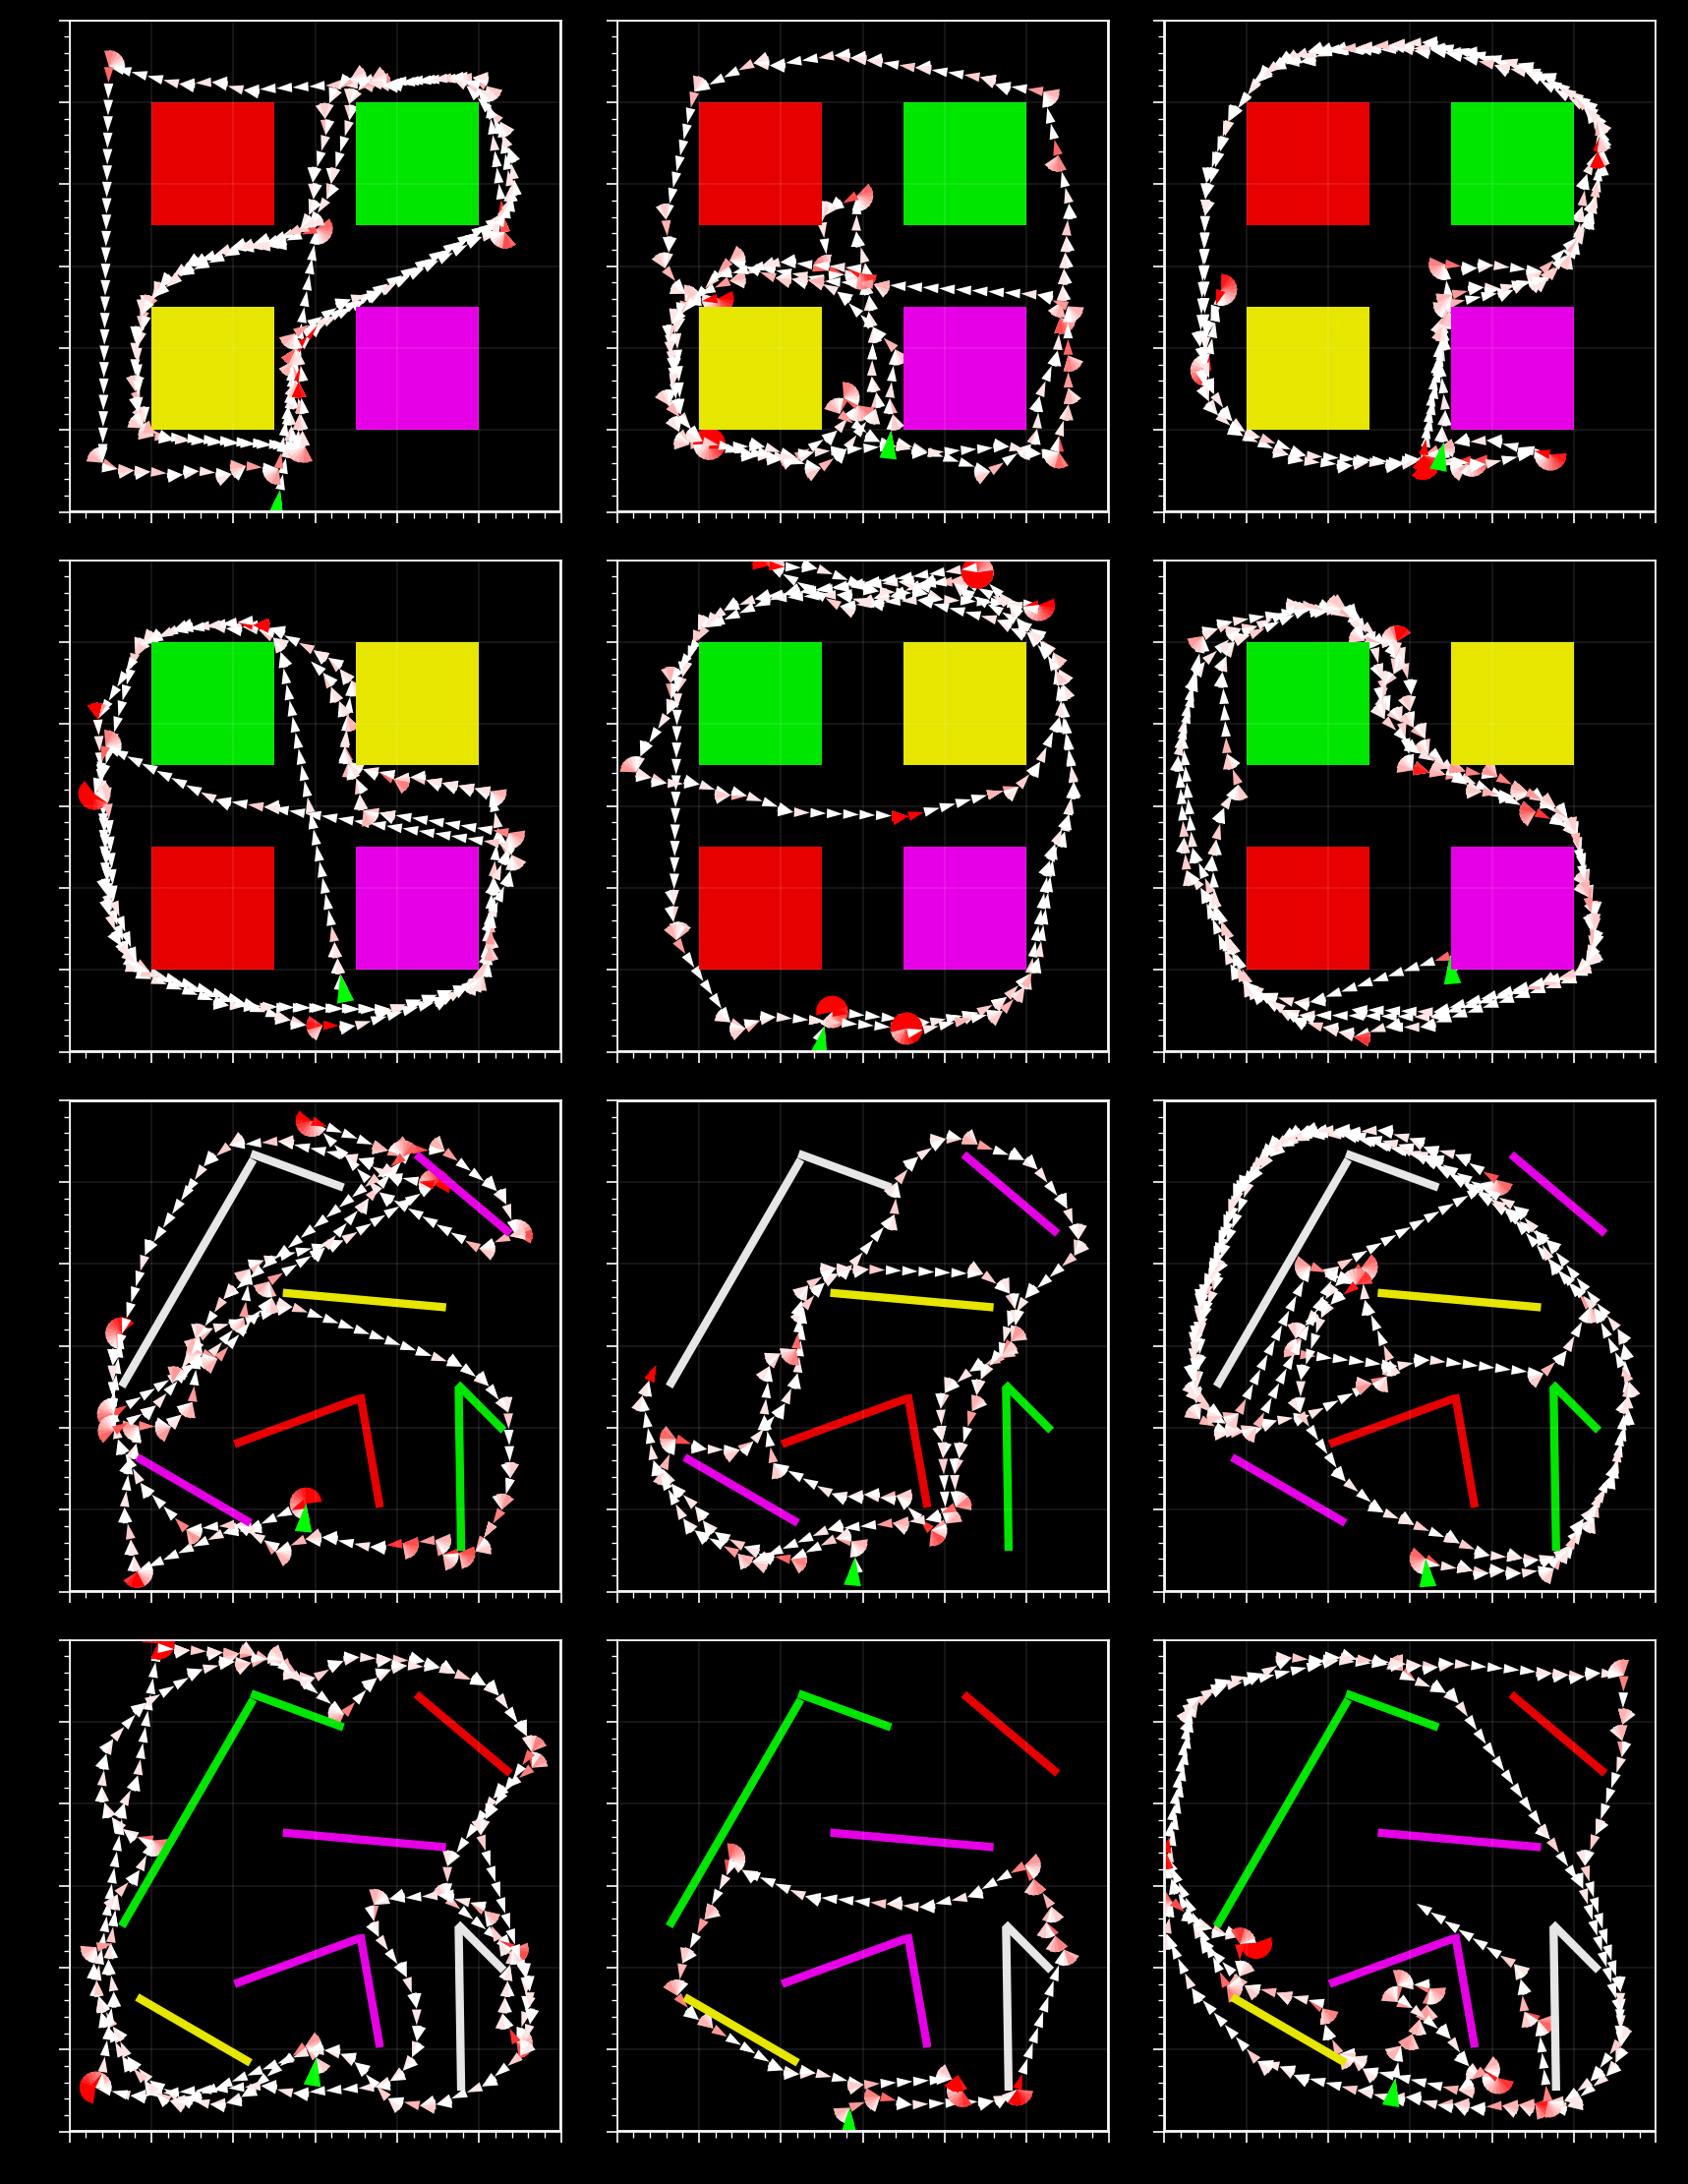

In [21]:
fig, ax = pplt.subplots(nrows=4, ncols=3)

tasks = [1, 1.5, 2, 2.5]
trials = range(3)
for i, task in enumerate(tasks):
    env = gym.make('PlumNav-v0', task_structure=task, render_character=False, num_plums=0)
    
    for j in trials:
        model, obs_rms = load_chk(f'plum/plum_task{task}_1plum', trial=j, chk=460, subdir='')
        res = evaluate(model, obs_rms, env_name='PlumNav-v0', env_kwargs={
            'task_structure': task, 'num_plums': 1
        }, num_episodes=1, data_callback=nav_data_callback)
        draw_trajectory(res['data']['pos'][0], res['data']['angle'][0], ax=ax[i, j])
        env.render('human', ax=ax[i, j])
        
ax.format(xlim=[0, 300], ylim=[0, 300])
    

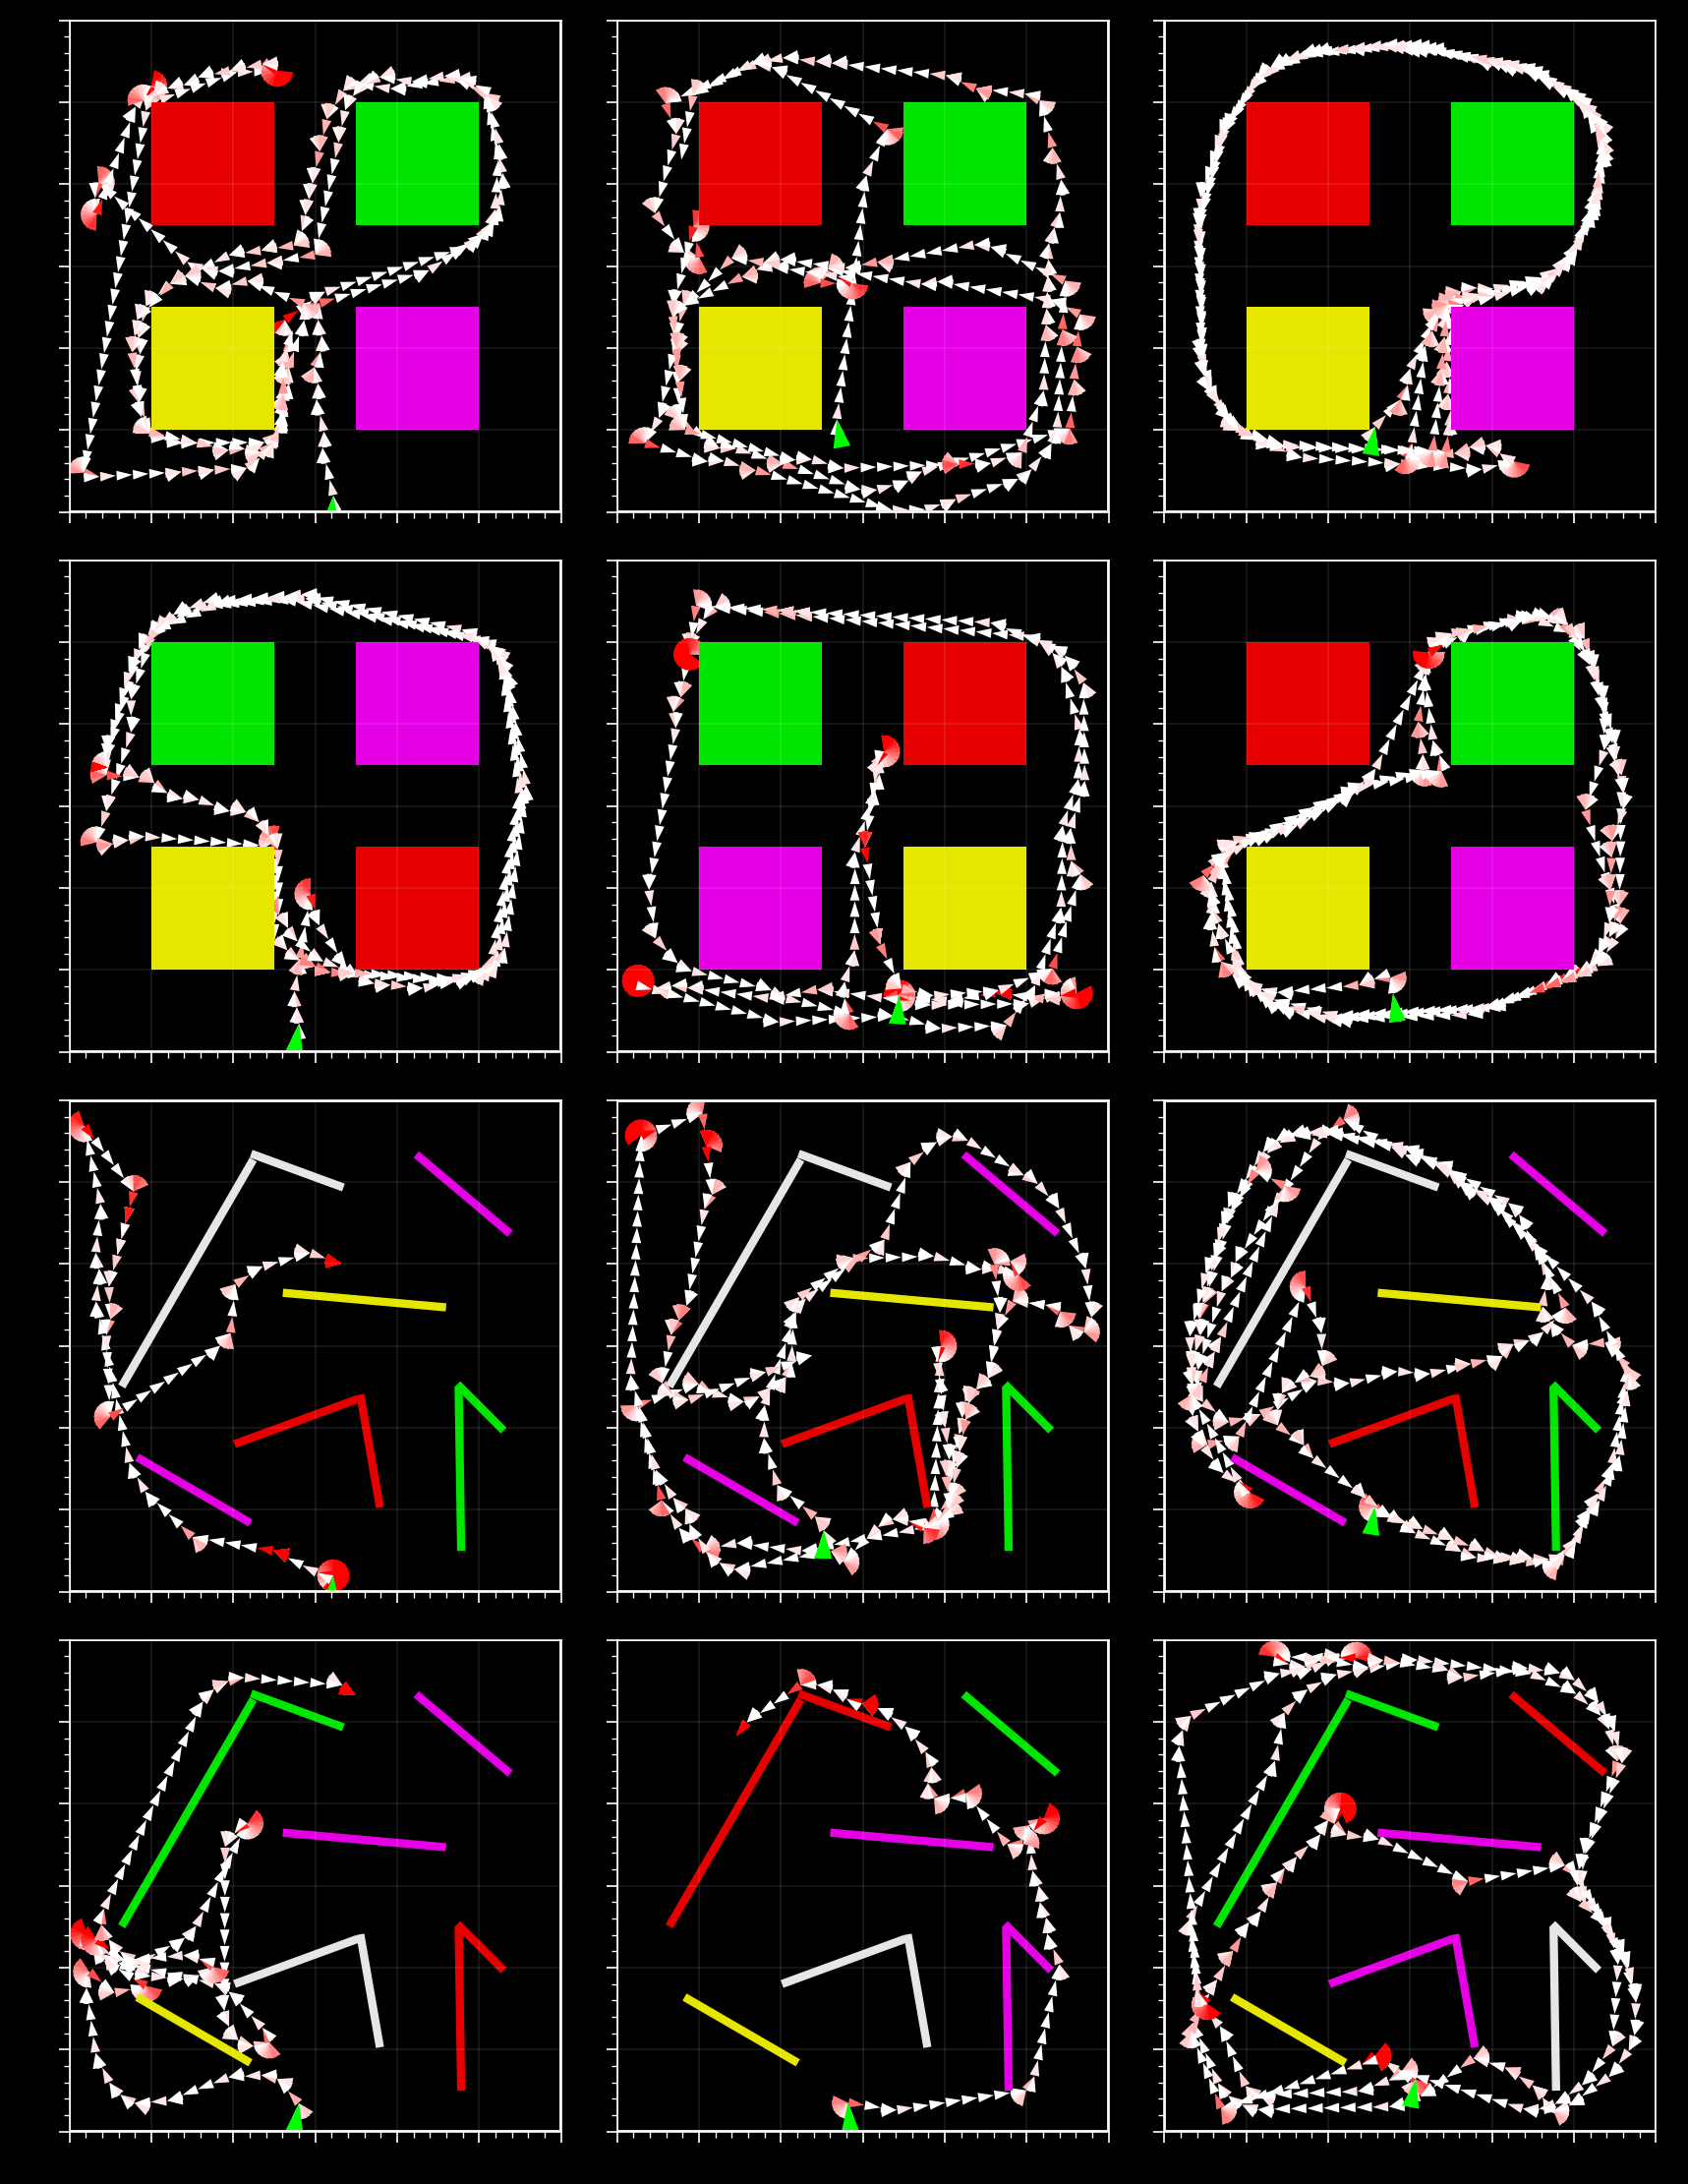

In [23]:
fig, ax = pplt.subplots(nrows=4, ncols=3)

tasks = [1, 1.5, 2, 2.5]
trials = range(3)
for i, task in enumerate(tasks):
    env = gym.make('PlumNav-v0', task_structure=task, render_character=False, num_plums=0)
    
    for j in trials:
        model, obs_rms = load_chk(f'plum/plum_task{task}_1plum', trial=j, chk=460, subdir='')
        res = evaluate(model, obs_rms, env_name='PlumNav-v0', env_kwargs={
            'task_structure': task, 'num_plums': 1
        }, num_episodes=1, data_callback=nav_data_callback, seed=j)
        draw_trajectory(res['data']['pos'][0], res['data']['angle'][0], ax=ax[i, j])
        env.reset()
        env.render('human', ax=ax[i, j])
        
ax.format(xlim=[0, 300], ylim=[0, 300])
    

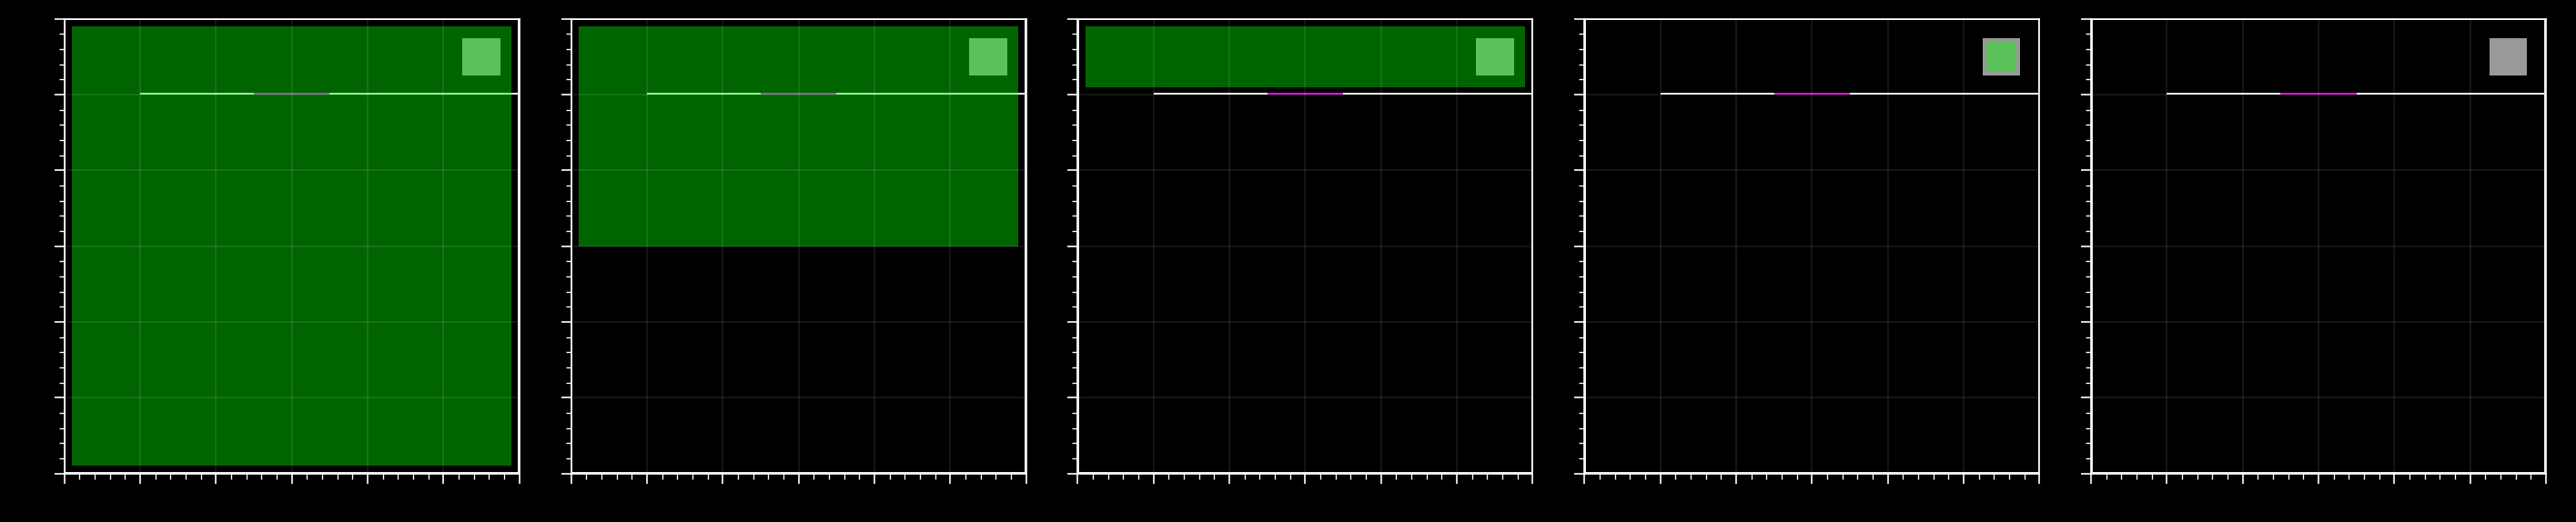

In [32]:
fig, ax = pplt.subplots(ncols=5)

corners = [
    [5, 5],
    [5, 150],
    [5, 255],
    [265, 265],
    None
]

sizes = [
    [290, 290],
    [290, 145],
    [290, 40],
    [20, 20],
    None
]

env = gym.make('ShortcutNav-v0', shortcut_probability=0, render_character=False,
              wall_colors=1.5)
env.reset()
for i, corner in enumerate(corners):
    env.render('human', ax=ax[i])
    if corner:
        width, height = sizes[i]
        rect = plt.Rectangle(corner, width, height, fc=[0, 1, 0, 0.4])
        ax[i].add_patch(rect)
        
ax.format(xlim=[0, 300], ylim=[0, 300])

# White and purple walls

In [12]:
import torch
import gym
import gym_nav
import sys
sys.path.append('../')
from ppo.model import *

In [17]:
from ppo.storage import *

In [39]:
env = gym.make('ShortcutNav-v0')

obs = env.reset()

obs = torch.tensor(obs, dtype=torch.float32)

In [23]:
storage = RolloutStorage(10, 1, [84], env.action_space, 64, 2)

In [32]:
rnn_hxs = storage.recurrent_hidden_states[0]
masks = storage.masks[0]

In [44]:
model = DelayedRNNPPO(84, auxiliary_heads=[[-1, 0, 1, 2], [-1, 0, 0, 1]])


In [45]:
model(obs, rnn_hxs, masks)

{'value': tensor([[0.0879]], grad_fn=<AddmmBackward0>),
 'actor_features': tensor([[-0.0035, -0.2039, -0.1025,  0.2830, -0.2464, -0.3328,  0.0841,  0.0130,
          -0.3952, -0.3437, -0.3028, -0.0562,  0.1755, -0.2613, -0.0650,  0.0596,
           0.0937,  0.0051, -0.1298,  0.2233, -0.1058,  0.1963, -0.6936, -0.1778,
           0.0379,  0.1461, -0.6107, -0.1827,  0.3802, -0.4385, -0.0375,  0.0085,
           0.1483,  0.3620,  0.1755,  0.3166, -0.1478,  0.0455, -0.3194,  0.0606,
          -0.0884, -0.3411,  0.1262, -0.0338,  0.1336, -0.2421, -0.2884,  0.0824,
          -0.1721, -0.4665, -0.2306,  0.1405,  0.1099, -0.2546, -0.1912, -0.1060,
          -0.3744,  0.4248,  0.1261,  0.1004,  0.3896, -0.4869,  0.3041, -0.2942]],
        grad_fn=<TanhBackward0>),
 'rnn_hxs': tensor([[-8.8091e-02, -2.9523e-01,  1.8861e-01, -3.8844e-04, -1.1907e-01,
          -1.1836e-01,  1.3710e-01, -2.4522e-01, -7.5109e-02, -2.9284e-01,
           3.2841e-02, -1.7864e-01,  1.3313e-01, -1.9807e-01, -6.5729e-02

In [14]:
env = gym.make('PlumNav-v0', task_structure=2.8, num_plums=1)


In [2]:
env = gym.make('PlumNav-v0', task_structure=3, num_plums=1)


In [3]:
obs = env.reset()

In [4]:
obs.shape

(84,)

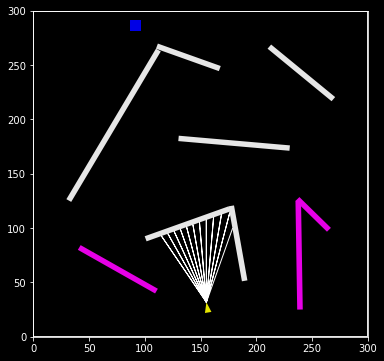

In [35]:
env.reset()
env.render('human')

In [38]:
model, obs_rms = torch.load('../saved_models/plum/plum_task3p0.4_t2.pt')

[Policy(
   (base): DelayedRNNPPO(
     (gru): GRU(64, 64)
     (shared0): Sequential(
       (0): Linear(in_features=85, out_features=64, bias=True)
       (1): Tanh()
     )
     (critic0): Sequential(
       (0): Linear(in_features=64, out_features=64, bias=True)
       (1): Tanh()
     )
     (critic1): Sequential(
       (0): Linear(in_features=64, out_features=64, bias=True)
       (1): Tanh()
     )
     (actor0): Sequential(
       (0): Linear(in_features=64, out_features=64, bias=True)
       (1): Tanh()
     )
     (actor1): Sequential(
       (0): Linear(in_features=64, out_features=64, bias=True)
       (1): Tanh()
     )
     (critic_head): Linear(in_features=64, out_features=1, bias=True)
   )
   (dist): Categorical(
     (linear): Linear(in_features=64, out_features=4, bias=True)
   )
 ),

In [2]:
env = gym.make('ShortcutNav-v0', auxiliary_tasks=[6], auxiliary_task_args=[None])

In [3]:
env.reset()

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.53210266, 0.59506169, 0.62927

In [19]:
env.step(1)

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.22744551, 0.21

# Auxiliary task testing

In [2]:
env = gym.make('ShortcutNav-v0', wall_colors=1.5, character_reset_pos=3, shortcut_probability=0.5, 
               auxiliary_tasks=[7], auxiliary_task_args=[0])

In [3]:
env.reset()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.58374101, 0.57000761, 0.56070

In [39]:
env.reset()

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.58091779, 0.59940846, 0.62358

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.28100644, 0.30279831, 0.3307

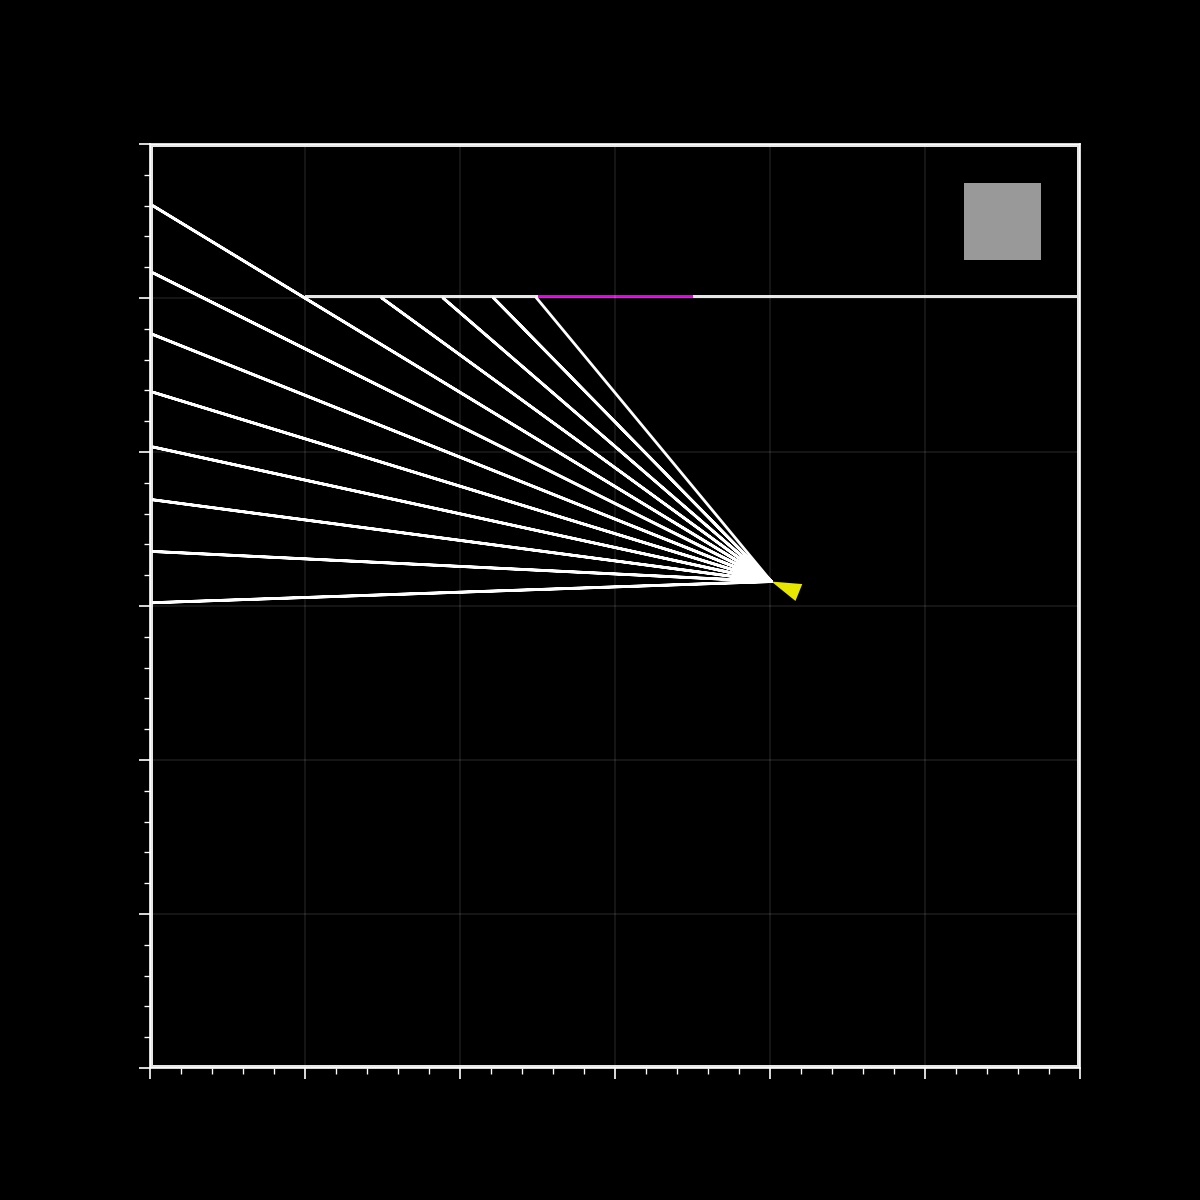

In [49]:
print(env.step(1))
env.render('human')